In [116]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
from pearce.emulator import OriginalRecipe, ExtraCrispy
from pearce.mocks import cat_dict
import numpy as np
from os import path

In [118]:
import tensorflow as tf

In [119]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [120]:
training_file = '/home/sean/PearceRedMagicXiChinchilla.hdf5'

em_method = 'nn'
split_method = 'random'

In [121]:
a = 1.0
z = 1.0/a - 1.0

In [122]:
fixed_params = {'z':z}

In [123]:
emu = OriginalRecipe(training_file, method = em_method, fixed_params=fixed_params,
                    hyperparams = {'hidden_layer_sizes': (10,),
                                 'activation': 'relu', 'verbose': True, 
                                    'tol': 1e-8, 'learning_rate_init':1e-2,\
                                   'max_iter':50, 'alpha':0, 'early_stopping':False, 'validation_fraction':0.3})

Iteration 1, loss = 0.13416098
Iteration 2, loss = 0.01241331
Iteration 3, loss = 0.00899551
Iteration 4, loss = 0.00777242
Iteration 5, loss = 0.00718608
Iteration 6, loss = 0.00682370
Iteration 7, loss = 0.00650097
Iteration 8, loss = 0.00624563
Iteration 9, loss = 0.00583640
Iteration 10, loss = 0.00536421
Iteration 11, loss = 0.00511643
Iteration 12, loss = 0.00483946
Iteration 13, loss = 0.00473470
Iteration 14, loss = 0.00471233
Iteration 15, loss = 0.00460303
Iteration 16, loss = 0.00455006
Iteration 17, loss = 0.00449471
Iteration 18, loss = 0.00443678
Iteration 19, loss = 0.00431901
Iteration 20, loss = 0.00430542
Iteration 21, loss = 0.00429334
Iteration 22, loss = 0.00420532
Iteration 23, loss = 0.00418612
Iteration 24, loss = 0.00408513
Iteration 25, loss = 0.00398661
Iteration 26, loss = 0.00406617
Iteration 27, loss = 0.00403576
Iteration 28, loss = 0.00403709
Training loss did not improve more than tol=0.000000 for two consecutive epochs. Stopping.


In [124]:
x_np, y_np = emu.x, emu.y

y_np = y_np*(emu._y_std + 1e-5) + emu._y_mean

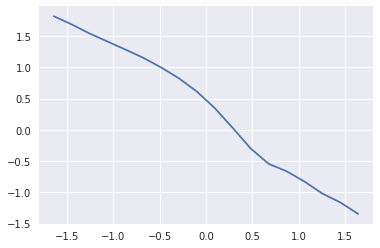

In [135]:
plt.plot(x_np[:emu.n_bins, -1:], emu.y[:emu.n_bins])

In [136]:
def n_layer_fc(x, hidden_sizes, is_training=False):
    initializer = tf.variance_scaling_initializer(scale=2.0)
    #flattened_inputs = tf.layers.flatten(inputs)
    fc1_output = tf.layers.dense(x, hidden_sizes[0], activation=tf.nn.relu)#,
                                 #kernel_regularizer = tf.nn.l2_loss)
    fc2_output = tf.layers.dense(fc1_output, hidden_sizes[1], activation=tf.nn.relu)#,
    #for size in hidden_sizes[1:]:
    #    fc_output = tf.layers.dense(fc_output, size, activation=tf.nn.relu)#,
                                 #kernel_regularizer = tf.nn.l2_loss)
    pred = tf.layers.dense(fc2_output, 1)[0]#,
                              #kernel_regularizer = tf.nn.l2_loss)
    return pred

In [137]:
def optimizer_init_fn(learning_rate = 1e-4):
    return tf.train.AdamOptimizer(learning_rate)

In [138]:
def check_accuracy(sess, val_data,batch_size, x, preds, is_training=None):
    val_x, val_y = val_data
    perc_accs = []
    for idx in xrange(0, val_x.shape[0], batch_size):
        feed_dict = {x: val_x[idx:idx+batch_size], is_training: 0}
        y_pred = sess.run(preds, feed_dict=feed_dict)
        print 'test',y_pred[0], val_y[idx]#[idx:idx+batch_size]
        #print
        perc_acc = (val_y[idx:idx+batch_size]-y_pred)/val_y[idx:idx+batch_size]
        #print perc_acc
        #perc_acc = emu._y_std*(val_y[idx:idx+batch_size]-y_pred)/(emu._y_std*val_y[idx:idx+batch_size] + emu._y_mean)
        perc_accs.append(np.abs(perc_acc).mean())
    acc = np.mean(np.array(np.abs(perc_accs)) ) 
    print 'Got %.2f %% accuracy'%(100*acc)

In [139]:
from sklearn.model_selection import train_test_split

In [140]:
x_train, x_test, y_train, y_test = train_test_split(x_np, y_np, test_size = 0.3, shuffle = True)

In [141]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((14049, 7), (6021, 7), (14049,), (6021,))

In [142]:
x_train[:10, :], y_train[:10]

(array([[-0.43026484, -0.77265603, -0.36982937, -0.34651776,  1.70969356,
          0.31461534,  1.25284441],
        [ 0.33535712,  0.95360149, -0.97159543,  1.10319141,  1.3883302 ,
         -0.60599536,  0.28911794],
        [ 0.45230176,  1.14214063,  0.15605416,  0.87609671, -1.37192046,
         -0.44445424,  1.63833499],
        [-0.89621615, -0.43882066,  1.13370341,  0.88665926, -1.56821267,
          0.64985659,  1.4455897 ],
        [ 0.24216686,  0.5056048 ,  1.43899822,  0.24762535, -1.57689816,
         -0.84917554,  0.28911794],
        [-0.79388959, -1.66864941, -1.33336095,  1.90594475,  1.04612165,
          0.5282665 , -0.48186323],
        [-1.01681532, -1.64270365, -0.83394806, -1.38692834,  1.58462241,
         -0.46182425, -0.48186323],
        [ 2.00912732,  1.65240713, -0.29041743, -1.13870856,  0.4989354 ,
         -1.32163989, -1.06009911],
        [ 0.96393458,  0.50387508,  0.02899505, -0.43629938, -1.46224961,
         -1.67425116, -0.28911794],
        [-

In [143]:
device = '/device:GPU:0'#'/cpu:0'
def train_part(model_init_fn, optimizer_init_fn,num_params, train_data, val_data, hidden_size,\
               num_epochs=1, batch_size = 100, print_every=10):
    tf.reset_default_graph()    
    with tf.device(device):
        # Construct the computational graph we will use to train the model. We
        # use the model_init_fn to construct the model, declare placeholders for
        # the data and labels
        x = tf.placeholder(tf.float32, [None,num_params])
        y = tf.placeholder(tf.int32, [None])
        
        is_training = tf.placeholder(tf.bool, name='is_training')
        
        preds = model_init_fn(x,hidden_size, is_training)

        # Compute the loss like we did in Part II
        loss = tf.losses.mean_squared_error(labels=y, predictions=preds)#weights?
        loss = tf.reduce_mean(loss)

        # Use the optimizer_fn to construct an Optimizer, then use the optimizer
        # to set up the training step. Asking TensorFlow to evaluate the
        # train_op returned by optimizer.minimize(loss) will cause us to make a
        # single update step using the current minibatch of data.
        
        # Note that we use tf.control_dependencies to force the model to run
        # the tf.GraphKeys.UPDATE_OPS at each training step. tf.GraphKeys.UPDATE_OPS
        # holds the operators that update the states of the network.
        # For example, the tf.layers.batch_normalization function adds the running mean
        # and variance update operators to tf.GraphKeys.UPDATE_OPS.
        optimizer = optimizer_init_fn()
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss)

    # Now we can run the computational graph many times to train the model.
    # When we call sess.run we ask it to evaluate train_op, which causes the
    # model to update.
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        t = 0
        train_x, train_y = train_data
        
        for epoch in range(num_epochs):
            #print('Starting epoch %d' % epoch)
            for idx in xrange(0, train_x.shape[0], batch_size):
                feed_dict = {x: train_x[idx:idx+batch_size],\
                             y: train_y[idx:idx+batch_size],\
                             is_training:1}
                loss_np, _, preds_np = sess.run([loss, train_op, preds], feed_dict=feed_dict)
                #print loss_np
                #print 'train', preds_np[0], train_y[idx]#[idx:idx+batch_size]
                #print
                if t % print_every == 0:
                    print('Iteration %d, loss = %e' % (t, loss_np))
                    check_accuracy(sess, train_data, batch_size, x, preds, is_training=is_training)
                    #print
                t += 1

In [ ]:
train_part(n_layer_fc, optimizer_init_fn, x_np.shape[1],\
           (x_train, y_train), (x_test, y_test), [200, 100], num_epochs= int(1e3), batch_size = 100, print_every = int(1e1))

Iteration 0, loss = 2.857891e+00
test 0.036384016 -0.47282158843601785
test 0.12901734 0.4452373028316865
test -0.075384565 3.7389186150087297
test 0.42039564 3.0094638964543603
test 0.2416002 0.23370367104946665
test 0.1522925 4.121747342548113
test 0.19256897 0.5678254671728502
test -0.05294268 1.0512887935566586
test 0.097030625 2.7849124238432075
test 0.10267619 0.2222134133325988
test -0.061651155 3.841618282566646
test -0.047603786 1.1007365357449572
test -0.11782636 0.21606518681890075
test 0.02169748 -0.051761083450301504
test -0.08032957 3.219770554510456
test 0.12953971 0.8111320799704451
test 0.34783378 3.2145260250679932
test 0.13994946 -0.4674957445659649
test 0.43369558 4.603326760110318
test 0.024865305 1.8847670300265542
test 0.035485964 -0.21455873287837424
test -0.083390996 4.531383698933064
test 0.16586311 2.0080575195257393
test 0.313342 3.3298328260013967
test 0.3433264 1.2519821151469734
test 0.40475795 4.928532210295009
test 0.13802715 3.0505149453397946
test -0.

test 0.32431835 4.121747342548113
test 0.4050742 0.5678254671728502
test 0.12739822 1.0512887935566586
test 0.32453457 2.7849124238432075
test 0.2408641 0.2222134133325988
test 0.18063913 3.841618282566646
test 0.1384602 1.1007365357449572
test -0.0012598096 0.21606518681890075
test 0.22005752 -0.051761083450301504
test 0.17826328 3.219770554510456
test 0.35218355 0.8111320799704451
test 0.5047699 3.2145260250679932
test 0.33275822 -0.4674957445659649
test 0.6357251 4.603326760110318
test 0.20318624 1.8847670300265542
test 0.20617332 -0.21455873287837424
test 0.14681731 4.531383698933064
test 0.31479877 2.0080575195257393
test 0.46948728 3.3298328260013967
test 0.50971514 1.2519821151469734
test 0.6170443 4.928532210295009
test 0.25626937 3.0505149453397946
test 0.03182366 2.624146641178021
test 0.34110582 0.4746894750699735
test 0.09339554 1.4667533634760235
test 0.33361515 2.475121688768837
test 0.20867714 -1.0225647997198277
test 0.259816 0.07728093863230279
test 0.2710062 3.3470156

Iteration 40, loss = 1.863638e+00
test 0.31888914 -0.47282158843601785
test 0.44096255 0.4452373028316865
test 0.32815897 3.7389186150087297
test 0.74912703 3.0094638964543603
test 0.6620897 0.23370367104946665
test 0.49402493 4.121747342548113
test 0.57690316 0.5678254671728502
test 0.24820997 1.0512887935566586
test 0.48401037 2.7849124238432075
test 0.35486096 0.2222134133325988
test 0.38903278 3.841618282566646
test 0.28532362 1.1007365357449572
test 0.0960142 0.21606518681890075
test 0.3591355 -0.051761083450301504
test 0.38997635 3.219770554510456
test 0.5497242 0.8111320799704451
test 0.6784271 3.2145260250679932
test 0.48005462 -0.4674957445659649
test 0.869372 4.603326760110318
test 0.36387378 1.8847670300265542
test 0.36024773 -0.21455873287837424
test 0.3936568 4.531383698933064
test 0.468421 2.0080575195257393
test 0.6836643 3.3298328260013967
test 0.6950304 1.2519821151469734
test 0.84419346 4.928532210295009
test 0.38017118 3.0505149453397946
test 0.20005856 2.62414664117

test 0.8484669 0.23370367104946665
test 0.6246871 4.121747342548113
test 0.7109332 0.5678254671728502
test 0.3462801 1.0512887935566586
test 0.60840243 2.7849124238432075
test 0.44455928 0.2222134133325988
test 0.57884914 3.841618282566646
test 0.37785962 1.1007365357449572
test 0.18004681 0.21606518681890075
test 0.45519757 -0.051761083450301504
test 0.5554998 3.219770554510456
test 0.71452 0.8111320799704451
test 0.85717183 3.2145260250679932
test 0.58040285 -0.4674957445659649
test 1.0959044 4.603326760110318
test 0.49650016 1.8847670300265542
test 0.47090703 -0.21455873287837424
test 0.56905425 4.531383698933064
test 0.5879556 2.0080575195257393
test 0.8740831 3.3298328260013967
test 0.86002094 1.2519821151469734
test 1.0643991 4.928532210295009
test 0.51146173 3.0505149453397946
test 0.31473628 2.624146641178021
test 0.6453514 0.4746894750699735
test 0.2993646 1.4667533634760235
test 0.6607271 2.475121688768837
test 0.4906855 -1.0225647997198277
test 0.54031634 0.07728093863230279

test 0.74351716 3.841618282566646
test 0.48340985 1.1007365357449572
test 0.26944357 0.21606518681890075
test 0.5985292 -0.051761083450301504
test 0.694152 3.219770554510456
test 0.8710817 0.8111320799704451
test 0.97832763 3.2145260250679932
test 0.73216933 -0.4674957445659649
test 1.2416157 4.603326760110318
test 0.6228769 1.8847670300265542
test 0.60361713 -0.21455873287837424
test 0.6911844 4.531383698933064
test 0.6833469 2.0080575195257393
test 1.0119567 3.3298328260013967
test 1.0021548 1.2519821151469734
test 1.220975 4.928532210295009
test 0.62205493 3.0505149453397946
test 0.39442664 2.624146641178021
test 0.7870791 0.4746894750699735
test 0.3948213 1.4667533634760235
test 0.75702643 2.475121688768837
test 0.60515004 -1.0225647997198277
test 0.64441794 0.07728093863230279
test 0.6663599 3.3470156513689133
test 0.69213665 -0.78897496890459
test 0.7286409 1.620475538585597
test 0.62589145 -0.11740202240620712
test 0.68858254 0.8848669662342429
test 1.4288981 3.9432479316335396


test 0.7206084 -0.051761083450301504
test 0.85229874 3.219770554510456
test 0.9936788 0.8111320799704451
test 1.1005963 3.2145260250679932
test 0.8580146 -0.4674957445659649
test 1.3824933 4.603326760110318
test 0.7360292 1.8847670300265542
test 0.71021014 -0.21455873287837424
test 0.8272085 4.531383698933064
test 0.77986646 2.0080575195257393
test 1.1487824 3.3298328260013967
test 1.1372449 1.2519821151469734
test 1.3673894 4.928532210295009
test 0.7191837 3.0505149453397946
test 0.4766334 2.624146641178021
test 0.90961146 0.4746894750699735
test 0.48943704 1.4667533634760235
test 0.8635336 2.475121688768837
test 0.69487786 -1.0225647997198277
test 0.7422254 0.07728093863230279
test 0.7730272 3.3470156513689133
test 0.78610516 -0.78897496890459
test 0.85573727 1.620475538585597
test 0.72870123 -0.11740202240620712
test 0.8007975 0.8848669662342429
test 1.571984 3.9432479316335396
test 0.77923375 0.8069306805002924
test 1.3875135 -0.07256928706146204
test 0.82828707 3.4288483919973594


test 1.1945553 3.2145260250679932
test 0.95430595 -0.4674957445659649
test 1.5069534 4.603326760110318
test 0.8394259 1.8847670300265542
test 0.79838675 -0.21455873287837424
test 0.96109176 4.531383698933064
test 0.8698101 2.0080575195257393
test 1.2542301 3.3298328260013967
test 1.2315315 1.2519821151469734
test 1.4802495 4.928532210295009
test 0.7962772 3.0505149453397946
test 0.56161904 2.624146641178021
test 1.0168091 0.4746894750699735
test 0.55928475 1.4667533634760235
test 0.9685587 2.475121688768837
test 0.7848946 -1.0225647997198277
test 0.8314235 0.07728093863230279
test 0.8448913 3.3470156513689133
test 0.8693145 -0.78897496890459
test 0.9787065 1.620475538585597
test 0.803567 -0.11740202240620712
test 0.88165593 0.8848669662342429
test 1.6797682 3.9432479316335396
test 0.87414116 0.8069306805002924
test 1.4839137 -0.07256928706146204
test 0.926971 3.4288483919973594
test 1.2332127 4.602138015133276
test 1.3636618 2.552593656072642
test 1.3947808 -0.2141655813202128
test 1.0

test 1.3545699 3.0094638964543603
test 1.3242624 0.23370367104946665
test 1.009367 4.121747342548113
test 1.1980606 0.5678254671728502
test 0.7360133 1.0512887935566586
test 1.0961316 2.7849124238432075
test 0.7768634 0.2222134133325988
test 1.1591042 3.841618282566646
test 0.7639445 1.1007365357449572
test 0.44041744 0.21606518681890075
test 0.9033491 -0.051761083450301504
test 1.1177723 3.219770554510456
test 1.1423723 0.8111320799704451
test 1.2627633 3.2145260250679932
test 1.0331198 -0.4674957445659649
test 1.600142 4.603326760110318
test 0.9194961 1.8847670300265542
test 0.87036604 -0.21455873287837424
test 1.0722436 4.531383698933064
test 0.93313307 2.0080575195257393
test 1.3347936 3.3298328260013967
test 1.3034432 1.2519821151469734
test 1.560471 4.928532210295009
test 0.8530056 3.0505149453397946
test 0.6371255 2.624146641178021
test 1.1116685 0.4746894750699735
test 0.60587806 1.4667533634760235
test 1.0526488 2.475121688768837
test 0.87044495 -1.0225647997198277
test 0.9055

Iteration 160, loss = 1.579154e+00
test 0.93742025 -0.47282158843601785
test 1.0656228 0.4452373028316865
test 1.0772041 3.7389186150087297
test 1.421613 3.0094638964543603
test 1.4241953 0.23370367104946665
test 1.0696931 4.121747342548113
test 1.3046789 0.5678254671728502
test 0.82765776 1.0512887935566586
test 1.1964772 2.7849124238432075
test 0.86435825 0.2222134133325988
test 1.2677019 3.841618282566646
test 0.87502396 1.1007365357449572
test 0.51064 0.21606518681890075
test 1.0291679 -0.051761083450301504
test 1.2505699 3.219770554510456
test 1.2243465 0.8111320799704451
test 1.3228656 3.2145260250679932
test 1.1349831 -0.4674957445659649
test 1.6595418 4.603326760110318
test 1.0077311 1.8847670300265542
test 0.95534027 -0.21455873287837424
test 1.1648703 4.531383698933064
test 0.99939007 2.0080575195257393
test 1.399831 3.3298328260013967
test 1.3815036 1.2519821151469734
test 1.6291163 4.928532210295009
test 0.90140885 3.0505149453397946
test 0.7088824 2.624146641178021
test 1.

test 1.1493863 3.7389186150087297
test 1.4522376 3.0094638964543603
test 1.5019405 0.23370367104946665
test 1.106047 4.121747342548113
test 1.374464 0.5678254671728502
test 0.88792765 1.0512887935566586
test 1.2601533 2.7849124238432075
test 0.9298245 0.2222134133325988
test 1.3433082 3.841618282566646
test 0.95516384 1.1007365357449572
test 0.5660883 0.21606518681890075
test 1.1209168 -0.051761083450301504
test 1.34534 3.219770554510456
test 1.2808309 0.8111320799704451
test 1.3464326 3.2145260250679932
test 1.2072743 -0.4674957445659649
test 1.6613624 4.603326760110318
test 1.0709404 1.8847670300265542
test 1.0257535 -0.21455873287837424
test 1.2318115 4.531383698933064
test 1.0566344 2.0080575195257393
test 1.4309909 3.3298328260013967
test 1.4163718 1.2519821151469734
test 1.6401104 4.928532210295009
test 0.9232327 3.0505149453397946
test 0.768214 2.624146641178021
test 1.2445824 0.4746894750699735
test 0.7046306 1.4667533634760235
test 1.1638483 2.475121688768837
test 1.0375395 -1

Iteration 200, loss = 2.168039e+00
test 1.0089169 -0.47282158843601785
test 1.1023219 0.4452373028316865
test 1.1884562 3.7389186150087297
test 1.4391246 3.0094638964543603
test 1.5175259 0.23370367104946665
test 1.1134174 4.121747342548113
test 1.3966838 0.5678254671728502
test 0.91655177 1.0512887935566586
test 1.2888262 2.7849124238432075
test 0.9595551 0.2222134133325988
test 1.3738542 3.841618282566646
test 0.9851983 1.1007365357449572
test 0.59023005 0.21606518681890075
test 1.158365 -0.051761083450301504
test 1.3936238 3.219770554510456
test 1.2919585 0.8111320799704451
test 1.3329777 3.2145260250679932
test 1.2301259 -0.4674957445659649
test 1.6152033 4.603326760110318
test 1.0862873 1.8847670300265542
test 1.039557 -0.21455873287837424
test 1.2446913 4.531383698933064
test 1.0840571 2.0080575195257393
test 1.4072669 3.3298328260013967
test 1.4101238 1.2519821151469734
test 1.6268486 4.928532210295009
test 0.91763484 3.0505149453397946
test 0.7833287 2.624146641178021
test 1.24

test 1.4560034 3.0094638964543603
test 1.5600533 0.23370367104946665
test 1.1358583 4.121747342548113
test 1.4166862 0.5678254671728502
test 0.9524442 1.0512887935566586
test 1.3247015 2.7849124238432075
test 0.98274606 0.2222134133325988
test 1.4088275 3.841618282566646
test 1.01229 1.1007365357449572
test 0.61985445 0.21606518681890075
test 1.1947329 -0.051761083450301504
test 1.4356661 3.219770554510456
test 1.326413 0.8111320799704451
test 1.3496755 3.2145260250679932
test 1.2599245 -0.4674957445659649
test 1.6237116 4.603326760110318
test 1.1058482 1.8847670300265542
test 1.0784181 -0.21455873287837424
test 1.2630534 4.531383698933064
test 1.1019124 2.0080575195257393
test 1.4109293 3.3298328260013967
test 1.4296938 1.2519821151469734
test 1.6527423 4.928532210295009
test 0.9354038 3.0505149453397946
test 0.7923693 2.624146641178021
test 1.2705168 0.4746894750699735
test 0.7433178 1.4667533634760235
test 1.1730976 2.475121688768837
test 1.094976 -1.0225647997198277
test 1.1039044 

test 1.3004514 0.8084648749523107
test 1.0450528 -0.8061754623486137
test 1.3156614 -0.04781361783409421
test 1.2012618 0.6618841961142318
test 1.3335207 4.116799281277677
test 1.6393738 0.2446209896485949
test 0.99896675 2.908844521204413
test 1.286009 1.9248617440319002
test 1.2550408 0.764827397313637
test 1.2497379 3.6194189056738493
test 0.8633419 0.8347884940863526
test 1.0106514 0.6944230684340778
test 1.0226315 1.9978827701303117
test 1.1156043 0.31642570237616785
test 1.0234652 2.6454709783632295
test 1.0372422 0.9837660983660724
test 1.1267258 2.408088828718518
test 1.2581195 1.687161553427222
test 1.2291197 0.2809084621841651
test 1.4485055 3.216779170307968
test 1.09481 2.645329675135277
test 1.5018579 1.087804121110757
test 1.3662871 0.6557178481552516
test 0.8305956 2.618510898683644
test 1.3421812 1.5974845127822441
test 0.87377423 2.3237692331888544
test 1.2781619 0.31741986395315713
test 1.572597 4.394316816061698
test 1.0548409 0.8923285505251674
test 1.1555704 3.8198

test 1.2651212 1.9248617440319002
test 1.2045131 0.764827397313637
test 1.229185 3.6194189056738493
test 0.85393846 0.8347884940863526
test 1.0046468 0.6944230684340778
test 0.9979717 1.9978827701303117
test 1.090404 0.31642570237616785
test 1.0032898 2.6454709783632295
test 1.0134445 0.9837660983660724
test 1.1083678 2.408088828718518
test 1.2416968 1.687161553427222
test 1.239405 0.2809084621841651
test 1.4242253 3.216779170307968
test 1.0724784 2.645329675135277
test 1.4372275 1.087804121110757
test 1.3389157 0.6557178481552516
test 0.8306174 2.618510898683644
test 1.3220879 1.5974845127822441
test 0.8666384 2.3237692331888544
test 1.275263 0.31741986395315713
test 1.5481027 4.394316816061698
test 1.0296448 0.8923285505251674
test 1.1208665 3.819846270301505
test 1.2631428 2.0383446137271823
test 0.8592384 2.1856542997812447
test 0.80168086 1.200200403752343
test 1.0803045 1.5742305641219958
test 1.3546158 2.819124492830198
test 1.3223165 2.746075107582508
test 1.5766121 4.462326493

test 1.3012375 4.116799281277677
test 1.5819559 0.2446209896485949
test 1.0006785 2.908844521204413
test 1.2682942 1.9248617440319002
test 1.1840473 0.764827397313637
test 1.2399288 3.6194189056738493
test 0.8659271 0.8347884940863526
test 1.0176616 0.6944230684340778
test 1.0068697 1.9978827701303117
test 1.0832781 0.31642570237616785
test 1.0136094 2.6454709783632295
test 1.0115881 0.9837660983660724
test 1.1217813 2.408088828718518
test 1.262451 1.687161553427222
test 1.2598906 0.2809084621841651
test 1.4339734 3.216779170307968
test 1.0797764 2.645329675135277
test 1.4182944 1.087804121110757
test 1.3579357 0.6557178481552516
test 0.8452027 2.618510898683644
test 1.3420303 1.5974845127822441
test 0.8790851 2.3237692331888544
test 1.2832258 0.31741986395315713
test 1.554017 4.394316816061698
test 1.0310875 0.8923285505251674
test 1.1226764 3.819846270301505
test 1.2669063 2.0383446137271823
test 0.8561785 2.1856542997812447
test 0.8085903 1.200200403752343
test 1.0948504 1.574230564

test 1.2819762 0.8084648749523107
test 1.0245671 -0.8061754623486137
test 1.3224772 -0.04781361783409421
test 1.2173202 0.6618841961142318
test 1.2919625 4.116799281277677
test 1.5710632 0.2446209896485949
test 0.98670727 2.908844521204413
test 1.2626942 1.9248617440319002
test 1.1745725 0.764827397313637
test 1.234308 3.6194189056738493
test 0.8868771 0.8347884940863526
test 1.031465 0.6944230684340778
test 1.0012299 1.9978827701303117
test 1.0880978 0.31642570237616785
test 1.0264913 2.6454709783632295
test 1.0141467 0.9837660983660724
test 1.1193548 2.408088828718518
test 1.2642227 1.687161553427222
test 1.2800392 0.2809084621841651
test 1.4184507 3.216779170307968
test 1.0639576 2.645329675135277
test 1.4111682 1.087804121110757
test 1.3945367 0.6557178481552516
test 0.8451725 2.618510898683644
test 1.3259897 1.5974845127822441
test 0.8779731 2.3237692331888544
test 1.2864151 0.31741986395315713
test 1.5322591 4.394316816061698
test 1.0219721 0.8923285505251674
test 1.1129628 3.819

test 1.2831447 4.116799281277677
test 1.5641878 0.2446209896485949
test 0.983311 2.908844521204413
test 1.2674032 1.9248617440319002
test 1.1528684 0.764827397313637
test 1.2408806 3.6194189056738493
test 0.91103256 0.8347884940863526
test 1.0551716 0.6944230684340778
test 1.001144 1.9978827701303117
test 1.0856913 0.31642570237616785
test 1.0329776 2.6454709783632295
test 1.0171918 0.9837660983660724
test 1.1154524 2.408088828718518
test 1.2767888 1.687161553427222
test 1.2875137 0.2809084621841651
test 1.411453 3.216779170307968
test 1.0585574 2.645329675135277
test 1.3971082 1.087804121110757
test 1.4350364 0.6557178481552516
test 0.85277575 2.618510898683644
test 1.334526 1.5974845127822441
test 0.88128626 2.3237692331888544
test 1.2802068 0.31741986395315713
test 1.5284988 4.394316816061698
test 1.0286756 0.8923285505251674
test 1.1020365 3.819846270301505
test 1.2560841 2.0383446137271823
test 0.8394021 2.1856542997812447
test 0.8359759 1.200200403752343
test 1.1025841 1.57423056

test 1.5103091 -0.19202679656528265
test 1.3529619 3.7587835702578745
test 1.1024787 2.89268890628651
test 1.4006517 -0.11215886248453977
test 1.2014831 0.4924215237845777
test 1.3248433 2.220211661180018
test 1.2327011 -0.5802818653020831
test 1.2128407 3.5072794580965354
test 1.2902651 3.141253372473728
test 1.2131302 0.3512778763866091
test 1.1971493 3.9660587397563867
test 1.0439758 1.3647163803558346
test 1.1255383 0.1520874065831168
test 1.2904457 0.4904677064904044
Got 581.70 % accuracy
Iteration 370, loss = 1.826101e+00
test 1.1587038 -0.47282158843601785
test 1.1947411 0.4452373028316865
test 1.2883507 3.7389186150087297
test 1.4217108 3.0094638964543603
test 1.5934427 0.23370367104946665
test 1.1900533 4.121747342548113
test 1.4807754 0.5678254671728502
test 1.0784737 1.0512887935566586
test 1.4290018 2.7849124238432075
test 1.111419 0.2222134133325988
test 1.4242942 3.841618282566646
test 1.1168565 1.1007365357449572
test 0.7317381 0.21606518681890075
test 1.355777 -0.051761

test 1.287765 1.687161553427222
test 1.3349433 0.2809084621841651
test 1.4380441 3.216779170307968
test 1.0643007 2.645329675135277
test 1.4171237 1.087804121110757
test 1.4505178 0.6557178481552516
test 0.8842899 2.618510898683644
test 1.3317435 1.5974845127822441
test 0.9207592 2.3237692331888544
test 1.3080237 0.31741986395315713
test 1.5377951 4.394316816061698
test 1.0409565 0.8923285505251674
test 1.1321324 3.819846270301505
test 1.2513436 2.0383446137271823
test 0.86172533 2.1856542997812447
test 0.8528734 1.200200403752343
test 1.1483012 1.5742305641219958
test 1.3201885 2.819124492830198
test 1.3964313 2.746075107582508
test 1.5089194 4.4623264936881135
test 1.5121424 3.775414234351853
test 1.624683 4.321586159977588
test 1.2836325 0.5832392167902761
test 1.3397032 1.9167138357015632
test 1.3910952 2.4227585560627296
test 1.5343254 1.9262847654288524
test 1.0988797 2.513838583039329
test 1.6463754 1.3905404094903973
test 1.4636035 0.022088682485681632
test 1.1672074 1.12971645

Iteration 440, loss = 2.008539e+00
test 1.199068 -0.47282158843601785
test 1.2444025 0.4452373028316865
test 1.2527318 3.7389186150087297
test 1.4032632 3.0094638964543603
test 1.5190551 0.23370367104946665
test 1.2103006 4.121747342548113
test 1.4807049 0.5678254671728502
test 1.0903525 1.0512887935566586
test 1.4400342 2.7849124238432075
test 1.1383548 0.2222134133325988
test 1.3822457 3.841618282566646
test 1.1177493 1.1007365357449572
test 0.7332052 0.21606518681890075
test 1.375145 -0.051761083450301504
test 1.4620743 3.219770554510456
test 1.341851 0.8111320799704451
test 1.3324698 3.2145260250679932
test 1.3860828 -0.4674957445659649
test 1.4715023 4.603326760110318
test 1.1261121 1.8847670300265542
test 1.1892477 -0.21455873287837424
test 1.2658165 4.531383698933064
test 1.2262554 2.0080575195257393
test 1.4431151 3.3298328260013967
test 1.5571231 1.2519821151469734
test 1.6074024 4.928532210295009
test 0.94006723 3.0505149453397946
test 0.8397376 2.624146641178021
test 1.37898

test 1.0669765 1.3647163803558346
test 1.175951 0.1520874065831168
test 1.3203646 0.4904677064904044
Got 586.00 % accuracy
Iteration 470, loss = 1.465719e+00
test 1.197717 -0.47282158843601785
test 1.2358061 0.4452373028316865
test 1.2586567 3.7389186150087297
test 1.380669 3.0094638964543603
test 1.5306653 0.23370367104946665
test 1.1996965 4.121747342548113
test 1.4810431 0.5678254671728502
test 1.1141877 1.0512887935566586
test 1.453551 2.7849124238432075
test 1.1593612 0.2222134133325988
test 1.3719714 3.841618282566646
test 1.133965 1.1007365357449572
test 0.7674513 0.21606518681890075
test 1.404473 -0.051761083450301504
test 1.4642348 3.219770554510456
test 1.3518417 0.8111320799704451
test 1.3069761 3.2145260250679932
test 1.3978405 -0.4674957445659649
test 1.4080925 4.603326760110318
test 1.1325327 1.8847670300265542
test 1.2093724 -0.21455873287837424
test 1.2588266 4.531383698933064
test 1.2350817 2.0080575195257393
test 1.4070919 3.3298328260013967
test 1.5243239 1.251982115

test 1.389651 4.602138015133276
test 1.6289198 2.552593656072642
test 1.4846531 -0.2141655813202128
test 1.1710194 4.158411692592668
test 1.33696 0.4335824616400028
test 1.3891821 3.867849060577462
test 1.0567992 1.7611782850354931
test 1.6713213 0.20091449353109359
test 1.1537344 -0.8349345682069549
test 1.2840114 4.54837573345422
test 1.0432954 3.3861685109684023
test 1.1414369 1.5299451442246272
test 1.0593058 3.1639886840968794
test 1.172299 -0.004727488139501856
test 1.4024516 -0.4552713925509648
test 1.5170888 1.1693860640562799
test 1.2007637 0.753053721557467
test 1.5423907 0.04099791250877294
test 1.197713 1.2980012503885199
test 1.288054 -0.1103606710556626
test 1.3584305 2.4257195623569268
test 0.9119407 -0.3082899028314352
test 1.190559 2.223778789465802
test 0.96559435 0.994164334654764
test 1.117064 -0.344363593352099
test 1.5353111 0.3569779393629464
test 1.1417218 3.607517209101478
test 1.3856514 -0.6630275191204036
test 1.3206264 0.8084648749523107
test 1.038113 -0.806

test 1.1650213 -0.8349345682069549
test 1.3011994 4.54837573345422
test 1.0649312 3.3861685109684023
test 1.1650021 1.5299451442246272
test 1.0761555 3.1639886840968794
test 1.1903749 -0.004727488139501856
test 1.4087704 -0.4552713925509648
test 1.5531542 1.1693860640562799
test 1.2055902 0.753053721557467
test 1.574744 0.04099791250877294
test 1.2143422 1.2980012503885199
test 1.3074393 -0.1103606710556626
test 1.3815948 2.4257195623569268
test 0.92789227 -0.3082899028314352
test 1.2000927 2.223778789465802
test 0.9776364 0.994164334654764
test 1.1655699 -0.344363593352099
test 1.5548524 0.3569779393629464
test 1.1734754 3.607517209101478
test 1.4059777 -0.6630275191204036
test 1.3427943 0.8084648749523107
test 1.0668647 -0.8061754623486137
test 1.3189803 -0.04781361783409421
test 1.2709109 0.6618841961142318
test 1.3208216 4.116799281277677
test 1.5153292 0.2446209896485949
test 1.0081892 2.908844521204413
test 1.2514551 1.9248617440319002
test 1.1272718 0.764827397313637
test 1.2713

test 1.3529319 0.4335824616400028
test 1.4480965 3.867849060577462
test 1.078728 1.7611782850354931
test 1.6909664 0.20091449353109359
test 1.1535211 -0.8349345682069549
test 1.3035623 4.54837573345422
test 1.0737056 3.3861685109684023
test 1.1761193 1.5299451442246272
test 1.0844114 3.1639886840968794
test 1.1986115 -0.004727488139501856
test 1.4077381 -0.4552713925509648
test 1.5665481 1.1693860640562799
test 1.2090716 0.753053721557467
test 1.5868553 0.04099791250877294
test 1.2214649 1.2980012503885199
test 1.3121446 -0.1103606710556626
test 1.3962126 2.4257195623569268
test 0.9282937 -0.3082899028314352
test 1.2107843 2.223778789465802
test 0.98132384 0.994164334654764
test 1.1726123 -0.344363593352099
test 1.5662442 0.3569779393629464
test 1.1864347 3.607517209101478
test 1.4145844 -0.6630275191204036
test 1.354293 0.8084648749523107
test 1.0765283 -0.8061754623486137
test 1.3118303 -0.04781361783409421
test 1.2769114 0.6618841961142318
test 1.3212512 4.116799281277677
test 1.516

test 1.0262307 2.4443179439300855
test 1.1856956 1.0713732317591729
test 1.127904 0.23319718226310737
test 1.5734738 -0.4397853889060088
test 1.3662716 0.26978240471503634
test 1.12839 4.227708403302667
test 1.1930227 3.5190795671538937
test 1.3508852 3.996841031049736
test 1.4949131 -0.19202679656528265
test 1.3186862 3.7587835702578745
test 1.0920559 2.89268890628651
test 1.3963047 -0.11215886248453977
test 1.1850115 0.4924215237845777
test 1.3700726 2.220211661180018
test 1.2964828 -0.5802818653020831
test 1.2150319 3.5072794580965354
test 1.211898 3.141253372473728
test 1.2336494 0.3512778763866091
test 1.2312863 3.9660587397563867
test 1.0882016 1.3647163803558346
test 1.1831074 0.1520874065831168
test 1.3421205 0.4904677064904044
Got 593.13 % accuracy
Iteration 580, loss = 1.941350e+00
test 1.2428093 -0.47282158843601785
test 1.2785981 0.4452373028316865
test 1.2533761 3.7389186150087297
test 1.3732116 3.0094638964543603
test 1.4922314 0.23370367104946665
test 1.2317764 4.1217473

test 1.1286911 0.23319718226310737
test 1.5661508 -0.4397853889060088
test 1.3539747 0.26978240471503634
test 1.0966839 4.227708403302667
test 1.1790763 3.5190795671538937
test 1.3289822 3.996841031049736
test 1.4776051 -0.19202679656528265
test 1.2787187 3.7587835702578745
test 1.077067 2.89268890628651
test 1.3889539 -0.11215886248453977
test 1.164958 0.4924215237845777
test 1.3700558 2.220211661180018
test 1.2896262 -0.5802818653020831
test 1.2001125 3.5072794580965354
test 1.1759435 3.141253372473728
test 1.22165 0.3512778763866091
test 1.2071465 3.9660587397563867
test 1.0751575 1.3647163803558346
test 1.175993 0.1520874065831168
test 1.3313313 0.4904677064904044
Got 587.07 % accuracy
Iteration 600, loss = 1.932705e+00
test 1.2337621 -0.47282158843601785
test 1.2692709 0.4452373028316865
test 1.2427245 3.7389186150087297
test 1.3544225 3.0094638964543603
test 1.4938225 0.23370367104946665
test 1.2122782 4.121747342548113
test 1.4632497 0.5678254671728502
test 1.1315268 1.051288793

test 1.0600145 2.645329675135277
test 1.3230051 1.087804121110757
test 1.5002172 0.6557178481552516
test 0.9144077 2.618510898683644
test 1.3150069 1.5974845127822441
test 0.9556004 2.3237692331888544
test 1.2758421 0.31741986395315713
test 1.49057 4.394316816061698
test 1.0217721 0.8923285505251674
test 1.104526 3.819846270301505
test 1.1929406 2.0383446137271823
test 0.843061 2.1856542997812447
test 0.8800978 1.200200403752343
test 1.1714417 1.5742305641219958
test 1.2533219 2.819124492830198
test 1.4277428 2.746075107582508
test 1.4380912 4.4623264936881135
test 1.4053686 3.775414234351853
test 1.5371953 4.321586159977588
test 1.2463766 0.5832392167902761
test 1.2813671 1.9167138357015632
test 1.3806851 2.4227585560627296
test 1.4497163 1.9262847654288524
test 1.1238084 2.513838583039329
test 1.600982 1.3905404094903973
test 1.5012703 0.022088682485681632
test 1.1428429 1.1297164568297517
test 1.3949914 -0.9682215731969328
test 1.2453697 3.1554637571989694
test 1.0029433 2.444317943

test 1.2167426 0.753053721557467
test 1.5067023 0.04099791250877294
test 1.1990428 1.2980012503885199
test 1.3095374 -0.1103606710556626
test 1.3854444 2.4257195623569268
test 0.9426621 -0.3082899028314352
test 1.2171712 2.223778789465802
test 1.0044025 0.994164334654764
test 1.0925779 -0.344363593352099
test 1.5454905 0.3569779393629464
test 1.163299 3.607517209101478
test 1.4158432 -0.6630275191204036
test 1.3428577 0.8084648749523107
test 1.0391824 -0.8061754623486137
test 1.285908 -0.04781361783409421
test 1.2620072 0.6618841961142318
test 1.3003995 4.116799281277677
test 1.4724296 0.2446209896485949
test 0.99338675 2.908844521204413
test 1.2370164 1.9248617440319002
test 1.0560207 0.764827397313637
test 1.2642248 3.6194189056738493
test 1.022146 0.8347884940863526
test 1.101869 0.6944230684340778
test 0.9956737 1.9978827701303117
test 1.0432138 0.31642570237616785
test 1.1125643 2.6454709783632295
test 1.0129589 0.9837660983660724
test 1.1247822 2.408088828718518
test 1.299198 1.6

test 1.6163784 2.552593656072642
test 1.4763505 -0.2141655813202128
test 1.1901991 4.158411692592668
test 1.3412423 0.4335824616400028
test 1.3701851 3.867849060577462
test 1.0775312 1.7611782850354931
test 1.6624902 0.20091449353109359
test 1.1694598 -0.8349345682069549
test 1.2791716 4.54837573345422
test 1.0716649 3.3861685109684023
test 1.1313753 1.5299451442246272
test 1.0880214 3.1639886840968794
test 1.1821959 -0.004727488139501856
test 1.4292984 -0.4552713925509648
test 1.5105371 1.1693860640562799
test 1.2166077 0.753053721557467
test 1.5296957 0.04099791250877294
test 1.1778836 1.2980012503885199
test 1.3375049 -0.1103606710556626
test 1.3642328 2.4257195623569268
test 0.9526478 -0.3082899028314352
test 1.2050787 2.223778789465802
test 0.9979698 0.994164334654764
test 1.1279895 -0.344363593352099
test 1.5145178 0.3569779393629464
test 1.1645534 3.607517209101478
test 1.3913007 -0.6630275191204036
test 1.3468204 0.8084648749523107
test 1.0656164 -0.8061754623486137
test 1.3013

test 1.4667299 3.775414234351853
test 1.5886754 4.321586159977588
test 1.2676462 0.5832392167902761
test 1.2869308 1.9167138357015632
test 1.38256 2.4227585560627296
test 1.4565957 1.9262847654288524
test 1.1226492 2.513838583039329
test 1.6018965 1.3905404094903973
test 1.5040486 0.022088682485681632
test 1.16837 1.1297164568297517
test 1.4071438 -0.9682215731969328
test 1.2687652 3.1554637571989694
test 1.0439893 2.4443179439300855
test 1.197959 1.0713732317591729
test 1.1536608 0.23319718226310737
test 1.6263156 -0.4397853889060088
test 1.4095355 0.26978240471503634
test 1.1225789 4.227708403302667
test 1.2032061 3.5190795671538937
test 1.3619204 3.996841031049736
test 1.519089 -0.19202679656528265
test 1.3163984 3.7587835702578745
test 1.110214 2.89268890628651
test 1.4346174 -0.11215886248453977
test 1.19309 0.4924215237845777
test 1.4197028 2.220211661180018
test 1.3058162 -0.5802818653020831
test 1.2292871 3.5072794580965354
test 1.2015365 3.141253372473728
test 1.2464427 0.3512

Iteration 720, loss = 1.992812e+00
test 1.2722806 -0.47282158843601785
test 1.2992629 0.4452373028316865
test 1.2521353 3.7389186150087297
test 1.3524343 3.0094638964543603
test 1.4696108 0.23370367104946665
test 1.2426661 4.121747342548113
test 1.4669676 0.5678254671728502
test 1.1464478 1.0512887935566586
test 1.4664074 2.7849124238432075
test 1.1736641 0.2222134133325988
test 1.3476685 3.841618282566646
test 1.1370863 1.1007365357449572
test 0.8254727 0.21606518681890075
test 1.4014981 -0.051761083450301504
test 1.4056582 3.219770554510456
test 1.372223 0.8111320799704451
test 1.3659953 3.2145260250679932
test 1.3978585 -0.4674957445659649
test 1.4229094 4.603326760110318
test 1.1360321 1.8847670300265542
test 1.2616345 -0.21455873287837424
test 1.2942222 4.531383698933064
test 1.2660321 2.0080575195257393
test 1.4331003 3.3298328260013967
test 1.5986794 1.2519821151469734
test 1.6015385 4.928532210295009
test 1.0021943 3.0505149453397946
test 0.88185644 2.624146641178021
test 1.4 0

Iteration 740, loss = 2.028848e+00
test 1.2573711 -0.47282158843601785
test 1.2825116 0.4452373028316865
test 1.2349892 3.7389186150087297
test 1.3284937 3.0094638964543603
test 1.4636525 0.23370367104946665
test 1.2150255 4.121747342548113
test 1.4487082 0.5678254671728502
test 1.1487886 1.0512887935566586
test 1.4529953 2.7849124238432075
test 1.1701832 0.2222134133325988
test 1.3187653 3.841618282566646
test 1.1298262 1.1007365357449572
test 0.84070003 0.21606518681890075
test 1.3997091 -0.051761083450301504
test 1.3817931 3.219770554510456
test 1.3569828 0.8111320799704451
test 1.3401572 3.2145260250679932
test 1.3867468 -0.4674957445659649
test 1.3822852 4.603326760110318
test 1.1276091 1.8847670300265542
test 1.2633861 -0.21455873287837424
test 1.2751414 4.531383698933064
test 1.2604018 2.0080575195257393
test 1.4064468 3.3298328260013967
test 1.5609604 1.2519821151469734
test 1.5473702 4.928532210295009
test 0.9863917 3.0505149453397946
test 0.88260555 2.624146641178021
test 1.3

test 1.1326927 1.5299451442246272
test 1.1097368 3.1639886840968794
test 1.1632324 -0.004727488139501856
test 1.433165 -0.4552713925509648
test 1.5119282 1.1693860640562799
test 1.2252662 0.753053721557467
test 1.4810177 0.04099791250877294
test 1.174632 1.2980012503885199
test 1.3342977 -0.1103606710556626
test 1.3863462 2.4257195623569268
test 0.9650314 -0.3082899028314352
test 1.2251648 2.223778789465802
test 1.0241641 0.994164334654764
test 1.0769811 -0.344363593352099
test 1.509033 0.3569779393629464
test 1.1790204 3.607517209101478
test 1.4026289 -0.6630275191204036
test 1.3492048 0.8084648749523107
test 1.0446837 -0.8061754623486137
test 1.2800244 -0.04781361783409421
test 1.2722386 0.6618841961142318
test 1.2966051 4.116799281277677
test 1.458385 0.2446209896485949
test 0.99870837 2.908844521204413
test 1.2214307 1.9248617440319002
test 1.0377051 0.764827397313637
test 1.2533554 3.6194189056738493
test 1.0567434 0.8347884940863526
test 1.1125407 0.6944230684340778
test 0.996821

test 1.347726 3.867849060577462
test 1.0840752 1.7611782850354931
test 1.646705 0.20091449353109359
test 1.1765544 -0.8349345682069549
test 1.2764962 4.54837573345422
test 1.099334 3.3861685109684023
test 1.1166376 1.5299451442246272
test 1.1072254 3.1639886840968794
test 1.1843431 -0.004727488139501856
test 1.4434221 -0.4552713925509648
test 1.4859188 1.1693860640562799
test 1.2275434 0.753053721557467
test 1.5098765 0.04099791250877294
test 1.1525046 1.2980012503885199
test 1.3657005 -0.1103606710556626
test 1.3588839 2.4257195623569268
test 0.9761155 -0.3082899028314352
test 1.2123175 2.223778789465802
test 1.0147744 0.994164334654764
test 1.1191535 -0.344363593352099
test 1.4821348 0.3569779393629464
test 1.177958 3.607517209101478
test 1.380201 -0.6630275191204036
test 1.3558984 0.8084648749523107
test 1.0753758 -0.8061754623486137
test 1.2968711 -0.04781361783409421
test 1.2749281 0.6618841961142318
test 1.3084211 4.116799281277677
test 1.4695055 0.2446209896485949
test 1.0039556

test 1.5778745 1.2519821151469734
test 1.6153971 4.928532210295009
test 1.0433713 3.0505149453397946
test 0.9034507 2.624146641178021
test 1.4173794 0.4746894750699735
test 0.9691859 1.4667533634760235
test 1.2224501 2.475121688768837
test 1.2900851 -1.0225647997198277
test 1.2215798 0.07728093863230279
test 1.2338927 3.3470156513689133
test 1.2361628 -0.78897496890459
test 1.5229625 1.620475538585597
test 1.3229915 -0.11740202240620712
test 1.3355844 0.8848669662342429
test 1.5377764 3.9432479316335396
test 1.1473261 0.8069306805002924
test 1.496843 -0.07256928706146204
test 1.2868513 3.4288483919973594
test 1.4729792 4.602138015133276
test 1.6538193 2.552593656072642
test 1.5041124 -0.2141655813202128
test 1.2504491 4.158411692592668
test 1.3734837 0.4335824616400028
test 1.4222192 3.867849060577462
test 1.1175646 1.7611782850354931
test 1.6848358 0.20091449353109359
test 1.1919726 -0.8349345682069549
test 1.3182553 4.54837573345422
test 1.1427157 3.3861685109684023
test 1.1590388 1.

Iteration 830, loss = 2.372759e+00
test 1.2958707 -0.47282158843601785
test 1.2824525 0.4452373028316865
test 1.2510369 3.7389186150087297
test 1.3583397 3.0094638964543603
test 1.4687864 0.23370367104946665
test 1.2579566 4.121747342548113
test 1.4716748 0.5678254671728502
test 1.1552162 1.0512887935566586
test 1.4689478 2.7849124238432075
test 1.1721014 0.2222134133325988
test 1.3517703 3.841618282566646
test 1.1329521 1.1007365357449572
test 0.8587195 0.21606518681890075
test 1.3957963 -0.051761083450301504
test 1.3872278 3.219770554510456
test 1.4018904 0.8111320799704451
test 1.3692429 3.2145260250679932
test 1.4057925 -0.4674957445659649
test 1.4124674 4.603326760110318
test 1.1458709 1.8847670300265542
test 1.2898594 -0.21455873287837424
test 1.3130375 4.531383698933064
test 1.2625114 2.0080575195257393
test 1.4081243 3.3298328260013967
test 1.5636798 1.2519821151469734
test 1.5961574 4.928532210295009
test 1.0270575 3.0505149453397946
test 0.900092 2.624146641178021
test 1.4162

test 1.093248 1.3647163803558346
test 1.1857358 0.1520874065831168
test 1.3451567 0.4904677064904044
Got 592.72 % accuracy
Iteration 850, loss = 1.778038e+00
test 1.3020493 -0.47282158843601785
test 1.2969099 0.4452373028316865
test 1.2576114 3.7389186150087297
test 1.3450145 3.0094638964543603
test 1.467806 0.23370367104946665
test 1.2591165 4.121747342548113
test 1.4770205 0.5678254671728502
test 1.153194 1.0512887935566586
test 1.4716254 2.7849124238432075
test 1.1818336 0.2222134133325988
test 1.367183 3.841618282566646
test 1.1458898 1.1007365357449572
test 0.8550358 0.21606518681890075
test 1.3968803 -0.051761083450301504
test 1.3945516 3.219770554510456
test 1.3876202 0.8111320799704451
test 1.3911322 3.2145260250679932
test 1.3970402 -0.4674957445659649
test 1.4297183 4.603326760110318
test 1.1523468 1.8847670300265542
test 1.2850709 -0.21455873287837424
test 1.3273917 4.531383698933064
test 1.2769905 2.0080575195257393
test 1.432582 3.3298328260013967
test 1.5943493 1.25198211

test 1.2259822 3.5072794580965354
test 1.1480024 3.141253372473728
test 1.2478105 0.3512778763866091
test 1.2235925 3.9660587397563867
test 1.1159647 1.3647163803558346
test 1.1969329 0.1520874065831168
test 1.3654609 0.4904677064904044
Got 595.89 % accuracy
Iteration 870, loss = 2.030952e+00
test 1.2884743 -0.47282158843601785
test 1.3084878 0.4452373028316865
test 1.2333146 3.7389186150087297
test 1.3262906 3.0094638964543603
test 1.4449993 0.23370367104946665
test 1.2388842 4.121747342548113
test 1.44173 0.5678254671728502
test 1.1637869 1.0512887935566586
test 1.4637159 2.7849124238432075
test 1.1727791 0.2222134133325988
test 1.3098735 3.841618282566646
test 1.1297839 1.1007365357449572
test 0.8746418 0.21606518681890075
test 1.3962266 -0.051761083450301504
test 1.3581046 3.219770554510456
test 1.3769902 0.8111320799704451
test 1.375764 3.2145260250679932
test 1.3883142 -0.4674957445659649
test 1.403089 4.603326760110318
test 1.1293877 1.8847670300265542
test 1.2861949 -0.21455873

test 1.1314667 3.141253372473728
test 1.2377536 0.3512778763866091
test 1.1972483 3.9660587397563867
test 1.1069099 1.3647163803558346
test 1.1856002 0.1520874065831168
test 1.3561399 0.4904677064904044
Got 587.28 % accuracy
Iteration 890, loss = 1.752852e+00
test 1.2738878 -0.47282158843601785
test 1.2803758 0.4452373028316865
test 1.2330208 3.7389186150087297
test 1.3009821 3.0094638964543603
test 1.4456257 0.23370367104946665
test 1.209723 4.121747342548113
test 1.4396724 0.5678254671728502
test 1.1697377 1.0512887935566586
test 1.4583813 2.7849124238432075
test 1.1824973 0.2222134133325988
test 1.3097131 3.841618282566646
test 1.136042 1.1007365357449572
test 0.8905318 0.21606518681890075
test 1.4054536 -0.051761083450301504
test 1.3569924 3.219770554510456
test 1.367341 0.8111320799704451
test 1.3455701 3.2145260250679932
test 1.3853632 -0.4674957445659649
test 1.3518295 4.603326760110318
test 1.135886 1.8847670300265542
test 1.2834045 -0.21455873287837424
test 1.2821738 4.5313836

test 1.1847467 3.5072794580965354
test 1.1413763 3.141253372473728
test 1.2440246 0.3512778763866091
test 1.1784203 3.9660587397563867
test 1.113871 1.3647163803558346
test 1.1709902 0.1520874065831168
test 1.3489364 0.4904677064904044
Got 584.75 % accuracy
Iteration 910, loss = 2.187175e+00
test 1.2725067 -0.47282158843601785
test 1.2576208 0.4452373028316865
test 1.250183 3.7389186150087297
test 1.302081 3.0094638964543603
test 1.464272 0.23370367104946665
test 1.2145383 4.121747342548113
test 1.441432 0.5678254671728502
test 1.1833024 1.0512887935566586
test 1.4745587 2.7849124238432075
test 1.1763604 0.2222134133325988
test 1.3221858 3.841618282566646
test 1.150327 1.1007365357449572
test 0.902809 0.21606518681890075
test 1.4157368 -0.051761083450301504
test 1.3735157 3.219770554510456
test 1.3878101 0.8111320799704451
test 1.3435414 3.2145260250679932
test 1.3949968 -0.4674957445659649
test 1.3490752 4.603326760110318
test 1.1462401 1.8847670300265542
test 1.3040752 -0.21455873287

test 1.464471 0.022088682485681632
test 1.1033677 1.1297164568297517
test 1.4576994 -0.9682215731969328
test 1.2226088 3.1554637571989694
test 1.0172304 2.4443179439300855
test 1.162676 1.0713732317591729
test 1.163025 0.23319718226310737
test 1.4883534 -0.4397853889060088
test 1.3015225 0.26978240471503634
test 1.0991433 4.227708403302667
test 1.2102838 3.5190795671538937
test 1.3081508 3.996841031049736
test 1.4899461 -0.19202679656528265
test 1.2733331 3.7587835702578745
test 1.0894887 2.89268890628651
test 1.3917012 -0.11215886248453977
test 1.1337396 0.4924215237845777
test 1.4288522 2.220211661180018
test 1.322731 -0.5802818653020831
test 1.2090698 3.5072794580965354
test 1.1629484 3.141253372473728
test 1.2687731 0.3512778763866091
test 1.1493256 3.9660587397563867
test 1.1175514 1.3647163803558346
test 1.1520376 0.1520874065831168
test 1.357589 0.4904677064904044
Got 587.45 % accuracy
Iteration 930, loss = 1.742799e+00
test 1.2948353 -0.47282158843601785
test 1.259207 0.4452373

test 1.0897207 2.645329675135277
test 1.326387 1.087804121110757
test 1.5085411 0.6557178481552516
test 0.9415591 2.618510898683644
test 1.3211349 1.5974845127822441
test 1.0085423 2.3237692331888544
test 1.2996827 0.31741986395315713
test 1.4729466 4.394316816061698
test 1.0652288 0.8923285505251674
test 1.1650645 3.819846270301505
test 1.2145697 2.0383446137271823
test 0.9074865 2.1856542997812447
test 0.91157514 1.200200403752343
test 1.2207712 1.5742305641219958
test 1.2272829 2.819124492830198
test 1.4679767 2.746075107582508
test 1.4306674 4.4623264936881135
test 1.4350924 3.775414234351853
test 1.5442293 4.321586159977588
test 1.2780619 0.5832392167902761
test 1.2566878 1.9167138357015632
test 1.3284315 2.4227585560627296
test 1.3495337 1.9262847654288524
test 1.1097835 2.513838583039329
test 1.567526 1.3905404094903973
test 1.484345 0.022088682485681632
test 1.1403347 1.1297164568297517
test 1.4682802 -0.9682215731969328
test 1.2512172 3.1554637571989694
test 1.0369414 2.444317

test 1.0434377 2.908844521204413
test 1.2367148 1.9248617440319002
test 1.1204336 0.764827397313637
test 1.2663428 3.6194189056738493
test 1.1110699 0.8347884940863526
test 1.1408496 0.6944230684340778
test 1.0254885 1.9978827701303117
test 1.0879186 0.31642570237616785
test 1.1516439 2.6454709783632295
test 1.0858567 0.9837660983660724
test 1.1817232 2.408088828718518
test 1.302837 1.687161553427222
test 1.4487785 0.2809084621841651
test 1.4251217 3.216779170307968
test 1.1197122 2.645329675135277
test 1.3616687 1.087804121110757
test 1.4986012 0.6557178481552516
test 0.9630774 2.618510898683644
test 1.334698 1.5974845127822441
test 1.0457766 2.3237692331888544
test 1.328185 0.31741986395315713
test 1.4990759 4.394316816061698
test 1.0806143 0.8923285505251674
test 1.188344 3.819846270301505
test 1.2121743 2.0383446137271823
test 0.9308386 2.1856542997812447
test 0.92547643 1.200200403752343
test 1.2474393 1.5742305641219958
test 1.2339493 2.819124492830198
test 1.4906523 2.7460751075

test 1.3979175 2.4257195623569268
test 0.9687998 -0.3082899028314352
test 1.227078 2.223778789465802
test 1.0308971 0.994164334654764
test 1.1218752 -0.344363593352099
test 1.4409376 0.3569779393629464
test 1.2492185 3.607517209101478
test 1.3561541 -0.6630275191204036
test 1.3538873 0.8084648749523107
test 1.0838971 -0.8061754623486137
test 1.3017331 -0.04781361783409421
test 1.3067428 0.6618841961142318
test 1.3108321 4.116799281277677
test 1.4583554 0.2446209896485949
test 1.0393162 2.908844521204413
test 1.2047805 1.9248617440319002
test 1.0734102 0.764827397313637
test 1.2428803 3.6194189056738493
test 1.0903534 0.8347884940863526
test 1.1227679 0.6944230684340778
test 1.0149096 1.9978827701303117
test 1.0477326 0.31642570237616785
test 1.1246592 2.6454709783632295
test 1.0548134 0.9837660983660724
test 1.1785667 2.408088828718518
test 1.2866498 1.687161553427222
test 1.4293303 0.2809084621841651
test 1.4107242 3.216779170307968
test 1.1137505 2.645329675135277
test 1.3062401 1.08

test 1.3684065 0.4904677064904044
Got 593.72 % accuracy
Iteration 1020, loss = 2.272329e+00
test 1.2881414 -0.47282158843601785
test 1.2879527 0.4452373028316865
test 1.2222788 3.7389186150087297
test 1.2942542 3.0094638964543603
test 1.4141326 0.23370367104946665
test 1.2070524 4.121747342548113
test 1.4249696 0.5678254671728502
test 1.170798 1.0512887935566586
test 1.4485432 2.7849124238432075
test 1.1726209 0.2222134133325988
test 1.29097 3.841618282566646
test 1.1288548 1.1007365357449572
test 0.9098489 0.21606518681890075
test 1.388262 -0.051761083450301504
test 1.326404 3.219770554510456
test 1.3603592 0.8111320799704451
test 1.36934 3.2145260250679932
test 1.3738645 -0.4674957445659649
test 1.3661857 4.603326760110318
test 1.13328 1.8847670300265542
test 1.295904 -0.21455873287837424
test 1.2953748 4.531383698933064
test 1.2693353 2.0080575195257393
test 1.3902754 3.3298328260013967
test 1.5500089 1.2519821151469734
test 1.5200377 4.928532210295009
test 1.042822 3.05051494533979

test 1.2762369 0.26978240471503634
test 1.0978912 4.227708403302667
test 1.2484347 3.5190795671538937
test 1.2849312 3.996841031049736
test 1.4643947 -0.19202679656528265
test 1.2432159 3.7587835702578745
test 1.0715362 2.89268890628651
test 1.3589298 -0.11215886248453977
test 1.1150041 0.4924215237845777
test 1.4111165 2.220211661180018
test 1.3273028 -0.5802818653020831
test 1.185644 3.5072794580965354
test 1.1207595 3.141253372473728
test 1.2449498 0.3512778763866091
test 1.1961873 3.9660587397563867
test 1.1244417 1.3647163803558346
test 1.1980401 0.1520874065831168
test 1.3636951 0.4904677064904044
Got 586.77 % accuracy
Iteration 1040, loss = 1.782260e+00
test 1.2788389 -0.47282158843601785
test 1.2677716 0.4452373028316865
test 1.2288481 3.7389186150087297
test 1.2827773 3.0094638964543603
test 1.416977 0.23370367104946665
test 1.2014123 4.121747342548113
test 1.4273387 0.5678254671728502
test 1.1826384 1.0512887935566586
test 1.4584846 2.7849124238432075
test 1.1809084 0.2222134

test 1.5297745 1.3905404094903973
test 1.4744577 0.022088682485681632
test 1.0975386 1.1297164568297517
test 1.4670504 -0.9682215731969328
test 1.2300924 3.1554637571989694
test 1.0105658 2.4443179439300855
test 1.1520534 1.0713732317591729
test 1.1708106 0.23319718226310737
test 1.4363198 -0.4397853889060088
test 1.2741907 0.26978240471503634
test 1.0994664 4.227708403302667
test 1.2374698 3.5190795671538937
test 1.2971936 3.996841031049736
test 1.4707582 -0.19202679656528265
test 1.2587178 3.7587835702578745
test 1.0828424 2.89268890628651
test 1.3769809 -0.11215886248453977
test 1.117793 0.4924215237845777
test 1.4337627 2.220211661180018
test 1.3198684 -0.5802818653020831
test 1.1980695 3.5072794580965354
test 1.1358454 3.141253372473728
test 1.2626656 0.3512778763866091
test 1.169655 3.9660587397563867
test 1.1327609 1.3647163803558346
test 1.1651673 0.1520874065831168
test 1.3581644 0.4904677064904044
Got 586.83 % accuracy
Iteration 1060, loss = 1.860255e+00
test 1.2978699 -0.472

test 1.1982067 2.819124492830198
test 1.4584949 2.746075107582508
test 1.4037895 4.4623264936881135
test 1.4047265 3.775414234351853
test 1.5059131 4.321586159977588
test 1.2651546 0.5832392167902761
test 1.2301545 1.9167138357015632
test 1.3087058 2.4227585560627296
test 1.2815905 1.9262847654288524
test 1.0972807 2.513838583039329
test 1.540929 1.3905404094903973
test 1.4556181 0.022088682485681632
test 1.1085824 1.1297164568297517
test 1.4796742 -0.9682215731969328
test 1.2350842 3.1554637571989694
test 1.0208547 2.4443179439300855
test 1.1692252 1.0713732317591729
test 1.1724327 0.23319718226310737
test 1.4813486 -0.4397853889060088
test 1.293408 0.26978240471503634
test 1.1080302 4.227708403302667
test 1.2352422 3.5190795671538937
test 1.3168147 3.996841031049736
test 1.5032618 -0.19202679656528265
test 1.26134 3.7587835702578745
test 1.096004 2.89268890628651
test 1.3969523 -0.11215886248453977
test 1.1379706 0.4924215237845777
test 1.44362 2.220211661180018
test 1.3457566 -0.580

test 1.2471864 2.223778789465802
test 1.0545421 0.994164334654764
test 1.1814289 -0.344363593352099
test 1.458771 0.3569779393629464
test 1.2607675 3.607517209101478
test 1.3809052 -0.6630275191204036
test 1.3958802 0.8084648749523107
test 1.1329699 -0.8061754623486137
test 1.3296545 -0.04781361783409421
test 1.3263159 0.6618841961142318
test 1.3301795 4.116799281277677
test 1.4899573 0.2446209896485949
test 1.0544064 2.908844521204413
test 1.2255874 1.9248617440319002
test 1.1187038 0.764827397313637
test 1.2578568 3.6194189056738493
test 1.130758 0.8347884940863526
test 1.1387024 0.6944230684340778
test 1.0338974 1.9978827701303117
test 1.0790868 0.31642570237616785
test 1.1539977 2.6454709783632295
test 1.0883851 0.9837660983660724
test 1.178565 2.408088828718518
test 1.313818 1.687161553427222
test 1.4449232 0.2809084621841651
test 1.4306638 3.216779170307968
test 1.1296632 2.645329675135277
test 1.3407805 1.087804121110757
test 1.4825969 0.6557178481552516
test 0.9776727 2.6185108

test 1.482508 3.9432479316335396
test 1.1277164 0.8069306805002924
test 1.4079919 -0.07256928706146204
test 1.3074014 3.4288483919973594
test 1.4851404 4.602138015133276
test 1.6342579 2.552593656072642
test 1.4492961 -0.2141655813202128
test 1.2620591 4.158411692592668
test 1.3423058 0.4335824616400028
test 1.3827654 3.867849060577462
test 1.1192901 1.7611782850354931
test 1.6265355 0.20091449353109359
test 1.1544058 -0.8349345682069549
test 1.2996703 4.54837573345422
test 1.1810285 3.3861685109684023
test 1.1405872 1.5299451442246272
test 1.1712884 3.1639886840968794
test 1.1781855 -0.004727488139501856
test 1.4281657 -0.4552713925509648
test 1.4892884 1.1693860640562799
test 1.2272348 0.753053721557467
test 1.4981111 0.04099791250877294
test 1.1306292 1.2980012503885199
test 1.4094024 -0.1103606710556626
test 1.3913133 2.4257195623569268
test 0.98597157 -0.3082899028314352
test 1.2334185 2.223778789465802
test 1.0423329 0.994164334654764
test 1.1303267 -0.344363593352099
test 1.4175

test 1.5145581 1.620475538585597
test 1.3364571 -0.11740202240620712
test 1.3587878 0.8848669662342429
test 1.489075 3.9432479316335396
test 1.1303726 0.8069306805002924
test 1.4050626 -0.07256928706146204
test 1.3183879 3.4288483919973594
test 1.4991158 4.602138015133276
test 1.6553909 2.552593656072642
test 1.4499115 -0.2141655813202128
test 1.273596 4.158411692592668
test 1.3402418 0.4335824616400028
test 1.3935623 3.867849060577462
test 1.1323036 1.7611782850354931
test 1.6302992 0.20091449353109359
test 1.1554325 -0.8349345682069549
test 1.307324 4.54837573345422
test 1.1877832 3.3861685109684023
test 1.1495386 1.5299451442246272
test 1.1823511 3.1639886840968794
test 1.1752744 -0.004727488139501856
test 1.4347826 -0.4552713925509648
test 1.5054328 1.1693860640562799
test 1.2348822 0.753053721557467
test 1.4831339 0.04099791250877294
test 1.1378331 1.2980012503885199
test 1.4064454 -0.1103606710556626
test 1.4044136 2.4257195623569268
test 0.9886889 -0.3082899028314352
test 1.2443

test 1.1785005 1.0512887935566586
test 1.4451326 2.7849124238432075
test 1.1711843 0.2222134133325988
test 1.2777944 3.841618282566646
test 1.1278747 1.1007365357449572
test 0.94018924 0.21606518681890075
test 1.3817979 -0.051761083450301504
test 1.3068253 3.219770554510456
test 1.3577676 0.8111320799704451
test 1.3830568 3.2145260250679932
test 1.367808 -0.4674957445659649
test 1.3626126 4.603326760110318
test 1.1365807 1.8847670300265542
test 1.3079073 -0.21455873287837424
test 1.3045456 4.531383698933064
test 1.2731575 2.0080575195257393
test 1.38325 3.3298328260013967
test 1.5399286 1.2519821151469734
test 1.5070449 4.928532210295009
test 1.0673407 3.0505149453397946
test 0.9370541 2.624146641178021
test 1.343753 0.4746894750699735
test 0.96278274 1.4667533634760235
test 1.2110393 2.475121688768837
test 1.275555 -1.0225647997198277
test 1.1987497 0.07728093863230279
test 1.1991683 3.3470156513689133
test 1.2173244 -0.78897496890459
test 1.4990386 1.620475538585597
test 1.3399056 -0

Iteration 1180, loss = 2.076553e+00
test 1.2879119 -0.47282158843601785
test 1.2683188 0.4452373028316865
test 1.223736 3.7389186150087297
test 1.272858 3.0094638964543603
test 1.3962078 0.23370367104946665
test 1.1921967 4.121747342548113
test 1.4133589 0.5678254671728502
test 1.1886379 1.0512887935566586
test 1.4523544 2.7849124238432075
test 1.1784115 0.2222134133325988
test 1.2768769 3.841618282566646
test 1.1342076 1.1007365357449572
test 0.9530493 0.21606518681890075
test 1.3930411 -0.051761083450301504
test 1.3080854 3.219770554510456
test 1.358658 0.8111320799704451
test 1.3588027 3.2145260250679932
test 1.3693836 -0.4674957445659649
test 1.3228358 4.603326760110318
test 1.1386614 1.8847670300265542
test 1.3084255 -0.21455873287837424
test 1.2940092 4.531383698933064
test 1.2648289 2.0080575195257393
test 1.3401738 3.3298328260013967
test 1.501913 1.2519821151469734
test 1.4777589 4.928532210295009
test 1.0565923 3.0505149453397946
test 0.9373452 2.624146641178021
test 1.312758

Iteration 1200, loss = 1.861653e+00
test 1.3062375 -0.47282158843601785
test 1.2658901 0.4452373028316865
test 1.2393014 3.7389186150087297
test 1.2831767 3.0094638964543603
test 1.4378039 0.23370367104946665
test 1.1985701 4.121747342548113
test 1.4191451 0.5678254671728502
test 1.1926538 1.0512887935566586
test 1.4566461 2.7849124238432075
test 1.1674998 0.2222134133325988
test 1.29696 3.841618282566646
test 1.146708 1.1007365357449572
test 0.96537936 0.21606518681890075
test 1.3913102 -0.051761083450301504
test 1.3268561 3.219770554510456
test 1.3883476 0.8111320799704451
test 1.3748995 3.2145260250679932
test 1.376047 -0.4674957445659649
test 1.3489866 4.603326760110318
test 1.1549342 1.8847670300265542
test 1.3373047 -0.21455873287837424
test 1.3149244 4.531383698933064
test 1.2424248 2.0080575195257393
test 1.3153702 3.3298328260013967
test 1.4902744 1.2519821151469734
test 1.5161326 4.928532210295009
test 1.075909 3.0505149453397946
test 0.93906283 2.624146641178021
test 1.32955

test 1.3252649 3.0094638964543603
test 1.4556653 0.23370367104946665
test 1.2188418 4.121747342548113
test 1.4394889 0.5678254671728502
test 1.193167 1.0512887935566586
test 1.4576594 2.7849124238432075
test 1.1740551 0.2222134133325988
test 1.30934 3.841618282566646
test 1.1477375 1.1007365357449572
test 0.9728375 0.21606518681890075
test 1.395559 -0.051761083450301504
test 1.3282353 3.219770554510456
test 1.4110397 0.8111320799704451
test 1.392828 3.2145260250679932
test 1.3981931 -0.4674957445659649
test 1.3783514 4.603326760110318
test 1.1662472 1.8847670300265542
test 1.3527249 -0.21455873287837424
test 1.3280115 4.531383698933064
test 1.2411654 2.0080575195257393
test 1.3432341 3.3298328260013967
test 1.5001462 1.2519821151469734
test 1.5353515 4.928532210295009
test 1.0952435 3.0505149453397946
test 0.948793 2.624146641178021
test 1.3712974 0.4746894750699735
test 0.9840134 1.4667533634760235
test 1.1932558 2.475121688768837
test 1.3260497 -1.0225647997198277
test 1.2456231 0.07

test 1.1690121 0.4924215237845777
test 1.4828277 2.220211661180018
test 1.3876926 -0.5802818653020831
test 1.2463598 3.5072794580965354
test 1.1368665 3.141253372473728
test 1.2762121 0.3512778763866091
test 1.2236984 3.9660587397563867
test 1.146293 1.3647163803558346
test 1.2178085 0.1520874065831168
test 1.4044365 0.4904677064904044
Got 605.73 % accuracy
Iteration 1240, loss = 2.025498e+00
test 1.3517766 -0.47282158843601785
test 1.3132973 0.4452373028316865
test 1.2617536 3.7389186150087297
test 1.3698702 3.0094638964543603
test 1.4549603 0.23370367104946665
test 1.2677267 4.121747342548113
test 1.4633589 0.5678254671728502
test 1.2038348 1.0512887935566586
test 1.4840345 2.7849124238432075
test 1.1877074 0.2222134133325988
test 1.3402095 3.841618282566646
test 1.149795 1.1007365357449572
test 0.97619236 0.21606518681890075
test 1.4038458 -0.051761083450301504
test 1.3468184 3.219770554510456
test 1.4396981 0.8111320799704451
test 1.4351854 3.2145260250679932
test 1.4156896 -0.4674

test 1.1875796 2.0383446137271823
test 0.9605938 2.1856542997812447
test 0.94492793 1.200200403752343
test 1.2647436 1.5742305641219958
test 1.2042127 2.819124492830198
test 1.4941641 2.746075107582508
test 1.449491 4.4623264936881135
test 1.4758813 3.775414234351853
test 1.5609238 4.321586159977588
test 1.2385703 0.5832392167902761
test 1.2040238 1.9167138357015632
test 1.3383083 2.4227585560627296
test 1.2998449 1.9262847654288524
test 1.1627793 2.513838583039329
test 1.4749053 1.3905404094903973
test 1.4627888 0.022088682485681632
test 1.1659223 1.1297164568297517
test 1.4933939 -0.9682215731969328
test 1.3085885 3.1554637571989694
test 1.0659465 2.4443179439300855
test 1.2144493 1.0713732317591729
test 1.2054474 0.23319718226310737
test 1.5315707 -0.4397853889060088
test 1.3589011 0.26978240471503634
test 1.1647667 4.227708403302667
test 1.3100839 3.5190795671538937
test 1.3709863 3.996841031049736
test 1.5370196 -0.19202679656528265
test 1.2712817 3.7587835702578745
test 1.137333 

test 1.1999836 3.1639886840968794
test 1.1812283 -0.004727488139501856
test 1.4418741 -0.4552713925509648
test 1.4954947 1.1693860640562799
test 1.2427298 0.753053721557467
test 1.4761082 0.04099791250877294
test 1.1257012 1.2980012503885199
test 1.4262077 -0.1103606710556626
test 1.3969226 2.4257195623569268
test 1.0015358 -0.3082899028314352
test 1.2524182 2.223778789465802
test 1.0625699 0.994164334654764
test 1.127257 -0.344363593352099
test 1.3927639 0.3569779393629464
test 1.2949476 3.607517209101478
test 1.3394578 -0.6630275191204036
test 1.3598175 0.8084648749523107
test 1.1019864 -0.8061754623486137
test 1.3122326 -0.04781361783409421
test 1.3330737 0.6618841961142318
test 1.310612 4.116799281277677
test 1.4501468 0.2446209896485949
test 1.072991 2.908844521204413
test 1.2041386 1.9248617440319002
test 1.0718186 0.764827397313637
test 1.256241 3.6194189056738493
test 1.148438 0.8347884940863526
test 1.1429179 0.6944230684340778
test 1.0349284 1.9978827701303117
test 1.0432749 

test 1.3011115 1.5974845127822441
test 1.0664088 2.3237692331888544
test 1.2463412 0.31741986395315713
test 1.4554695 4.394316816061698
test 1.0489805 0.8923285505251674
test 1.1403807 3.819846270301505
test 1.1451606 2.0383446137271823
test 0.92081815 2.1856542997812447
test 0.93268466 1.200200403752343
test 1.2140175 1.5742305641219958
test 1.1682428 2.819124492830198
test 1.4592963 2.746075107582508
test 1.3993123 4.4623264936881135
test 1.3900124 3.775414234351853
test 1.4759935 4.321586159977588
test 1.2036914 0.5832392167902761
test 1.1712298 1.9167138357015632
test 1.3157622 2.4227585560627296
test 1.2468615 1.9262847654288524
test 1.1587771 2.513838583039329
test 1.4616771 1.3905404094903973
test 1.4585336 0.022088682485681632
test 1.1219811 1.1297164568297517
test 1.4910316 -0.9682215731969328
test 1.2714138 3.1554637571989694
test 1.0080342 2.4443179439300855
test 1.1373638 1.0713732317591729
test 1.1761663 0.23319718226310737
test 1.3946846 -0.4397853889060088
test 1.2433825

test 1.5032328 4.928532210295009
test 1.0986692 3.0505149453397946
test 0.9576801 2.624146641178021
test 1.3326877 0.4746894750699735
test 0.97969234 1.4667533634760235
test 1.1826496 2.475121688768837
test 1.3235521 -1.0225647997198277
test 1.2416223 0.07728093863230279
test 1.2130693 3.3470156513689133
test 1.2658857 -0.78897496890459
test 1.4757242 1.620475538585597
test 1.3508011 -0.11740202240620712
test 1.3786423 0.8848669662342429
test 1.4102517 3.9432479316335396
test 1.1349484 0.8069306805002924
test 1.4007334 -0.07256928706146204
test 1.260063 3.4288483919973594
test 1.4413337 4.602138015133276
test 1.5122774 2.552593656072642
test 1.4356568 -0.2141655813202128
test 1.2277638 4.158411692592668
test 1.3592364 0.4335824616400028
test 1.2908157 3.867849060577462
test 1.0954556 1.7611782850354931
test 1.6255299 0.20091449353109359
test 1.1891145 -0.8349345682069549
test 1.269214 4.54837573345422
test 1.1914768 3.3861685109684023
test 1.0892748 1.5299451442246272
test 1.1634973 3.

test 1.1758398 1.1297164568297517
test 1.5218081 -0.9682215731969328
test 1.3248334 3.1554637571989694
test 1.0747051 2.4443179439300855
test 1.22087 1.0713732317591729
test 1.2193564 0.23319718226310737
test 1.5353163 -0.4397853889060088
test 1.3605587 0.26978240471503634
test 1.1776283 4.227708403302667
test 1.3384571 3.5190795671538937
test 1.3869965 3.996841031049736
test 1.5528253 -0.19202679656528265
test 1.2841249 3.7587835702578745
test 1.1501167 2.89268890628651
test 1.4377489 -0.11215886248453977
test 1.1803999 0.4924215237845777
test 1.5106077 2.220211661180018
test 1.3996155 -0.5802818653020831
test 1.2573456 3.5072794580965354
test 1.12692 3.141253372473728
test 1.2887952 0.3512778763866091
test 1.2493415 3.9660587397563867
test 1.1766329 1.3647163803558346
test 1.2371975 0.1520874065831168
test 1.4099333 0.4904677064904044
Got 611.56 % accuracy
Iteration 1390, loss = 1.820327e+00
test 1.3561653 -0.47282158843601785
test 1.3032929 0.4452373028316865
test 1.2442007 3.738918

test 1.4478778 0.2446209896485949
test 1.0758593 2.908844521204413
test 1.2025615 1.9248617440319002
test 1.0979432 0.764827397313637
test 1.2457614 3.6194189056738493
test 1.1551193 0.8347884940863526
test 1.144192 0.6944230684340778
test 1.0270162 1.9978827701303117
test 1.064109 0.31642570237616785
test 1.1522084 2.6454709783632295
test 1.0909384 0.9837660983660724
test 1.1749616 2.408088828718518
test 1.2770392 1.687161553427222
test 1.4488909 0.2809084621841651
test 1.4092916 3.216779170307968
test 1.1516153 2.645329675135277
test 1.2852567 1.087804121110757
test 1.4237005 0.6557178481552516
test 0.9873727 2.618510898683644
test 1.3172629 1.5974845127822441
test 1.1033015 2.3237692331888544
test 1.3030567 0.31741986395315713
test 1.4914769 4.394316816061698
test 1.07572 0.8923285505251674
test 1.188623 3.819846270301505
test 1.1669818 2.0383446137271823
test 0.95976764 2.1856542997812447
test 0.9411435 1.200200403752343
test 1.2617432 1.5742305641219958
test 1.1880118 2.8191244928

test 1.3623402 0.8084648749523107
test 1.1154385 -0.8061754623486137
test 1.3107812 -0.04781361783409421
test 1.3302238 0.6618841961142318
test 1.3078108 4.116799281277677
test 1.4489534 0.2446209896485949
test 1.0865297 2.908844521204413
test 1.2051947 1.9248617440319002
test 1.0808609 0.764827397313637
test 1.2614412 3.6194189056738493
test 1.1665828 0.8347884940863526
test 1.1487234 0.6944230684340778
test 1.040127 1.9978827701303117
test 1.0488167 0.31642570237616785
test 1.162004 2.6454709783632295
test 1.0810258 0.9837660983660724
test 1.1913307 2.408088828718518
test 1.2910342 1.687161553427222
test 1.4474468 0.2809084621841651
test 1.4209523 3.216779170307968
test 1.1632204 2.645329675135277
test 1.2734873 1.087804121110757
test 1.4452691 0.6557178481552516
test 0.9954014 2.618510898683644
test 1.3320951 1.5974845127822441
test 1.1154058 2.3237692331888544
test 1.2905984 0.31741986395315713
test 1.5054162 4.394316816061698
test 1.0770442 0.8923285505251674
test 1.196883 3.81984

test 1.3222774 0.4335824616400028
test 1.3299285 3.867849060577462
test 1.129166 1.7611782850354931
test 1.5942868 0.20091449353109359
test 1.1447572 -0.8349345682069549
test 1.2550876 4.54837573345422
test 1.1948754 3.3861685109684023
test 1.1245197 1.5299451442246272
test 1.1865785 3.1639886840968794
test 1.1672523 -0.004727488139501856
test 1.4398122 -0.4552713925509648
test 1.4608511 1.1693860640562799
test 1.2333966 0.753053721557467
test 1.4348263 0.04099791250877294
test 1.1023315 1.2980012503885199
test 1.4240385 -0.1103606710556626
test 1.3690795 2.4257195623569268
test 1.0197874 -0.3082899028314352
test 1.2430125 2.223778789465802
test 1.0753647 0.994164334654764
test 1.1150446 -0.344363593352099
test 1.3564165 0.3569779393629464
test 1.2654037 3.607517209101478
test 1.327393 -0.6630275191204036
test 1.3449142 0.8084648749523107
test 1.0984166 -0.8061754623486137
test 1.2829386 -0.04781361783409421
test 1.3039114 0.6618841961142318
test 1.2640814 4.116799281277677
test 1.4148

test 1.2998224 4.531383698933064
test 1.2673007 2.0080575195257393
test 1.3304276 3.3298328260013967
test 1.4752262 1.2519821151469734
test 1.4393038 4.928532210295009
test 1.0944271 3.0505149453397946
test 0.9692563 2.624146641178021
test 1.2856921 0.4746894750699735
test 0.9791425 1.4667533634760235
test 1.180025 2.475121688768837
test 1.2939912 -1.0225647997198277
test 1.2241055 0.07728093863230279
test 1.2230489 3.3470156513689133
test 1.2416408 -0.78897496890459
test 1.4759104 1.620475538585597
test 1.3767902 -0.11740202240620712
test 1.3724884 0.8848669662342429
test 1.3630878 3.9432479316335396
test 1.1163015 0.8069306805002924
test 1.3263689 -0.07256928706146204
test 1.3039572 3.4288483919973594
test 1.4170601 4.602138015133276
test 1.5308487 2.552593656072642
test 1.4005067 -0.2141655813202128
test 1.211145 4.158411692592668
test 1.3120048 0.4335824616400028
test 1.290903 3.867849060577462
test 1.1074116 1.7611782850354931
test 1.5580454 0.20091449353109359
test 1.1477083 -0.8

test 1.305992 3.3298328260013967
test 1.4620018 1.2519821151469734
test 1.4845368 4.928532210295009
test 1.1139065 3.0505149453397946
test 0.97286856 2.624146641178021
test 1.3003818 0.4746894750699735
test 0.9869022 1.4667533634760235
test 1.1766169 2.475121688768837
test 1.3154995 -1.0225647997198277
test 1.2409109 0.07728093863230279
test 1.224456 3.3470156513689133
test 1.2610387 -0.78897496890459
test 1.4732292 1.620475538585597
test 1.3664341 -0.11740202240620712
test 1.3915887 0.8848669662342429
test 1.3891319 3.9432479316335396
test 1.1289588 0.8069306805002924
test 1.3668933 -0.07256928706146204
test 1.2793868 3.4288483919973594
test 1.4432786 4.602138015133276
test 1.4975481 2.552593656072642
test 1.4196416 -0.2141655813202128
test 1.2294081 4.158411692592668
test 1.3471137 0.4335824616400028
test 1.2848203 3.867849060577462
test 1.0989691 1.7611782850354931
test 1.601581 0.20091449353109359
test 1.1748668 -0.8349345682069549
test 1.2630321 4.54837573345422
test 1.2057891 3.3

test 1.3684261 4.603326760110318
test 1.1762377 1.8847670300265542
test 1.3762391 -0.21455873287837424
test 1.3430675 4.531383698933064
test 1.2396775 2.0080575195257393
test 1.3292366 3.3298328260013967
test 1.4673547 1.2519821151469734
test 1.5037771 4.928532210295009
test 1.1304417 3.0505149453397946
test 0.983635 2.624146641178021
test 1.351046 0.4746894750699735
test 1.0060391 1.4667533634760235
test 1.1953486 2.475121688768837
test 1.3364941 -1.0225647997198277
test 1.2576213 0.07728093863230279
test 1.2391524 3.3470156513689133
test 1.287172 -0.78897496890459
test 1.476866 1.620475538585597
test 1.372706 -0.11740202240620712
test 1.4048862 0.8848669662342429
test 1.4265363 3.9432479316335396
test 1.1523008 0.8069306805002924
test 1.4116923 -0.07256928706146204
test 1.2777053 3.4288483919973594
test 1.4550999 4.602138015133276
test 1.5076816 2.552593656072642
test 1.4527887 -0.2141655813202128
test 1.244167 4.158411692592668
test 1.3807517 0.4335824616400028
test 1.313176 3.86784

Iteration 1520, loss = 1.833495e+00
test 1.3704302 -0.47282158843601785
test 1.3170432 0.4452373028316865
test 1.259173 3.7389186150087297
test 1.3705059 3.0094638964543603
test 1.4428953 0.23370367104946665
test 1.2619655 4.121747342548113
test 1.4503028 0.5678254671728502
test 1.221786 1.0512887935566586
test 1.4820892 2.7849124238432075
test 1.1858656 0.2222134133325988
test 1.3148742 3.841618282566646
test 1.1491687 1.1007365357449572
test 1.0306544 0.21606518681890075
test 1.395817 -0.051761083450301504
test 1.3238902 3.219770554510456
test 1.4434328 0.8111320799704451
test 1.4506706 3.2145260250679932
test 1.4114289 -0.4674957445659649
test 1.432052 4.603326760110318
test 1.1922885 1.8847670300265542
test 1.379965 -0.21455873287837424
test 1.3898622 4.531383698933064
test 1.2796221 2.0080575195257393
test 1.4028395 3.3298328260013967
test 1.5349535 1.2519821151469734
test 1.5620221 4.928532210295009
test 1.1759696 3.0505149453397946
test 1.007197 2.624146641178021
test 1.3985382 

Iteration 1540, loss = 1.759161e+00
test 1.3504481 -0.47282158843601785
test 1.2914613 0.4452373028316865
test 1.2347034 3.7389186150087297
test 1.3251637 3.0094638964543603
test 1.3860409 0.23370367104946665
test 1.2375641 4.121747342548113
test 1.4318879 0.5678254671728502
test 1.1975524 1.0512887935566586
test 1.4581853 2.7849124238432075
test 1.1727079 0.2222134133325988
test 1.2917718 3.841618282566646
test 1.1293772 1.1007365357449572
test 1.0034124 0.21606518681890075
test 1.3663952 -0.051761083450301504
test 1.2915506 3.219770554510456
test 1.3966409 0.8111320799704451
test 1.4385601 3.2145260250679932
test 1.3817257 -0.4674957445659649
test 1.4141507 4.603326760110318
test 1.1698749 1.8847670300265542
test 1.3487043 -0.21455873287837424
test 1.3681574 4.531383698933064
test 1.2802478 2.0080575195257393
test 1.4006467 3.3298328260013967
test 1.5268477 1.2519821151469734
test 1.5370786 4.928532210295009
test 1.1603696 3.0505149453397946
test 0.997678 2.624146641178021
test 1.377

test 1.4656798 2.7849124238432075
test 1.1793573 0.2222134133325988
test 1.3115141 3.841618282566646
test 1.1484141 1.1007365357449572
test 1.0084004 0.21606518681890075
test 1.3719993 -0.051761083450301504
test 1.313343 3.219770554510456
test 1.3892722 0.8111320799704451
test 1.4601429 3.2145260250679932
test 1.3741835 -0.4674957445659649
test 1.4246656 4.603326760110318
test 1.180084 1.8847670300265542
test 1.3482802 -0.21455873287837424
test 1.3761213 4.531383698933064
test 1.2945863 2.0080575195257393
test 1.414914 3.3298328260013967
test 1.5566403 1.2519821151469734
test 1.5468502 4.928532210295009
test 1.1725153 3.0505149453397946
test 1.0077375 2.624146641178021
test 1.3572088 0.4746894750699735
test 1.020065 1.4667533634760235
test 1.2530695 2.475121688768837
test 1.301823 -1.0225647997198277
test 1.2362671 0.07728093863230279
test 1.2551783 3.3470156513689133
test 1.251791 -0.78897496890459
test 1.5196058 1.620475538585597
test 1.3636984 -0.11740202240620712
test 1.406671 0.88

test 1.4418375 2.7849124238432075
test 1.1686743 0.2222134133325988
test 1.238131 3.841618282566646
test 1.1301575 1.1007365357449572
test 1.0180535 0.21606518681890075
test 1.3695432 -0.051761083450301504
test 1.2753422 3.219770554510456
test 1.355354 0.8111320799704451
test 1.4056093 3.2145260250679932
test 1.3603375 -0.4674957445659649
test 1.3616794 4.603326760110318
test 1.149374 1.8847670300265542
test 1.3419076 -0.21455873287837424
test 1.3282436 4.531383698933064
test 1.2799933 2.0080575195257393
test 1.373958 3.3298328260013967
test 1.5110973 1.2519821151469734
test 1.4783472 4.928532210295009
test 1.1324507 3.0505149453397946
test 0.9874608 2.624146641178021
test 1.3214494 0.4746894750699735
test 1.000402 1.4667533634760235
test 1.2209027 2.475121688768837
test 1.2905234 -1.0225647997198277
test 1.2200439 0.07728093863230279
test 1.225794 3.3470156513689133
test 1.2382164 -0.78897496890459
test 1.5025373 1.620475538585597
test 1.3660277 -0.11740202240620712
test 1.3872939 0.8

Iteration 1600, loss = 2.204106e+00
test 1.2991908 -0.47282158843601785
test 1.2612735 0.4452373028316865
test 1.2105745 3.7389186150087297
test 1.2558762 3.0094638964543603
test 1.3537835 0.23370367104946665
test 1.1687053 4.121747342548113
test 1.3811915 0.5678254671728502
test 1.2095131 1.0512887935566586
test 1.4388435 2.7849124238432075
test 1.1718886 0.2222134133325988
test 1.2278157 3.841618282566646
test 1.1291968 1.1007365357449572
test 1.025798 0.21606518681890075
test 1.3734154 -0.051761083450301504
test 1.2672031 3.219770554510456
test 1.3440235 0.8111320799704451
test 1.3692465 3.2145260250679932
test 1.3528538 -0.4674957445659649
test 1.3087333 4.603326760110318
test 1.1465935 1.8847670300265542
test 1.3339344 -0.21455873287837424
test 1.3043393 4.531383698933064
test 1.2696931 2.0080575195257393
test 1.3297969 3.3298328260013967
test 1.4637367 1.2519821151469734
test 1.4274706 4.928532210295009
test 1.1108246 3.0505149453397946
test 0.9860665 2.624146641178021
test 1.271

Iteration 1620, loss = 1.814353e+00
test 1.3135974 -0.47282158843601785
test 1.2550424 0.4452373028316865
test 1.2284086 3.7389186150087297
test 1.2706941 3.0094638964543603
test 1.3901259 0.23370367104946665
test 1.1801858 4.121747342548113
test 1.3906411 0.5678254671728502
test 1.2193736 1.0512887935566586
test 1.4524239 2.7849124238432075
test 1.165824 0.2222134133325988
test 1.2516364 3.841618282566646
test 1.1463164 1.1007365357449572
test 1.0370307 0.21606518681890075
test 1.3814294 -0.051761083450301504
test 1.2890824 3.219770554510456
test 1.3744102 0.8111320799704451
test 1.3830876 3.2145260250679932
test 1.3649788 -0.4674957445659649
test 1.3382802 4.603326760110318
test 1.1664628 1.8847670300265542
test 1.3624064 -0.21455873287837424
test 1.3351007 4.531383698933064
test 1.2494863 2.0080575195257393
test 1.3051612 3.3298328260013967
test 1.4504049 1.2519821151469734
test 1.4729382 4.928532210295009
test 1.1301404 3.0505149453397946
test 0.99069446 2.624146641178021
test 1.28

Iteration 1640, loss = 2.126995e+00
test 1.3462065 -0.47282158843601785
test 1.2625366 0.4452373028316865
test 1.2271733 3.7389186150087297
test 1.3052533 3.0094638964543603
test 1.4157237 0.23370367104946665
test 1.1945629 4.121747342548113
test 1.4126346 0.5678254671728502
test 1.2174422 1.0512887935566586
test 1.4486283 2.7849124238432075
test 1.1695193 0.2222134133325988
test 1.2582697 3.841618282566646
test 1.1502652 1.1007365357449572
test 1.0448145 0.21606518681890075
test 1.3853035 -0.051761083450301504
test 1.2894139 3.219770554510456
test 1.3979046 0.8111320799704451
test 1.3952047 3.2145260250679932
test 1.3887185 -0.4674957445659649
test 1.3642313 4.603326760110318
test 1.1779672 1.8847670300265542
test 1.3855963 -0.21455873287837424
test 1.3473346 4.531383698933064
test 1.2402257 2.0080575195257393
test 1.322802 3.3298328260013967
test 1.4521935 1.2519821151469734
test 1.4910486 4.928532210295009
test 1.1445208 3.0505149453397946
test 1.000246 2.624146641178021
test 1.3337

Iteration 1660, loss = 1.711585e+00
test 1.3731945 -0.47282158843601785
test 1.314558 0.4452373028316865
test 1.2586331 3.7389186150087297
test 1.3695155 3.0094638964543603
test 1.4357985 0.23370367104946665
test 1.2587168 4.121747342548113
test 1.4431145 0.5678254671728502
test 1.2294824 1.0512887935566586
test 1.4799397 2.7849124238432075
test 1.1855488 0.2222134133325988
test 1.3019843 3.841618282566646
test 1.1531895 1.1007365357449572
test 1.0541747 0.21606518681890075
test 1.3944535 -0.051761083450301504
test 1.3180351 3.219770554510456
test 1.4450269 0.8111320799704451
test 1.4562218 3.2145260250679932
test 1.4113214 -0.4674957445659649
test 1.4348836 4.603326760110318
test 1.1976349 1.8847670300265542
test 1.3924233 -0.21455873287837424
test 1.3991053 4.531383698933064
test 1.2824246 2.0080575195257393
test 1.4015037 3.3298328260013967
test 1.5225605 1.2519821151469734
test 1.5538512 4.928532210295009
test 1.1940236 3.0505149453397946
test 1.0269096 2.624146641178021
test 1.385

Iteration 1680, loss = 2.135378e+00
test 1.3535444 -0.47282158843601785
test 1.2899414 0.4452373028316865
test 1.2353866 3.7389186150087297
test 1.3295702 3.0094638964543603
test 1.3756334 0.23370367104946665
test 1.2364004 4.121747342548113
test 1.4280087 0.5678254671728502
test 1.2096032 1.0512887935566586
test 1.4602504 2.7849124238432075
test 1.1733437 0.2222134133325988
test 1.2809227 3.841618282566646
test 1.1365006 1.1007365357449572
test 1.0283945 0.21606518681890075
test 1.3712707 -0.051761083450301504
test 1.2879862 3.219770554510456
test 1.4005245 0.8111320799704451
test 1.4426638 3.2145260250679932
test 1.3877491 -0.4674957445659649
test 1.4144603 4.603326760110318
test 1.1772313 1.8847670300265542
test 1.3637861 -0.21455873287837424
test 1.3788334 4.531383698933064
test 1.2834138 2.0080575195257393
test 1.3972651 3.3298328260013967
test 1.5145217 1.2519821151469734
test 1.5289441 4.928532210295009
test 1.1781639 3.0505149453397946
test 1.0182533 2.624146641178021
test 1.36

test 1.2516164 3.7389186150087297
test 1.3120931 3.0094638964543603
test 1.373135 0.23370367104946665
test 1.2289069 4.121747342548113
test 1.419071 0.5678254671728502
test 1.2127548 1.0512887935566586
test 1.4652447 2.7849124238432075
test 1.1789377 0.2222134133325988
test 1.2980906 3.841618282566646
test 1.1513121 1.1007365357449572
test 1.0312349 0.21606518681890075
test 1.3719202 -0.051761083450301504
test 1.3076677 3.219770554510456
test 1.387878 0.8111320799704451
test 1.463499 3.2145260250679932
test 1.3744879 -0.4674957445659649
test 1.4219326 4.603326760110318
test 1.1834165 1.8847670300265542
test 1.3580594 -0.21455873287837424
test 1.3838902 4.531383698933064
test 1.2970805 2.0080575195257393
test 1.4091918 3.3298328260013967
test 1.5438716 1.2519821151469734
test 1.5363204 4.928532210295009
test 1.1885912 3.0505149453397946
test 1.0255834 2.624146641178021
test 1.3416154 0.4746894750699735
test 1.0305017 1.4667533634760235
test 1.2530807 2.475121688768837
test 1.3050011 -1.

Iteration 1720, loss = 1.573926e+00
test 1.3218074 -0.47282158843601785
test 1.2896326 0.4452373028316865
test 1.2180291 3.7389186150087297
test 1.2784365 3.0094638964543603
test 1.3471366 0.23370367104946665
test 1.1886641 4.121747342548113
test 1.3818601 0.5678254671728502
test 1.2128251 1.0512887935566586
test 1.4394602 2.7849124238432075
test 1.1676798 0.2222134133325988
test 1.2263985 3.841618282566646
test 1.1321487 1.1007365357449572
test 1.0405049 0.21606518681890075
test 1.3685311 -0.051761083450301504
test 1.2707243 3.219770554510456
test 1.3514615 0.8111320799704451
test 1.4111239 3.2145260250679932
test 1.3602254 -0.4674957445659649
test 1.3619896 4.603326760110318
test 1.1520675 1.8847670300265542
test 1.3505538 -0.21455873287837424
test 1.3367853 4.531383698933064
test 1.2828975 2.0080575195257393
test 1.3713694 3.3298328260013967
test 1.5042007 1.2519821151469734
test 1.4713204 4.928532210295009
test 1.1503482 3.0505149453397946
test 1.0042343 2.624146641178021
test 1.30

Iteration 1740, loss = 1.853290e+00
test 1.2977833 -0.47282158843601785
test 1.2599196 0.4452373028316865
test 1.2081912 3.7389186150087297
test 1.2538754 3.0094638964543603
test 1.3389686 0.23370367104946665
test 1.1640552 4.121747342548113
test 1.3710734 0.5678254671728502
test 1.2144707 1.0512887935566586
test 1.4326057 2.7849124238432075
test 1.169412 0.2222134133325988
test 1.2146157 3.841618282566646
test 1.1296619 1.1007365357449572
test 1.0468464 0.21606518681890075
test 1.3692635 -0.051761083450301504
test 1.2612207 3.219770554510456
test 1.3364202 0.8111320799704451
test 1.3725957 3.2145260250679932
test 1.3488333 -0.4674957445659649
test 1.3069447 4.603326760110318
test 1.1472256 1.8847670300265542
test 1.3397962 -0.21455873287837424
test 1.3092086 4.531383698933064
test 1.2725002 2.0080575195257393
test 1.3291483 3.3298328260013967
test 1.455264 1.2519821151469734
test 1.4137565 4.928532210295009
test 1.1263725 3.0505149453397946
test 1.0031224 2.624146641178021
test 1.2544

Iteration 1760, loss = 1.797768e+00
test 1.3124672 -0.47282158843601785
test 1.2525975 0.4452373028316865
test 1.2262032 3.7389186150087297
test 1.2706252 3.0094638964543603
test 1.3748343 0.23370367104946665
test 1.17744 4.121747342548113
test 1.3834727 0.5678254671728502
test 1.2262605 1.0512887935566586
test 1.4486171 2.7849124238432075
test 1.1652849 0.2222134133325988
test 1.2398945 3.841618282566646
test 1.1482223 1.1007365357449572
test 1.058204 0.21606518681890075
test 1.3811636 -0.051761083450301504
test 1.2830335 3.219770554510456
test 1.3671408 0.8111320799704451
test 1.3857051 3.2145260250679932
test 1.3641686 -0.4674957445659649
test 1.3361852 4.603326760110318
test 1.1692076 1.8847670300265542
test 1.3693359 -0.21455873287837424
test 1.3413934 4.531383698933064
test 1.2533773 2.0080575195257393
test 1.3051062 3.3298328260013967
test 1.441152 1.2519821151469734
test 1.4586846 4.928532210295009
test 1.1451921 3.0505149453397946
test 1.0092561 2.624146641178021
test 1.268968

test 1.4056807 0.5678254671728502
test 1.2223221 1.0512887935566586
test 1.4419569 2.7849124238432075
test 1.1670687 0.2222134133325988
test 1.2438549 3.841618282566646
test 1.1520982 1.1007365357449572
test 1.0646178 0.21606518681890075
test 1.3842403 -0.051761083450301504
test 1.2810193 3.219770554510456
test 1.3905654 0.8111320799704451
test 1.3953174 3.2145260250679932
test 1.3868538 -0.4674957445659649
test 1.3607861 4.603326760110318
test 1.1802099 1.8847670300265542
test 1.3934216 -0.21455873287837424
test 1.3522363 4.531383698933064
test 1.2411354 2.0080575195257393
test 1.3187023 3.3298328260013967
test 1.4401661 1.2519821151469734
test 1.4758277 4.928532210295009
test 1.1574988 3.0505149453397946
test 1.0177268 2.624146641178021
test 1.317212 0.4746894750699735
test 1.0241808 1.4667533634760235
test 1.1958618 2.475121688768837
test 1.3385792 -1.0225647997198277
test 1.2669036 0.07728093863230279
test 1.2467614 3.3470156513689133
test 1.2919061 -0.78897496890459
test 1.4723847

test 1.3137443 0.4452373028316865
test 1.2563171 3.7389186150087297
test 1.3707774 3.0094638964543603
test 1.4239141 0.23370367104946665
test 1.2567271 4.121747342548113
test 1.4385209 0.5678254671728502
test 1.2372484 1.0512887935566586
test 1.4746126 2.7849124238432075
test 1.1838598 0.2222134133325988
test 1.2920827 3.841618282566646
test 1.1563735 1.1007365357449572
test 1.0732471 0.21606518681890075
test 1.3946462 -0.051761083450301504
test 1.3136693 3.219770554510456
test 1.4401283 0.8111320799704451
test 1.45965 3.2145260250679932
test 1.4105911 -0.4674957445659649
test 1.4361128 4.603326760110318
test 1.2048719 1.8847670300265542
test 1.3992038 -0.21455873287837424
test 1.4070753 4.531383698933064
test 1.283594 2.0080575195257393
test 1.4021353 3.3298328260013967
test 1.5153699 1.2519821151469734
test 1.5458127 4.928532210295009
test 1.2103469 3.0505149453397946
test 1.0464737 2.624146641178021
test 1.3700737 0.4746894750699735
test 1.0684334 1.4667533634760235
test 1.249874 2.

test 1.3540918 -0.47282158843601785
test 1.2885956 0.4452373028316865
test 1.235619 3.7389186150087297
test 1.332195 3.0094638964543603
test 1.3656219 0.23370367104946665
test 1.2346941 4.121747342548113
test 1.4235815 0.5678254671728502
test 1.2193471 1.0512887935566586
test 1.4571813 2.7849124238432075
test 1.1737554 0.2222134133325988
test 1.2720313 3.841618282566646
test 1.1425492 1.1007365357449572
test 1.0481144 0.21606518681890075
test 1.3736058 -0.051761083450301504
test 1.2869759 3.219770554510456
test 1.3986764 0.8111320799704451
test 1.4444084 3.2145260250679932
test 1.3890078 -0.4674957445659649
test 1.4138125 4.603326760110318
test 1.1860542 1.8847670300265542
test 1.3722115 -0.21455873287837424
test 1.3877995 4.531383698933064
test 1.2842112 2.0080575195257393
test 1.3969183 3.3298328260013967
test 1.5052978 1.2519821151469734
test 1.5203043 4.928532210295009
test 1.1934686 3.0505149453397946
test 1.0388161 2.624146641178021
test 1.3531839 0.4746894750699735
test 1.047595

Iteration 1840, loss = 2.430491e+00
test 1.3415799 -0.47282158843601785
test 1.3056425 0.4452373028316865
test 1.2493703 3.7389186150087297
test 1.3110044 3.0094638964543603
test 1.362334 0.23370367104946665
test 1.2266291 4.121747342548113
test 1.4128001 0.5678254671728502
test 1.220757 1.0512887935566586
test 1.4620893 2.7849124238432075
test 1.178235 0.2222134133325988
test 1.2866404 3.841618282566646
test 1.1547685 1.1007365357449572
test 1.0496356 0.21606518681890075
test 1.3718437 -0.051761083450301504
test 1.304251 3.219770554510456
test 1.3835368 0.8111320799704451
test 1.4646008 3.2145260250679932
test 1.3733957 -0.4674957445659649
test 1.4194748 4.603326760110318
test 1.188998 1.8847670300265542
test 1.3654516 -0.21455873287837424
test 1.3904991 4.531383698933064
test 1.2966642 2.0080575195257393
test 1.4069422 3.3298328260013967
test 1.5334455 1.2519821151469734
test 1.5272591 4.928532210295009
test 1.203046 3.0505149453397946
test 1.0426928 2.624146641178021
test 1.3256766 

test 1.3386928 0.23370367104946665
test 1.1902874 4.121747342548113
test 1.3757714 0.5678254671728502
test 1.224813 1.0512887935566586
test 1.4396806 2.7849124238432075
test 1.1673952 0.2222134133325988
test 1.2175324 3.841618282566646
test 1.136629 1.1007365357449572
test 1.060368 0.21606518681890075
test 1.3716037 -0.051761083450301504
test 1.2701725 3.219770554510456
test 1.3506399 0.8111320799704451
test 1.4160706 3.2145260250679932
test 1.3614388 -0.4674957445659649
test 1.3639317 4.603326760110318
test 1.1574938 1.8847670300265542
test 1.360253 -0.21455873287837424
test 1.3449004 4.531383698933064
test 1.2838975 2.0080575195257393
test 1.3723726 3.3298328260013967
test 1.5011548 1.2519821151469734
test 1.4680814 4.928532210295009
test 1.1676719 3.0505149453397946
test 1.0209485 2.624146641178021
test 1.2998158 0.4746894750699735
test 1.0270246 1.4667533634760235
test 1.2236308 2.475121688768837
test 1.2961266 -1.0225647997198277
test 1.234042 0.07728093863230279
test 1.2446669 3.

test 1.251832 3.0094638964543603
test 1.3259147 0.23370367104946665
test 1.160621 4.121747342548113
test 1.361439 0.5678254671728502
test 1.2237573 1.0512887935566586
test 1.429288 2.7849124238432075
test 1.1677915 0.2222134133325988
test 1.201511 3.841618282566646
test 1.1311853 1.1007365357449572
test 1.0639197 0.21606518681890075
test 1.3697565 -0.051761083450301504
test 1.2560261 3.219770554510456
test 1.3308016 0.8111320799704451
test 1.3731675 3.2145260250679932
test 1.3472251 -0.4674957445659649
test 1.3045326 4.603326760110318
test 1.1508836 1.8847670300265542
test 1.3455117 -0.21455873287837424
test 1.3117656 4.531383698933064
test 1.2731559 2.0080575195257393
test 1.3276554 3.3298328260013967
test 1.4473858 1.2519821151469734
test 1.40296 4.928532210295009
test 1.139426 3.0505149453397946
test 1.0189204 2.624146641178021
test 1.2370894 0.4746894750699735
test 1.009434 1.4667533634760235
test 1.1821139 2.475121688768837
test 1.2949631 -1.0225647997198277
test 1.2382182 0.07728

Iteration 1900, loss = 2.073096e+00
test 1.3098168 -0.47282158843601785
test 1.2516273 0.4452373028316865
test 1.221275 3.7389186150087297
test 1.2689791 3.0094638964543603
test 1.3600895 0.23370367104946665
test 1.1741297 4.121747342548113
test 1.3754718 0.5678254671728502
test 1.2356057 1.0512887935566586
test 1.4464095 2.7849124238432075
test 1.1648102 0.2222134133325988
test 1.2265283 3.841618282566646
test 1.150398 1.1007365357449572
test 1.0750202 0.21606518681890075
test 1.3831077 -0.051761083450301504
test 1.2768102 3.219770554510456
test 1.3613043 0.8111320799704451
test 1.3850365 3.2145260250679932
test 1.3638635 -0.4674957445659649
test 1.3336965 4.603326760110318
test 1.1725008 1.8847670300265542
test 1.3746814 -0.21455873287837424
test 1.3433392 4.531383698933064
test 1.2542566 2.0080575195257393
test 1.301985 3.3298328260013967
test 1.4319792 1.2519821151469734
test 1.4465079 4.928532210295009
test 1.1576712 3.0505149453397946
test 1.0250056 2.624146641178021
test 1.25221

Iteration 1920, loss = 1.793084e+00
test 1.3453827 -0.47282158843601785
test 1.2543644 0.4452373028316865
test 1.2155658 3.7389186150087297
test 1.2986743 3.0094638964543603
test 1.3883302 0.23370367104946665
test 1.1851975 4.121747342548113
test 1.3975317 0.5678254671728502
test 1.2304771 1.0512887935566586
test 1.4380155 2.7849124238432075
test 1.1652468 0.2222134133325988
test 1.2290885 3.841618282566646
test 1.1541679 1.1007365357449572
test 1.0809933 0.21606518681890075
test 1.3849208 -0.051761083450301504
test 1.2735323 3.219770554510456
test 1.38355 0.8111320799704451
test 1.3928664 3.2145260250679932
test 1.3861486 -0.4674957445659649
test 1.3577117 4.603326760110318
test 1.1827197 1.8847670300265542
test 1.3996227 -0.21455873287837424
test 1.354124 4.531383698933064
test 1.239358 2.0080575195257393
test 1.3118842 3.3298328260013967
test 1.4265385 1.2519821151469734
test 1.4631933 4.928532210295009
test 1.168212 3.0505149453397946
test 1.0333388 2.624146641178021
test 1.3025745

Iteration 1940, loss = 2.050065e+00
test 1.3759876 -0.47282158843601785
test 1.3108466 0.4452373028316865
test 1.2510608 3.7389186150087297
test 1.3694937 3.0094638964543603
test 1.4144782 0.23370367104946665
test 1.2539904 4.121747342548113
test 1.4308408 0.5678254671728502
test 1.2447727 1.0512887935566586
test 1.4726113 2.7849124238432075
test 1.1813368 0.2222134133325988
test 1.2765404 3.841618282566646
test 1.1569469 1.1007365357449572
test 1.0926802 0.21606518681890075
test 1.392001 -0.051761083450301504
test 1.307808 3.219770554510456
test 1.4364506 0.8111320799704451
test 1.4597543 3.2145260250679932
test 1.409756 -0.4674957445659649
test 1.4371661 4.603326760110318
test 1.2047944 1.8847670300265542
test 1.4085349 -0.21455873287837424
test 1.4112744 4.531383698933064
test 1.2829319 2.0080575195257393
test 1.4010004 3.3298328260013967
test 1.5014342 1.2519821151469734
test 1.5339972 4.928532210295009
test 1.2223332 3.0505149453397946
test 1.0623742 2.624146641178021
test 1.35949

test 1.1652361 0.4924215237845777
test 1.5335714 2.220211661180018
test 1.4249235 -0.5802818653020831
test 1.264339 3.5072794580965354
test 1.084382 3.141253372473728
test 1.2971137 0.3512778763866091
test 1.276011 3.9660587397563867
test 1.234046 1.3647163803558346
test 1.2659779 0.1520874065831168
test 1.4322107 0.4904677064904044
Got 612.42 % accuracy
Iteration 1960, loss = 2.150799e+00
test 1.3589622 -0.47282158843601785
test 1.2881392 0.4452373028316865
test 1.2369225 3.7389186150087297
test 1.3358262 3.0094638964543603
test 1.3632934 0.23370367104946665
test 1.2357322 4.121747342548113
test 1.4202979 0.5678254671728502
test 1.2314901 1.0512887935566586
test 1.4604505 2.7849124238432075
test 1.173323 0.2222134133325988
test 1.2625898 3.841618282566646
test 1.1476643 1.1007365357449572
test 1.0720458 0.21606518681890075
test 1.3761913 -0.051761083450301504
test 1.2880825 3.219770554510456
test 1.4042221 0.8111320799704451
test 1.446958 3.2145260250679932
test 1.3936504 -0.467495744

test 1.5186728 -0.9682215731969328
test 1.3539133 3.1554637571989694
test 1.0682611 2.4443179439300855
test 1.1613363 1.0713732317591729
test 1.2135502 0.23319718226310737
test 1.3812662 -0.4397853889060088
test 1.2501462 0.26978240471503634
test 1.1591266 4.227708403302667
test 1.3986349 3.5190795671538937
test 1.3487074 3.996841031049736
test 1.4960017 -0.19202679656528265
test 1.243931 3.7587835702578745
test 1.1336448 2.89268890628651
test 1.350387 -0.11215886248453977
test 1.1132765 0.4924215237845777
test 1.4925846 2.220211661180018
test 1.3973596 -0.5802818653020831
test 1.2502617 3.5072794580965354
test 1.0568408 3.141253372473728
test 1.2628803 0.3512778763866091
test 1.267405 3.9660587397563867
test 1.2038773 1.3647163803558346
test 1.2428354 0.1520874065831168
test 1.414932 0.4904677064904044
Got 600.79 % accuracy
Iteration 1980, loss = 1.966812e+00
test 1.3415095 -0.47282158843601785
test 1.3014759 0.4452373028316865
test 1.2442584 3.7389186150087297
test 1.307594 3.0094638

test 1.1405544 1.9167138357015632
test 1.3251997 2.4227585560627296
test 1.1849796 1.9262847654288524
test 1.1999658 2.513838583039329
test 1.3967919 1.3905404094903973
test 1.4044031 0.022088682485681632
test 1.1578295 1.1297164568297517
test 1.5259197 -0.9682215731969328
test 1.3529998 3.1554637571989694
test 1.0667523 2.4443179439300855
test 1.1578645 1.0713732317591729
test 1.2159837 0.23319718226310737
test 1.3713789 -0.4397853889060088
test 1.234446 0.26978240471503634
test 1.1554918 4.227708403302667
test 1.409051 3.5190795671538937
test 1.3436315 3.996841031049736
test 1.4913387 -0.19202679656528265
test 1.2503637 3.7587835702578745
test 1.1323935 2.89268890628651
test 1.3464696 -0.11215886248453977
test 1.1012206 0.4924215237845777
test 1.4990644 2.220211661180018
test 1.396829 -0.5802818653020831
test 1.2530409 3.5072794580965354
test 1.0640124 3.141253372473728
test 1.2791615 0.3512778763866091
test 1.2677488 3.9660587397563867
test 1.2241931 1.3647163803558346
test 1.237415

test 0.9715518 2.1856542997812447
test 0.9753933 1.200200403752343
test 1.2210171 1.5742305641219958
test 1.1384115 2.819124492830198
test 1.4480251 2.746075107582508
test 1.3742522 4.4623264936881135
test 1.3855739 3.775414234351853
test 1.4228927 4.321586159977588
test 1.1560045 0.5832392167902761
test 1.1137543 1.9167138357015632
test 1.2996697 2.4227585560627296
test 1.1537867 1.9262847654288524
test 1.1779892 2.513838583039329
test 1.3773848 1.3905404094903973
test 1.3982799 0.022088682485681632
test 1.1225389 1.1297164568297517
test 1.5119003 -0.9682215731969328
test 1.3105727 3.1554637571989694
test 1.0217737 2.4443179439300855
test 1.1103958 1.0713732317591729
test 1.1909105 0.23319718226310737
test 1.3208437 -0.4397853889060088
test 1.1930729 0.26978240471503634
test 1.1071773 4.227708403302667
test 1.3553491 3.5190795671538937
test 1.2816261 3.996841031049736
test 1.4510376 -0.19202679656528265
test 1.2089047 3.7587835702578745
test 1.0855144 2.89268890628651
test 1.3125541 -

test 1.1241932 1.9167138357015632
test 1.3071368 2.4227585560627296
test 1.1561052 1.9262847654288524
test 1.157993 2.513838583039329
test 1.39165 1.3905404094903973
test 1.4127558 0.022088682485681632
test 1.1039231 1.1297164568297517
test 1.5142726 -0.9682215731969328
test 1.2949382 3.1554637571989694
test 1.0213969 2.4443179439300855
test 1.1083821 1.0713732317591729
test 1.1900237 0.23319718226310737
test 1.3125368 -0.4397853889060088
test 1.192305 0.26978240471503634
test 1.1124123 4.227708403302667
test 1.346727 3.5190795671538937
test 1.2828181 3.996841031049736
test 1.4549289 -0.19202679656528265
test 1.2156688 3.7587835702578745
test 1.0875428 2.89268890628651
test 1.3197762 -0.11215886248453977
test 1.0682274 0.4924215237845777
test 1.4658475 2.220211661180018
test 1.3650596 -0.5802818653020831
test 1.1968926 3.5072794580965354
test 1.0485754 3.141253372473728
test 1.2664948 0.3512778763866091
test 1.2226994 3.9660587397563867
test 1.2103862 1.3647163803558346
test 1.2074916 

test 1.3827819 0.022088682485681632
test 1.1049742 1.1297164568297517
test 1.5292554 -0.9682215731969328
test 1.2903961 3.1554637571989694
test 1.0372671 2.4443179439300855
test 1.1382637 1.0713732317591729
test 1.2023441 0.23319718226310737
test 1.3553861 -0.4397853889060088
test 1.2188103 0.26978240471503634
test 1.1351045 4.227708403302667
test 1.3318399 3.5190795671538937
test 1.3118584 3.996841031049736
test 1.4997903 -0.19202679656528265
test 1.2188951 3.7587835702578745
test 1.1135174 2.89268890628651
test 1.3522094 -0.11215886248453977
test 1.0946565 0.4924215237845777
test 1.4908111 2.220211661180018
test 1.3933237 -0.5802818653020831
test 1.2166106 3.5072794580965354
test 1.0697621 3.141253372473728
test 1.2976828 0.3512778763866091
test 1.1942258 3.9660587397563867
test 1.2211359 1.3647163803558346
test 1.1969315 0.1520874065831168
test 1.4142784 0.4904677064904044
Got 589.91 % accuracy
Iteration 2060, loss = 1.677910e+00
test 1.341027 -0.47282158843601785
test 1.2486947 0.4

test 1.2911994 2.4227585560627296
test 1.1836482 1.9262847654288524
test 1.1665348 2.513838583039329
test 1.409837 1.3905404094903973
test 1.405012 0.022088682485681632
test 1.154815 1.1297164568297517
test 1.5415306 -0.9682215731969328
test 1.331383 3.1554637571989694
test 1.0705762 2.4443179439300855
test 1.1704507 1.0713732317591729
test 1.2142212 0.23319718226310737
test 1.4354391 -0.4397853889060088
test 1.289303 0.26978240471503634
test 1.1663423 4.227708403302667
test 1.364979 3.5190795671538937
test 1.3561534 3.996841031049736
test 1.5393296 -0.19202679656528265
test 1.2256238 3.7587835702578745
test 1.1425927 2.89268890628651
test 1.3853124 -0.11215886248453977
test 1.13293 0.4924215237845777
test 1.5114193 2.220211661180018
test 1.4249123 -0.5802818653020831
test 1.2458731 3.5072794580965354
test 1.0734059 3.141253372473728
test 1.2982677 0.3512778763866091
test 1.2395452 3.9660587397563867
test 1.2246673 1.3647163803558346
test 1.2425508 0.1520874065831168
test 1.4331145 0.4

test 1.4022007 3.5190795671538937
test 1.3904827 3.996841031049736
test 1.5675006 -0.19202679656528265
test 1.2533336 3.7587835702578745
test 1.1697016 2.89268890628651
test 1.4149976 -0.11215886248453977
test 1.1619523 0.4924215237845777
test 1.5401893 2.220211661180018
test 1.4318268 -0.5802818653020831
test 1.2712591 3.5072794580965354
test 1.0826969 3.141253372473728
test 1.3048153 0.3512778763866091
test 1.2843192 3.9660587397563867
test 1.249506 1.3647163803558346
test 1.2762725 0.1520874065831168
test 1.4387362 0.4904677064904044
Got 613.73 % accuracy
Iteration 2100, loss = 2.250665e+00
test 1.358352 -0.47282158843601785
test 1.2842292 0.4452373028316865
test 1.2324674 3.7389186150087297
test 1.3392267 3.0094638964543603
test 1.3579056 0.23370367104946665
test 1.2368826 4.121747342548113
test 1.415792 0.5678254671728502
test 1.2411537 1.0512887935566586
test 1.4571632 2.7849124238432075
test 1.1744246 0.2222134133325988
test 1.2503994 3.841618282566646
test 1.1547997 1.100736535

test 1.2379469 3.7587835702578745
test 1.1375892 2.89268890628651
test 1.3473558 -0.11215886248453977
test 1.1082146 0.4924215237845777
test 1.4967752 2.220211661180018
test 1.3991259 -0.5802818653020831
test 1.2536072 3.5072794580965354
test 1.0506661 3.141253372473728
test 1.2664464 0.3512778763866091
test 1.2728204 3.9660587397563867
test 1.2174927 1.3647163803558346
test 1.2491997 0.1520874065831168
test 1.4183602 0.4904677064904044
Got 600.78 % accuracy
Iteration 2120, loss = 1.638527e+00
test 1.3378077 -0.47282158843601785
test 1.2947899 0.4452373028316865
test 1.2401531 3.7389186150087297
test 1.3060994 3.0094638964543603
test 1.347488 0.23370367104946665
test 1.2227142 4.121747342548113
test 1.3979074 0.5678254671728502
test 1.233763 1.0512887935566586
test 1.4516323 2.7849124238432075
test 1.1743007 0.2222134133325988
test 1.2569635 3.841618282566646
test 1.1591623 1.1007365357449572
test 1.0864286 0.21606518681890075
test 1.3700551 -0.051761083450301504
test 1.2946466 3.21977

test 1.2871271 0.3512778763866091
test 1.2756519 3.9660587397563867
test 1.237495 1.3647163803558346
test 1.2431347 0.1520874065831168
test 1.4356725 0.4904677064904044
Got 602.36 % accuracy
Iteration 2140, loss = 1.857290e+00
test 1.3147886 -0.47282158843601785
test 1.2975152 0.4452373028316865
test 1.2170038 3.7389186150087297
test 1.280284 3.0094638964543603
test 1.3253413 0.23370367104946665
test 1.1924293 4.121747342548113
test 1.3588527 0.5678254671728502
test 1.242619 1.0512887935566586
test 1.4357579 2.7849124238432075
test 1.1617937 0.2222134133325988
test 1.1957554 3.841618282566646
test 1.1415515 1.1007365357449572
test 1.098366 0.21606518681890075
test 1.3704872 -0.051761083450301504
test 1.2680128 3.219770554510456
test 1.351181 0.8111320799704451
test 1.4245585 3.2145260250679932
test 1.3575596 -0.4674957445659649
test 1.369334 4.603326760110318
test 1.158869 1.8847670300265542
test 1.3764949 -0.21455873287837424
test 1.3542566 4.531383698933064
test 1.2859526 2.008057519

test 1.0310881 3.141253372473728
test 1.2632253 0.3512778763866091
test 1.23301 3.9660587397563867
test 1.215146 1.3647163803558346
test 1.2203366 0.1520874065831168
test 1.4150214 0.4904677064904044
Got 586.44 % accuracy
Iteration 2160, loss = 1.937100e+00
test 1.2866933 -0.47282158843601785
test 1.258028 0.4452373028316865
test 1.1966355 3.7389186150087297
test 1.2477762 3.0094638964543603
test 1.3079854 0.23370367104946665
test 1.1567214 4.121747342548113
test 1.341546 0.5678254671728502
test 1.2370384 1.0512887935566586
test 1.4174953 2.7849124238432075
test 1.1617467 0.2222134133325988
test 1.1745309 3.841618282566646
test 1.13376 1.1007365357449572
test 1.0971181 0.21606518681890075
test 1.3662128 -0.051761083450301504
test 1.2483749 3.219770554510456
test 1.321446 0.8111320799704451
test 1.3729455 3.2145260250679932
test 1.3409419 -0.4674957445659649
test 1.304539 4.603326760110318
test 1.1510689 1.8847670300265542
test 1.3572705 -0.21455873287837424
test 1.319937 4.531383698933

test 1.0875965 2.89268890628651
test 1.3121532 -0.11215886248453977
test 1.0601237 0.4924215237845777
test 1.4667643 2.220211661180018
test 1.3666309 -0.5802818653020831
test 1.1987307 3.5072794580965354
test 1.0433617 3.141253372473728
test 1.2707741 0.3512778763866091
test 1.2267426 3.9660587397563867
test 1.2199003 1.3647163803558346
test 1.2115086 0.1520874065831168
test 1.4075757 0.4904677064904044
Got 585.63 % accuracy
Iteration 2180, loss = 1.694100e+00
test 1.2992073 -0.47282158843601785
test 1.2455798 0.4452373028316865
test 1.2144349 3.7389186150087297
test 1.2635816 3.0094638964543603
test 1.3381611 0.23370367104946665
test 1.1695665 4.121747342548113
test 1.3560116 0.5678254671728502
test 1.2503617 1.0512887935566586
test 1.4358559 2.7849124238432075
test 1.1600397 0.2222134133325988
test 1.1985482 3.841618282566646
test 1.153684 1.1007365357449572
test 1.1074154 0.21606518681890075
test 1.381125 -0.051761083450301504
test 1.2687228 3.219770554510456
test 1.3488407 0.811132

test 1.3953056 -0.5802818653020831
test 1.2200465 3.5072794580965354
test 1.0663046 3.141253372473728
test 1.3028022 0.3512778763866091
test 1.200207 3.9660587397563867
test 1.232383 1.3647163803558346
test 1.2015707 0.1520874065831168
test 1.4174985 0.4904677064904044
Got 589.85 % accuracy
Iteration 2200, loss = 2.264439e+00
test 1.3348007 -0.47282158843601785
test 1.242682 0.4452373028316865
test 1.2042539 3.7389186150087297
test 1.2847551 3.0094638964543603
test 1.3665963 0.23370367104946665
test 1.1729898 4.121747342548113
test 1.3760062 0.5678254671728502
test 1.2409197 1.0512887935566586
test 1.4210378 2.7849124238432075
test 1.1568239 0.2222134133325988
test 1.1967413 3.841618282566646
test 1.1567607 1.1007365357449572
test 1.1089464 0.21606518681890075
test 1.3784255 -0.051761083450301504
test 1.2621574 3.219770554510456
test 1.3645577 0.8111320799704451
test 1.3863344 3.2145260250679932
test 1.3727764 -0.4674957445659649
test 1.3529935 4.603326760110318
test 1.1808891 1.884767

test 1.2363409 1.3647163803558346
test 1.2429315 0.1520874065831168
test 1.4332298 0.4904677064904044
Got 600.83 % accuracy
Iteration 2220, loss = 2.176121e+00
test 1.3701621 -0.47282158843601785
test 1.303158 0.4452373028316865
test 1.2375375 3.7389186150087297
test 1.3599638 3.0094638964543603
test 1.3947558 0.23370367104946665
test 1.2474415 4.121747342548113
test 1.4130921 0.5678254671728502
test 1.2534635 1.0512887935566586
test 1.4535688 2.7849124238432075
test 1.1753166 0.2222134133325988
test 1.2427801 3.841618282566646
test 1.1605707 1.1007365357449572
test 1.1210117 0.21606518681890075
test 1.3890674 -0.051761083450301504
test 1.2940112 3.219770554510456
test 1.4193656 0.8111320799704451
test 1.4532895 3.2145260250679932
test 1.4010223 -0.4674957445659649
test 1.4330627 4.603326760110318
test 1.2038834 1.8847670300265542
test 1.4175438 -0.21455873287837424
test 1.4169449 4.531383698933064
test 1.280381 2.0080575195257393
test 1.3977578 3.3298328260013967
test 1.4801962 1.2519

test 1.2909981 3.9660587397563867
test 1.2625859 1.3647163803558346
test 1.281551 0.1520874065831168
test 1.4459704 0.4904677064904044
Got 614.80 % accuracy
Iteration 2240, loss = 2.275226e+00
test 1.359118 -0.47282158843601785
test 1.2844512 0.4452373028316865
test 1.2319944 3.7389186150087297
test 1.3422561 3.0094638964543603
test 1.3539517 0.23370367104946665
test 1.2373629 4.121747342548113
test 1.4123132 0.5678254671728502
test 1.2495284 1.0512887935566586
test 1.4558396 2.7849124238432075
test 1.1728671 0.2222134133325988
test 1.2390552 3.841618282566646
test 1.1612377 1.1007365357449572
test 1.1075544 0.21606518681890075
test 1.3861012 -0.051761083450301504
test 1.2831135 3.219770554510456
test 1.406126 0.8111320799704451
test 1.4454887 3.2145260250679932
test 1.3987803 -0.4674957445659649
test 1.4199381 4.603326760110318
test 1.2020583 1.8847670300265542
test 1.4080343 -0.21455873287837424
test 1.4167774 4.531383698933064
test 1.2849948 2.0080575195257393
test 1.3959434 3.32983

test 1.2575548 3.5072794580965354
test 1.0474145 3.141253372473728
test 1.2717047 0.3512778763866091
test 1.2771606 3.9660587397563867
test 1.2294848 1.3647163803558346
test 1.2541456 0.1520874065831168
test 1.4220061 0.4904677064904044
Got 601.15 % accuracy
Iteration 2260, loss = 1.745628e+00
test 1.3354088 -0.47282158843601785
test 1.2915043 0.4452373028316865
test 1.2372923 3.7389186150087297
test 1.3029435 3.0094638964543603
test 1.3420917 0.23370367104946665
test 1.2221314 4.121747342548113
test 1.3911995 0.5678254671728502
test 1.2398335 1.0512887935566586
test 1.4476992 2.7849124238432075
test 1.1702646 0.2222134133325988
test 1.2415181 3.841618282566646
test 1.1618384 1.1007365357449572
test 1.1012508 0.21606518681890075
test 1.3700607 -0.051761083450301504
test 1.2908534 3.219770554510456
test 1.3727624 0.8111320799704451
test 1.4587697 3.2145260250679932
test 1.3683645 -0.4674957445659649
test 1.4121803 4.603326760110318
test 1.1903372 1.8847670300265542
test 1.3883848 -0.214

Got 603.10 % accuracy
Iteration 2280, loss = 1.989952e+00
test 1.3124841 -0.47282158843601785
test 1.3038992 0.4452373028316865
test 1.2219666 3.7389186150087297
test 1.2817832 3.0094638964543603
test 1.3236481 0.23370367104946665
test 1.1953443 4.121747342548113
test 1.3552319 0.5678254671728502
test 1.2520903 1.0512887935566586
test 1.4355099 2.7849124238432075
test 1.1608189 0.2222134133325988
test 1.1886498 3.841618282566646
test 1.1466687 1.1007365357449572
test 1.1160328 0.21606518681890075
test 1.3738124 -0.051761083450301504
test 1.2713958 3.219770554510456
test 1.3500965 0.8111320799704451
test 1.4315591 3.2145260250679932
test 1.3564627 -0.4674957445659649
test 1.3765217 4.603326760110318
test 1.1644458 1.8847670300265542
test 1.3829374 -0.21455873287837424
test 1.3646302 4.531383698933064
test 1.2888273 2.0080575195257393
test 1.3736466 3.3298328260013967
test 1.4930464 1.2519821151469734
test 1.4647427 4.928532210295009
test 1.2112688 3.0505149453397946
test 1.0642025 2.624

test 1.1586725 0.2222134133325988
test 1.1628848 3.841618282566646
test 1.1355231 1.1007365357449572
test 1.112336 0.21606518681890075
test 1.3678483 -0.051761083450301504
test 1.247537 3.219770554510456
test 1.3142824 0.8111320799704451
test 1.3759098 3.2145260250679932
test 1.3387705 -0.4674957445659649
test 1.3090563 4.603326760110318
test 1.1532621 1.8847670300265542
test 1.3616652 -0.21455873287837424
test 1.3228964 4.531383698933064
test 1.2784687 2.0080575195257393
test 1.3330338 3.3298328260013967
test 1.4251257 1.2519821151469734
test 1.3722548 4.928532210295009
test 1.1711003 3.0505149453397946
test 1.061685 2.624146641178021
test 1.1960269 0.4746894750699735
test 1.0404005 1.4667533634760235
test 1.1843561 2.475121688768837
test 1.2939507 -1.0225647997198277
test 1.2509117 0.07728093863230279
test 1.2535899 3.3470156513689133
test 1.2605783 -0.78897496890459
test 1.4760863 1.620475538585597
test 1.4112302 -0.11740202240620712
test 1.409783 0.8848669662342429
test 1.3320165 3

Iteration 2320, loss = 2.175732e+00
test 1.2937037 -0.47282158843601785
test 1.2463617 0.4452373028316865
test 1.2131401 3.7389186150087297
test 1.260375 3.0094638964543603
test 1.3293973 0.23370367104946665
test 1.16663 4.121747342548113
test 1.3495488 0.5678254671728502
test 1.2555238 1.0512887935566586
test 1.4284496 2.7849124238432075
test 1.156589 0.2222134133325988
test 1.1847398 3.841618282566646
test 1.1529839 1.1007365357449572
test 1.1212198 0.21606518681890075
test 1.3811684 -0.051761083450301504
test 1.2655523 3.219770554510456
test 1.3394148 0.8111320799704451
test 1.383084 3.2145260250679932
test 1.3537171 -0.4674957445659649
test 1.3309975 4.603326760110318
test 1.1729504 1.8847670300265542
test 1.3859526 -0.21455873287837424
test 1.3523834 4.531383698933064
test 1.2609293 2.0080575195257393
test 1.3036389 3.3298328260013967
test 1.4050168 1.2519821151469734
test 1.4102908 4.928532210295009
test 1.1850685 3.0505149453397946
test 1.0680825 2.624146641178021
test 1.2044439

Iteration 2340, loss = 1.731590e+00
test 1.327163 -0.47282158843601785
test 1.2381362 0.4452373028316865
test 1.2004257 3.7389186150087297
test 1.2768968 3.0094638964543603
test 1.3576757 0.23370367104946665
test 1.1668637 4.121747342548113
test 1.3673402 0.5678254671728502
test 1.2438893 1.0512887935566586
test 1.4123629 2.7849124238432075
test 1.1513613 0.2222134133325988
test 1.1817667 3.841618282566646
test 1.1565595 1.1007365357449572
test 1.1195247 0.21606518681890075
test 1.3764929 -0.051761083450301504
test 1.2576205 3.219770554510456
test 1.3534503 0.8111320799704451
test 1.3830886 3.2145260250679932
test 1.367163 -0.4674957445659649
test 1.3497387 4.603326760110318
test 1.1806761 1.8847670300265542
test 1.4088383 -0.21455873287837424
test 1.3592166 4.531383698933064
test 1.2342956 2.0080575195257393
test 1.2955922 3.3298328260013967
test 1.3870437 1.2519821151469734
test 1.4241633 4.928532210295009
test 1.1893005 3.0505149453397946
test 1.0720894 2.624146641178021
test 1.2442

test 1.365404 -0.47282158843601785
test 1.2996488 0.4452373028316865
test 1.2335681 3.7389186150087297
test 1.3555243 3.0094638964543603
test 1.3888184 0.23370367104946665
test 1.2445475 4.121747342548113
test 1.405501 0.5678254671728502
test 1.2589942 1.0512887935566586
test 1.446384 2.7849124238432075
test 1.1709379 0.2222134133325988
test 1.2281891 3.841618282566646
test 1.1607687 1.1007365357449572
test 1.1333617 0.21606518681890075
test 1.3884861 -0.051761083450301504
test 1.2893049 3.219770554510456
test 1.4127469 0.8111320799704451
test 1.4492184 3.2145260250679932
test 1.3976007 -0.4674957445659649
test 1.4304825 4.603326760110318
test 1.2042952 1.8847670300265542
test 1.4207587 -0.21455873287837424
test 1.4179138 4.531383698933064
test 1.2791256 2.0080575195257393
test 1.3954387 3.3298328260013967
test 1.46928 1.2519821151469734
test 1.497733 4.928532210295009
test 1.2423915 3.0505149453397946
test 1.102764 2.624146641178021
test 1.3109424 0.4746894750699735
test 1.1092564 1.4

test 1.2287056 3.841618282566646
test 1.1666356 1.1007365357449572
test 1.1244285 0.21606518681890075
test 1.3910152 -0.051761083450301504
test 1.2815915 3.219770554510456
test 1.4115697 0.8111320799704451
test 1.4445997 3.2145260250679932
test 1.401978 -0.4674957445659649
test 1.4220353 4.603326760110318
test 1.2085423 1.8847670300265542
test 1.418026 -0.21455873287837424
test 1.4255143 4.531383698933064
test 1.2835729 2.0080575195257393
test 1.3962455 3.3298328260013967
test 1.4599423 1.2519821151469734
test 1.494259 4.928532210295009
test 1.2374165 3.0505149453397946
test 1.109877 2.624146641178021
test 1.3213956 0.4746894750699735
test 1.0953771 1.4667533634760235
test 1.2431939 2.475121688768837
test 1.3241967 -1.0225647997198277
test 1.2724537 0.07728093863230279
test 1.3200052 3.3470156513689133
test 1.3030888 -0.78897496890459
test 1.4996953 1.620475538585597
test 1.4036893 -0.11740202240620712
test 1.468122 0.8848669662342429
test 1.4603624 3.9432479316335396
test 1.2104517 0.

Iteration 2400, loss = 1.805989e+00
test 1.3320867 -0.47282158843601785
test 1.2860686 0.4452373028316865
test 1.234594 3.7389186150087297
test 1.3012437 3.0094638964543603
test 1.3384649 0.23370367104946665
test 1.217691 4.121747342548113
test 1.386812 0.5678254671728502
test 1.2481582 1.0512887935566586
test 1.4418453 2.7849124238432075
test 1.1664196 0.2222134133325988
test 1.2281595 3.841618282566646
test 1.1631764 1.1007365357449572
test 1.1167351 0.21606518681890075
test 1.3706803 -0.051761083450301504
test 1.28574 3.219770554510456
test 1.3674419 0.8111320799704451
test 1.4573088 3.2145260250679932
test 1.3654715 -0.4674957445659649
test 1.4086355 4.603326760110318
test 1.1907982 1.8847670300265542
test 1.3943708 -0.21455873287837424
test 1.4000051 4.531383698933064
test 1.2924942 2.0080575195257393
test 1.3904045 3.3298328260013967
test 1.4803308 1.2519821151469734
test 1.4855875 4.928532210295009
test 1.2395142 3.0505149453397946
test 1.096269 2.624146641178021
test 1.2710756 

test 1.0466213 3.141253372473728
test 1.2863995 0.3512778763866091
test 1.2628714 3.9660587397563867
test 1.2469898 1.3647163803558346
test 1.2395061 0.1520874065831168
test 1.4402148 0.4904677064904044
Got 597.84 % accuracy
Iteration 2430, loss = 2.257721e+00
test 1.2876385 -0.47282158843601785
test 1.2711766 0.4452373028316865
test 1.2003106 3.7389186150087297
test 1.2537191 3.0094638964543603
test 1.2983007 0.23370367104946665
test 1.1570731 4.121747342548113
test 1.3364534 0.5678254671728502
test 1.2501229 1.0512887935566586
test 1.4089861 2.7849124238432075
test 1.1530932 0.2222134133325988
test 1.1550673 3.841618282566646
test 1.1390204 1.1007365357449572
test 1.1222117 0.21606518681890075
test 1.3657779 -0.051761083450301504
test 1.2528639 3.219770554510456
test 1.3121305 0.8111320799704451
test 1.3910857 3.2145260250679932
test 1.337816 -0.4674957445659649
test 1.3279133 4.603326760110318
test 1.1536882 1.8847670300265542
test 1.372506 -0.21455873287837424
test 1.3355743 4.5313

test 1.3708235 3.5190795671538937
test 1.2667084 3.996841031049736
test 1.4437029 -0.19202679656528265
test 1.1950014 3.7587835702578745
test 1.0837514 2.89268890628651
test 1.288599 -0.11215886248453977
test 1.0464376 0.4924215237845777
test 1.4571099 2.220211661180018
test 1.3751193 -0.5802818653020831
test 1.1968596 3.5072794580965354
test 1.0333581 3.141253372473728
test 1.2696908 0.3512778763866091
test 1.236696 3.9660587397563867
test 1.2345872 1.3647163803558346
test 1.2324426 0.1520874065831168
test 1.4209924 0.4904677064904044
Got 585.12 % accuracy
Iteration 2450, loss = 1.778652e+00
test 1.2791958 -0.47282158843601785
test 1.2522569 0.4452373028316865
test 1.1980624 3.7389186150087297
test 1.2492 3.0094638964543603
test 1.2957953 0.23370367104946665
test 1.155821 4.121747342548113
test 1.335954 0.5678254671728502
test 1.2557507 1.0512887935566586
test 1.4134786 2.7849124238432075
test 1.1561518 0.2222134133325988
test 1.1560723 3.841618282566646
test 1.1401556 1.1007365357449

test 1.4530984 4.394316816061698
test 1.0787559 0.8923285505251674
test 1.1896284 3.819846270301505
test 1.152054 2.0383446137271823
test 1.0136722 2.1856542997812447
test 1.0165002 1.200200403752343
test 1.2341413 1.5742305641219958
test 1.1449727 2.819124492830198
test 1.427059 2.746075107582508
test 1.3583167 4.4623264936881135
test 1.3956027 3.775414234351853
test 1.4085618 4.321586159977588
test 1.1838797 0.5832392167902761
test 1.1276777 1.9167138357015632
test 1.3034014 2.4227585560627296
test 1.1143186 1.9262847654288524
test 1.156303 2.513838583039329
test 1.3914117 1.3905404094903973
test 1.3641071 0.022088682485681632
test 1.1081321 1.1297164568297517
test 1.5299054 -0.9682215731969328
test 1.3123128 3.1554637571989694
test 1.0471386 2.4443179439300855
test 1.1172745 1.0713732317591729
test 1.209667 0.23319718226310737
test 1.313228 -0.4397853889060088
test 1.1959547 0.26978240471503634
test 1.1349908 4.227708403302667
test 1.3570238 3.5190795671538937
test 1.3073603 3.99684

test 1.3173715 4.158411692592668
test 1.4401143 0.4335824616400028
test 1.3937707 3.867849060577462
test 1.1522233 1.7611782850354931
test 1.7023282 0.20091449353109359
test 1.2161103 -0.8349345682069549
test 1.3549821 4.54837573345422
test 1.3404193 3.3861685109684023
test 1.1363548 1.5299451442246272
test 1.2632207 3.1639886840968794
test 1.3006189 -0.004727488139501856
test 1.5545673 -0.4552713925509648
test 1.4098423 1.1693860640562799
test 1.3287618 0.753053721557467
test 1.5054408 0.04099791250877294
test 1.1064065 1.2980012503885199
test 1.5787947 -0.1103606710556626
test 1.3136393 2.4257195623569268
test 1.1263429 -0.3082899028314352
test 1.3177361 2.223778789465802
test 1.1071645 0.994164334654764
test 1.3194118 -0.344363593352099
test 1.3324081 0.3569779393629464
test 1.34362 3.607517209101478
test 1.3177286 -0.6630275191204036
test 1.4196527 0.8084648749523107
test 1.2643143 -0.8061754623486137
test 1.3241647 -0.04781361783409421
test 1.2989241 0.6618841961142318
test 1.3145

test 1.087118 1.4667533634760235
test 1.2332913 2.475121688768837
test 1.3014004 -1.0225647997198277
test 1.2615857 0.07728093863230279
test 1.3038545 3.3470156513689133
test 1.2758018 -0.78897496890459
test 1.4916985 1.620475538585597
test 1.3939668 -0.11740202240620712
test 1.448444 0.8848669662342429
test 1.4294091 3.9432479316335396
test 1.1927098 0.8069306805002924
test 1.3502882 -0.07256928706146204
test 1.3650805 3.4288483919973594
test 1.5069362 4.602138015133276
test 1.4970769 2.552593656072642
test 1.419263 -0.2141655813202128
test 1.305618 4.158411692592668
test 1.3918375 0.4335824616400028
test 1.3618857 3.867849060577462
test 1.1424975 1.7611782850354931
test 1.6465325 0.20091449353109359
test 1.1651069 -0.8349345682069549
test 1.332923 4.54837573345422
test 1.3230242 3.3861685109684023
test 1.1234752 1.5299451442246272
test 1.262575 3.1639886840968794
test 1.2382504 -0.004727488139501856
test 1.4990201 -0.4552713925509648
test 1.394829 1.1693860640562799
test 1.2906765 0.

test 1.2933058 2.0080575195257393
test 1.3905268 3.3298328260013967
test 1.4888204 1.2519821151469734
test 1.475422 4.928532210295009
test 1.2507247 3.0505149453397946
test 1.1016955 2.624146641178021
test 1.244902 0.4746894750699735
test 1.0856036 1.4667533634760235
test 1.2361387 2.475121688768837
test 1.3093392 -1.0225647997198277
test 1.274892 0.07728093863230279
test 1.2928301 3.3470156513689133
test 1.2765554 -0.78897496890459
test 1.5099086 1.620475538585597
test 1.404321 -0.11740202240620712
test 1.4565673 0.8848669662342429
test 1.4236534 3.9432479316335396
test 1.1874049 0.8069306805002924
test 1.3432312 -0.07256928706146204
test 1.3660698 3.4288483919973594
test 1.521407 4.602138015133276
test 1.5067211 2.552593656072642
test 1.412213 -0.2141655813202128
test 1.3162875 4.158411692592668
test 1.3836117 0.4335824616400028
test 1.3595428 3.867849060577462
test 1.1529276 1.7611782850354931
test 1.6427423 0.20091449353109359
test 1.1640917 -0.8349345682069549
test 1.3375702 4.548

test 1.3401234 -0.4674957445659649
test 1.3288835 4.603326760110318
test 1.1565754 1.8847670300265542
test 1.3768046 -0.21455873287837424
test 1.3396125 4.531383698933064
test 1.2828588 2.0080575195257393
test 1.3446876 3.3298328260013967
test 1.429551 1.2519821151469734
test 1.3820446 4.928532210295009
test 1.1969664 3.0505149453397946
test 1.0803825 2.624146641178021
test 1.1918799 0.4746894750699735
test 1.060046 1.4667533634760235
test 1.2003154 2.475121688768837
test 1.292188 -1.0225647997198277
test 1.2550669 0.07728093863230279
test 1.2533185 3.3470156513689133
test 1.2567109 -0.78897496890459
test 1.4943008 1.620475538585597
test 1.4044076 -0.11740202240620712
test 1.4184701 0.8848669662342429
test 1.3422481 3.9432479316335396
test 1.1594367 0.8069306805002924
test 1.295839 -0.07256928706146204
test 1.3363442 3.4288483919973594
test 1.4365276 4.602138015133276
test 1.466581 2.552593656072642
test 1.3705913 -0.2141655813202128
test 1.2494955 4.158411692592668
test 1.342287 0.433

test 1.4052213 2.7849124238432075
test 1.1526701 0.2222134133325988
test 1.1420211 3.841618282566646
test 1.1392353 1.1007365357449572
test 1.135322 0.21606518681890075
test 1.3722715 -0.051761083450301504
test 1.2427205 3.219770554510456
test 1.3045955 0.8111320799704451
test 1.3677495 3.2145260250679932
test 1.3358475 -0.4674957445659649
test 1.3040937 4.603326760110318
test 1.156332 1.8847670300265542
test 1.371193 -0.21455873287837424
test 1.3315545 4.531383698933064
test 1.2738221 2.0080575195257393
test 1.3168099 3.3298328260013967
test 1.3988299 1.2519821151469734
test 1.3591259 4.928532210295009
test 1.1849674 3.0505149453397946
test 1.0801324 2.624146641178021
test 1.16565 0.4746894750699735
test 1.0524465 1.4667533634760235
test 1.1731764 2.475121688768837
test 1.2970616 -1.0225647997198277
test 1.2627841 0.07728093863230279
test 1.2651412 3.3470156513689133
test 1.2611256 -0.78897496890459
test 1.4647822 1.620475538585597
test 1.4195389 -0.11740202240620712
test 1.413277 0.8

test 1.247315 0.4452373028316865
test 1.2012008 3.7389186150087297
test 1.2612716 3.0094638964543603
test 1.327965 0.23370367104946665
test 1.1625329 4.121747342548113
test 1.3464967 0.5678254671728502
test 1.2635962 1.0512887935566586
test 1.4103111 2.7849124238432075
test 1.146923 0.2222134133325988
test 1.1613908 3.841618282566646
test 1.1569949 1.1007365357449572
test 1.1401815 0.21606518681890075
test 1.3788366 -0.051761083450301504
test 1.2578037 3.219770554510456
test 1.3343487 0.8111320799704451
test 1.3795829 3.2145260250679932
test 1.3515084 -0.4674957445659649
test 1.339507 4.603326760110318
test 1.1798185 1.8847670300265542
test 1.4027084 -0.21455873287837424
test 1.362375 4.531383698933064
test 1.2466904 2.0080575195257393
test 1.296583 3.3298328260013967
test 1.3853848 1.2519821151469734
test 1.4033059 4.928532210295009
test 1.2006092 3.0505149453397946
test 1.088819 2.624146641178021
test 1.1916496 0.4746894750699735
test 1.0623623 1.4667533634760235
test 1.1768572 2.475

Iteration 2630, loss = 2.010174e+00
test 1.3271606 -0.47282158843601785
test 1.2488273 0.4452373028316865
test 1.1941284 3.7389186150087297
test 1.3050894 3.0094638964543603
test 1.3489714 0.23370367104946665
test 1.1814654 4.121747342548113
test 1.3699877 0.5678254671728502
test 1.2618533 1.0512887935566586
test 1.41019 2.7849124238432075
test 1.150643 0.2222134133325988
test 1.1656573 3.841618282566646
test 1.1594565 1.1007365357449572
test 1.1447301 0.21606518681890075
test 1.3850504 -0.051761083450301504
test 1.2459744 3.219770554510456
test 1.3649751 0.8111320799704451
test 1.3934141 3.2145260250679932
test 1.3795537 -0.4674957445659649
test 1.3693938 4.603326760110318
test 1.1939132 1.8847670300265542
test 1.4225583 -0.21455873287837424
test 1.3748227 4.531383698933064
test 1.2356972 2.0080575195257393
test 1.3222408 3.3298328260013967
test 1.3837806 1.2519821151469734
test 1.4253561 4.928532210295009
test 1.2146924 3.0505149453397946
test 1.0992682 2.624146641178021
test 1.24109

Iteration 2650, loss = 1.980968e+00
test 1.3587489 -0.47282158843601785
test 1.2972592 0.4452373028316865
test 1.2300458 3.7389186150087297
test 1.3669509 3.0094638964543603
test 1.3627388 0.23370367104946665
test 1.2453785 4.121747342548113
test 1.4078408 0.5678254671728502
test 1.2824042 1.0512887935566586
test 1.4545103 2.7849124238432075
test 1.1720533 0.2222134133325988
test 1.2107303 3.841618282566646
test 1.1721104 1.1007365357449572
test 1.157221 0.21606518681890075
test 1.4043778 -0.051761083450301504
test 1.2790165 3.219770554510456
test 1.4214274 0.8111320799704451
test 1.4475365 3.2145260250679932
test 1.412291 -0.4674957445659649
test 1.4332598 4.603326760110318
test 1.2203848 1.8847670300265542
test 1.4370273 -0.21455873287837424
test 1.433301 4.531383698933064
test 1.2800286 2.0080575195257393
test 1.3979291 3.3298328260013967
test 1.4527017 1.2519821151469734
test 1.4898874 4.928532210295009
test 1.2607813 3.0505149453397946
test 1.1285982 2.624146641178021
test 1.30258

Iteration 2670, loss = 1.949603e+00
test 1.3273507 -0.47282158843601785
test 1.2706807 0.4452373028316865
test 1.2167447 3.7389186150087297
test 1.31604 3.0094638964543603
test 1.3151455 0.23370367104946665
test 1.2186959 4.121747342548113
test 1.3786364 0.5678254671728502
test 1.2633637 1.0512887935566586
test 1.434938 2.7849124238432075
test 1.1567174 0.2222134133325988
test 1.19299 3.841618282566646
test 1.1525215 1.1007365357449572
test 1.1345186 0.21606518681890075
test 1.3744309 -0.051761083450301504
test 1.2594002 3.219770554510456
test 1.370088 0.8111320799704451
test 1.4391794 3.2145260250679932
test 1.3746734 -0.4674957445659649
test 1.4073386 4.603326760110318
test 1.1936104 1.8847670300265542
test 1.4036919 -0.21455873287837424
test 1.4018397 4.531383698933064
test 1.282982 2.0080575195257393
test 1.3853122 3.3298328260013967
test 1.4433954 1.2519821151469734
test 1.4676193 4.928532210295009
test 1.2478248 3.0505149453397946
test 1.1117963 2.624146641178021
test 1.2641447 0

test 1.4372731 2.7849124238432075
test 1.1590123 0.2222134133325988
test 1.2048084 3.841618282566646
test 1.1706561 1.1007365357449572
test 1.1435437 0.21606518681890075
test 1.3784276 -0.051761083450301504
test 1.2840452 3.219770554510456
test 1.3597325 0.8111320799704451
test 1.4601779 3.2145260250679932
test 1.3635961 -0.4674957445659649
test 1.4062481 4.603326760110318
test 1.1987761 1.8847670300265542
test 1.4040338 -0.21455873287837424
test 1.4017996 4.531383698933064
test 1.2948982 2.0080575195257393
test 1.3869978 3.3298328260013967
test 1.4805771 1.2519821151469734
test 1.4693317 4.928532210295009
test 1.2578319 3.0505149453397946
test 1.1132517 2.624146641178021
test 1.2350708 0.4746894750699735
test 1.094798 1.4667533634760235
test 1.2350379 2.475121688768837
test 1.3107375 -1.0225647997198277
test 1.2809933 0.07728093863230279
test 1.2977401 3.3470156513689133
test 1.2764193 -0.78897496890459
test 1.5070764 1.620475538585597
test 1.4098537 -0.11740202240620712
test 1.458989

test 1.2642589 1.0512887935566586
test 1.3998103 2.7849124238432075
test 1.1489362 0.2222134133325988
test 1.1332155 3.841618282566646
test 1.1437625 1.1007365357449572
test 1.1420887 0.21606518681890075
test 1.3710223 -0.051761083450301504
test 1.2473372 3.219770554510456
test 1.3066703 0.8111320799704451
test 1.3902243 3.2145260250679932
test 1.3383071 -0.4674957445659649
test 1.3310863 4.603326760110318
test 1.1597241 1.8847670300265542
test 1.3816898 -0.21455873287837424
test 1.3417517 4.531383698933064
test 1.2841495 2.0080575195257393
test 1.3436748 3.3298328260013967
test 1.4248595 1.2519821151469734
test 1.3788478 4.928532210295009
test 1.2043103 3.0505149453397946
test 1.0887467 2.624146641178021
test 1.1831077 0.4746894750699735
test 1.0700488 1.4667533634760235
test 1.1999803 2.475121688768837
test 1.292359 -1.0225647997198277
test 1.2603916 0.07728093863230279
test 1.2579812 3.3470156513689133
test 1.2556564 -0.78897496890459
test 1.492937 1.620475538585597
test 1.4088521 -

test 1.3966 2.7849124238432075
test 1.1506625 0.2222134133325988
test 1.1243836 3.841618282566646
test 1.140016 1.1007365357449572
test 1.143099 0.21606518681890075
test 1.372403 -0.051761083450301504
test 1.2345709 3.219770554510456
test 1.295544 0.8111320799704451
test 1.3628241 3.2145260250679932
test 1.331761 -0.4674957445659649
test 1.2983755 4.603326760110318
test 1.1562452 1.8847670300265542
test 1.3720422 -0.21455873287837424
test 1.3250829 4.531383698933064
test 1.2732437 2.0080575195257393
test 1.3146418 3.3298328260013967
test 1.3883082 1.2519821151469734
test 1.345016 4.928532210295009
test 1.186442 3.0505149453397946
test 1.087874 2.624146641178021
test 1.1511953 0.4746894750699735
test 1.059063 1.4667533634760235
test 1.170497 2.475121688768837
test 1.2942276 -1.0225647997198277
test 1.2664038 0.07728093863230279
test 1.2667578 3.3470156513689133
test 1.2592016 -0.78897496890459
test 1.4608483 1.620475538585597
test 1.4227031 -0.11740202240620712
test 1.4123265 0.88486696

Iteration 2750, loss = 2.222268e+00
test 1.289697 -0.47282158843601785
test 1.2443192 0.4452373028316865
test 1.1982887 3.7389186150087297
test 1.2598587 3.0094638964543603
test 1.3199168 0.23370367104946665
test 1.1611724 4.121747342548113
test 1.3403766 0.5678254671728502
test 1.2693028 1.0512887935566586
test 1.4051801 2.7849124238432075
test 1.1440563 0.2222134133325988
test 1.1476659 3.841618282566646
test 1.1584405 1.1007365357449572
test 1.1485189 0.21606518681890075
test 1.3788276 -0.051761083450301504
test 1.2507437 3.219770554510456
test 1.3281052 0.8111320799704451
test 1.3759252 3.2145260250679932
test 1.3461306 -0.4674957445659649
test 1.337398 4.603326760110318
test 1.1809715 1.8847670300265542
test 1.4031698 -0.21455873287837424
test 1.3608364 4.531383698933064
test 1.2484816 2.0080575195257393
test 1.2955552 3.3298328260013967
test 1.3738608 1.2519821151469734
test 1.39478 4.928532210295009
test 1.2042295 3.0505149453397946
test 1.0975906 2.624146641178021
test 1.174067

Iteration 2770, loss = 2.114851e+00
test 1.3219675 -0.47282158843601785
test 1.2436662 0.4452373028316865
test 1.1942818 3.7389186150087297
test 1.3014042 3.0094638964543603
test 1.3457867 0.23370367104946665
test 1.1785028 4.121747342548113
test 1.3662012 0.5678254671728502
test 1.2705873 1.0512887935566586
test 1.4069927 2.7849124238432075
test 1.150207 0.2222134133325988
test 1.153584 3.841618282566646
test 1.1660997 1.1007365357449572
test 1.1554993 0.21606518681890075
test 1.3903153 -0.051761083450301504
test 1.2438896 3.219770554510456
test 1.3599688 0.8111320799704451
test 1.3870959 3.2145260250679932
test 1.3801181 -0.4674957445659649
test 1.3651763 4.603326760110318
test 1.1976738 1.8847670300265542
test 1.4285771 -0.21455873287837424
test 1.374405 4.531383698933064
test 1.2367569 2.0080575195257393
test 1.3164594 3.3298328260013967
test 1.3692247 1.2519821151469734
test 1.4156057 4.928532210295009
test 1.2166059 3.0505149453397946
test 1.1090989 2.624146641178021
test 1.22440

test 1.2885449 1.0512887935566586
test 1.450262 2.7849124238432075
test 1.1732615 0.2222134133325988
test 1.1989491 3.841618282566646
test 1.1776848 1.1007365357449572
test 1.1675495 0.21606518681890075
test 1.4076196 -0.051761083450301504
test 1.2788004 3.219770554510456
test 1.4184111 0.8111320799704451
test 1.4447893 3.2145260250679932
test 1.4133959 -0.4674957445659649
test 1.4361914 4.603326760110318
test 1.2237145 1.8847670300265542
test 1.4444784 -0.21455873287837424
test 1.4365234 4.531383698933064
test 1.2816556 2.0080575195257393
test 1.4005897 3.3298328260013967
test 1.4427662 1.2519821151469734
test 1.4854491 4.928532210295009
test 1.2652469 3.0505149453397946
test 1.1397642 2.624146641178021
test 1.2899727 0.4746894750699735
test 1.1303077 1.4667533634760235
test 1.2432342 2.475121688768837
test 1.3443625 -1.0225647997198277
test 1.3095336 0.07728093863230279
test 1.3476819 3.3470156513689133
test 1.3257631 -0.78897496890459
test 1.5029275 1.620475538585597
test 1.4303995 

Iteration 2810, loss = 1.711650e+00
test 1.3272752 -0.47282158843601785
test 1.2690256 0.4452373028316865
test 1.2199509 3.7389186150087297
test 1.3218223 3.0094638964543603
test 1.3132286 0.23370367104946665
test 1.2204968 4.121747342548113
test 1.3836249 0.5678254671728502
test 1.2719995 1.0512887935566586
test 1.4356421 2.7849124238432075
test 1.161132 0.2222134133325988
test 1.1838154 3.841618282566646
test 1.1622443 1.1007365357449572
test 1.1462582 0.21606518681890075
test 1.3839269 -0.051761083450301504
test 1.2625594 3.219770554510456
test 1.3664411 0.8111320799704451
test 1.4355322 3.2145260250679932
test 1.3818659 -0.4674957445659649
test 1.4097077 4.603326760110318
test 1.2000508 1.8847670300265542
test 1.4148862 -0.21455873287837424
test 1.408393 4.531383698933064
test 1.2850862 2.0080575195257393
test 1.3856449 3.3298328260013967
test 1.4312478 1.2519821151469734
test 1.4628457 4.928532210295009
test 1.2532384 3.0505149453397946
test 1.1246432 2.624146641178021
test 1.2561

Iteration 2830, loss = 1.926370e+00
test 1.3085836 -0.47282158843601785
test 1.3022778 0.4452373028316865
test 1.2393548 3.7389186150087297
test 1.2997342 3.0094638964543603
test 1.3149084 0.23370367104946665
test 1.2054431 4.121747342548113
test 1.370952 0.5678254671728502
test 1.2792083 1.0512887935566586
test 1.4370314 2.7849124238432075
test 1.1625253 0.2222134133325988
test 1.1973716 3.841618282566646
test 1.1786121 1.1007365357449572
test 1.1538823 0.21606518681890075
test 1.3854957 -0.051761083450301504
test 1.2874291 3.219770554510456
test 1.3515778 0.8111320799704451
test 1.4564577 3.2145260250679932
test 1.3667188 -0.4674957445659649
test 1.4069265 4.603326760110318
test 1.2026712 1.8847670300265542
test 1.4110203 -0.21455873287837424
test 1.4058795 4.531383698933064
test 1.2973084 2.0080575195257393
test 1.3850849 3.3298328260013967
test 1.4670202 1.2519821151469734
test 1.4630123 4.928532210295009
test 1.2634563 3.0505149453397946
test 1.1233431 2.624146641178021
test 1.224

Iteration 2850, loss = 1.788182e+00
test 1.2803258 -0.47282158843601785
test 1.2790447 0.4452373028316865
test 1.2021893 3.7389186150087297
test 1.2588578 3.0094638964543603
test 1.2857168 0.23370367104946665
test 1.158647 4.121747342548113
test 1.3282505 0.5678254671728502
test 1.2716434 1.0512887935566586
test 1.399278 2.7849124238432075
test 1.150264 0.2222134133325988
test 1.1256533 3.841618282566646
test 1.1463327 1.1007365357449572
test 1.1543921 0.21606518681890075
test 1.3747619 -0.051761083450301504
test 1.2495837 3.219770554510456
test 1.3026943 0.8111320799704451
test 1.3918316 3.2145260250679932
test 1.3392887 -0.4674957445659649
test 1.3370239 4.603326760110318
test 1.161513 1.8847670300265542
test 1.3893224 -0.21455873287837424
test 1.3469464 4.531383698933064
test 1.2872022 2.0080575195257393
test 1.3464745 3.3298328260013967
test 1.4217513 1.2519821151469734
test 1.3777796 4.928532210295009
test 1.2137214 3.0505149453397946
test 1.0981576 2.624146641178021
test 1.176078

test 1.3199556 0.5678254671728502
test 1.2695887 1.0512887935566586
test 1.391144 2.7849124238432075
test 1.1494396 0.2222134133325988
test 1.113611 3.841618282566646
test 1.1396614 1.1007365357449572
test 1.1525931 0.21606518681890075
test 1.3721439 -0.051761083450301504
test 1.2331127 3.219770554510456
test 1.2855093 0.8111320799704451
test 1.3586011 3.2145260250679932
test 1.3283138 -0.4674957445659649
test 1.2960725 4.603326760110318
test 1.1553903 1.8847670300265542
test 1.3764204 -0.21455873287837424
test 1.324636 4.531383698933064
test 1.2762077 2.0080575195257393
test 1.316285 3.3298328260013967
test 1.3830844 1.2519821151469734
test 1.3326315 4.928532210295009
test 1.1906654 3.0505149453397946
test 1.0960242 2.624146641178021
test 1.1380963 0.4746894750699735
test 1.0659648 1.4667533634760235
test 1.1706591 2.475121688768837
test 1.2938291 -1.0225647997198277
test 1.2708226 0.07728093863230279
test 1.2696744 3.3470156513689133
test 1.2582287 -0.78897496890459
test 1.4594793 1.

test 1.2593981 3.0094638964543603
test 1.3126235 0.23370367104946665
test 1.158668 4.121747342548113
test 1.3369511 0.5678254671728502
test 1.2757794 1.0512887935566586
test 1.4026613 2.7849124238432075
test 1.1434175 0.2222134133325988
test 1.1409246 3.841618282566646
test 1.1593 1.1007365357449572
test 1.1573263 0.21606518681890075
test 1.3795601 -0.051761083450301504
test 1.2527679 3.219770554510456
test 1.3180201 0.8111320799704451
test 1.3719883 3.2145260250679932
test 1.3427011 -0.4674957445659649
test 1.3354402 4.603326760110318
test 1.1809111 1.8847670300265542
test 1.4062363 -0.21455873287837424
test 1.3622946 4.531383698933064
test 1.2519788 2.0080575195257393
test 1.2966805 3.3298328260013967
test 1.3690705 1.2519821151469734
test 1.3858144 4.928532210295009
test 1.208788 3.0505149453397946
test 1.106056 2.624146641178021
test 1.1578078 0.4746894750699735
test 1.0733188 1.4667533634760235
test 1.1742636 2.475121688768837
test 1.3176792 -1.0225647997198277
test 1.287274 0.077

Iteration 2910, loss = 1.910261e+00
test 1.3178982 -0.47282158843601785
test 1.2403831 0.4452373028316865
test 1.1937597 3.7389186150087297
test 1.2973243 3.0094638964543603
test 1.3381572 0.23370367104946665
test 1.1717292 4.121747342548113
test 1.3633655 0.5678254671728502
test 1.2747506 1.0512887935566586
test 1.4014616 2.7849124238432075
test 1.148584 0.2222134133325988
test 1.1430569 3.841618282566646
test 1.1682372 1.1007365357449572
test 1.1610281 0.21606518681890075
test 1.3892492 -0.051761083450301504
test 1.2430594 3.219770554510456
test 1.3460277 0.8111320799704451
test 1.3770074 3.2145260250679932
test 1.3762306 -0.4674957445659649
test 1.3579215 4.603326760110318
test 1.1963333 1.8847670300265542
test 1.4331026 -0.21455873287837424
test 1.3734615 4.531383698933064
test 1.2356532 2.0080575195257393
test 1.3096056 3.3298328260013967
test 1.3572456 1.2519821151469734
test 1.4033909 4.928532210295009
test 1.2166035 3.0505149453397946
test 1.1169283 2.624146641178021
test 1.209

Iteration 2930, loss = 1.822103e+00
test 1.3543143 -0.47282158843601785
test 1.2960194 0.4452373028316865
test 1.2308354 3.7389186150087297
test 1.3706073 3.0094638964543603
test 1.3634355 0.23370367104946665
test 1.2443539 4.121747342548113
test 1.4041984 0.5678254671728502
test 1.2945658 1.0512887935566586
test 1.4458767 2.7849124238432075
test 1.1724718 0.2222134133325988
test 1.1934868 3.841618282566646
test 1.1817162 1.1007365357449572
test 1.1760615 0.21606518681890075
test 1.4101856 -0.051761083450301504
test 1.2782228 3.219770554510456
test 1.4175854 0.8111320799704451
test 1.440297 3.2145260250679932
test 1.4134948 -0.4674957445659649
test 1.434698 4.603326760110318
test 1.2284602 1.8847670300265542
test 1.4512483 -0.21455873287837424
test 1.4400696 4.531383698933064
test 1.2802972 2.0080575195257393
test 1.3993151 3.3298328260013967
test 1.4375211 1.2519821151469734
test 1.4779383 4.928532210295009
test 1.2695029 3.0505149453397946
test 1.1504213 2.624146641178021
test 1.2774

Iteration 2950, loss = 1.749045e+00
test 1.3284209 -0.47282158843601785
test 1.2686646 0.4452373028316865
test 1.219429 3.7389186150087297
test 1.3310516 3.0094638964543603
test 1.3111246 0.23370367104946665
test 1.2189217 4.121747342548113
test 1.3880372 0.5678254671728502
test 1.2837791 1.0512887935566586
test 1.4346397 2.7849124238432075
test 1.1622922 0.2222134133325988
test 1.1809366 3.841618282566646
test 1.1701384 1.1007365357449572
test 1.155679 0.21606518681890075
test 1.3933513 -0.051761083450301504
test 1.2630293 3.219770554510456
test 1.3738854 0.8111320799704451
test 1.4297445 3.2145260250679932
test 1.3893628 -0.4674957445659649
test 1.4088652 4.603326760110318
test 1.2105975 1.8847670300265542
test 1.4264956 -0.21455873287837424
test 1.4156532 4.531383698933064
test 1.282964 2.0080575195257393
test 1.3854077 3.3298328260013967
test 1.4242022 1.2519821151469734
test 1.4553978 4.928532210295009
test 1.2582307 3.0505149453397946
test 1.1385591 2.624146641178021
test 1.25029

test 1.3032199 3.0094638964543603
test 1.3114775 0.23370367104946665
test 1.2024758 4.121747342548113
test 1.3701035 0.5678254671728502
test 1.2872089 1.0512887935566586
test 1.4336098 2.7849124238432075
test 1.1626768 0.2222134133325988
test 1.195593 3.841618282566646
test 1.1831304 1.1007365357449572
test 1.1621289 0.21606518681890075
test 1.3903935 -0.051761083450301504
test 1.2887919 3.219770554510456
test 1.3560175 0.8111320799704451
test 1.4505292 3.2145260250679932
test 1.3665587 -0.4674957445659649
test 1.4037287 4.603326760110318
test 1.2105536 1.8847670300265542
test 1.4177043 -0.21455873287837424
test 1.4090707 4.531383698933064
test 1.2959381 2.0080575195257393
test 1.3839177 3.3298328260013967
test 1.4605042 1.2519821151469734
test 1.4547158 4.928532210295009
test 1.2679256 3.0505149453397946
test 1.1353574 2.624146641178021
test 1.2102377 0.4746894750699735
test 1.1062243 1.4667533634760235
test 1.2340192 2.475121688768837
test 1.3171684 -1.0225647997198277
test 1.2902704

test 1.249323 3.219770554510456
test 1.3039956 0.8111320799704451
test 1.3907515 3.2145260250679932
test 1.3373668 -0.4674957445659649
test 1.339421 4.603326760110318
test 1.1659195 1.8847670300265542
test 1.3953279 -0.21455873287837424
test 1.3500125 4.531383698933064
test 1.2858083 2.0080575195257393
test 1.3487229 3.3298328260013967
test 1.4199723 1.2519821151469734
test 1.3748355 4.928532210295009
test 1.2202165 3.0505149453397946
test 1.1066034 2.624146641178021
test 1.1654675 0.4746894750699735
test 1.0856769 1.4667533634760235
test 1.2045283 2.475121688768837
test 1.2972713 -1.0225647997198277
test 1.2713077 0.07728093863230279
test 1.265226 3.3470156513689133
test 1.2576901 -0.78897496890459
test 1.4916774 1.620475538585597
test 1.4142902 -0.11740202240620712
test 1.432179 0.8848669662342429
test 1.3445381 3.9432479316335396
test 1.1774178 0.8069306805002924
test 1.3007436 -0.07256928706146204
test 1.3516508 3.4288483919973594
test 1.4490838 4.602138015133276
test 1.446861 2.55

Iteration 3010, loss = 2.203607e+00
test 1.2580116 -0.47282158843601785
test 1.2566994 0.4452373028316865
test 1.1851488 3.7389186150087297
test 1.2436129 3.0094638964543603
test 1.2689201 0.23370367104946665
test 1.14292 4.121747342548113
test 1.3127652 0.5678254671728502
test 1.2741323 1.0512887935566586
test 1.3833351 2.7849124238432075
test 1.1478779 0.2222134133325988
test 1.1033435 3.841618282566646
test 1.1397824 1.1007365357449572
test 1.1595117 0.21606518681890075
test 1.3746289 -0.051761083450301504
test 1.2284238 3.219770554510456
test 1.2846144 0.8111320799704451
test 1.3557839 3.2145260250679932
test 1.3238695 -0.4674957445659649
test 1.2971174 4.603326760110318
test 1.1577392 1.8847670300265542
test 1.379 -0.21455873287837424
test 1.3243402 4.531383698933064
test 1.2758105 2.0080575195257393
test 1.3186921 3.3298328260013967
test 1.3778775 1.2519821151469734
test 1.3259711 4.928532210295009
test 1.1945492 3.0505149453397946
test 1.1029999 2.624146641178021
test 1.1227252 

test 1.2730336 1.3647163803558346
test 1.2229596 0.1520874065831168
test 1.4379379 0.4904677064904044
Got 587.50 % accuracy
Iteration 3030, loss = 1.801451e+00
test 1.2764887 -0.47282158843601785
test 1.246863 0.4452373028316865
test 1.1993994 3.7389186150087297
test 1.2604328 3.0094638964543603
test 1.3062142 0.23370367104946665
test 1.1578718 4.121747342548113
test 1.3302202 0.5678254671728502
test 1.2804995 1.0512887935566586
test 1.3961573 2.7849124238432075
test 1.1430857 0.2222134133325988
test 1.1286291 3.841618282566646
test 1.1593711 1.1007365357449572
test 1.1647216 0.21606518681890075
test 1.3835639 -0.051761083450301504
test 1.2479712 3.219770554510456
test 1.3151827 0.8111320799704451
test 1.3690517 3.2145260250679932
test 1.3390194 -0.4674957445659649
test 1.3354192 4.603326760110318
test 1.1833781 1.8847670300265542
test 1.4081398 -0.21455873287837424
test 1.3625898 4.531383698933064
test 1.2531832 2.0080575195257393
test 1.299246 3.3298328260013967
test 1.3623978 1.2519

test 1.1341536 2.89268890628651
test 1.3162969 -0.11215886248453977
test 1.0676453 0.4924215237845777
test 1.4938707 2.220211661180018
test 1.4075238 -0.5802818653020831
test 1.2373308 3.5072794580965354
test 1.0648187 3.141253372473728
test 1.3251024 0.3512778763866091
test 1.212148 3.9660587397563867
test 1.2855275 1.3647163803558346
test 1.2164421 0.1520874065831168
test 1.4466019 0.4904677064904044
Got 590.28 % accuracy
Iteration 3050, loss = 2.125185e+00
test 1.3106072 -0.47282158843601785
test 1.2376075 0.4452373028316865
test 1.188703 3.7389186150087297
test 1.2942284 3.0094638964543603
test 1.3323084 0.23370367104946665
test 1.1696222 4.121747342548113
test 1.3551786 0.5678254671728502
test 1.2780195 1.0512887935566586
test 1.3923497 2.7849124238432075
test 1.1461767 0.2222134133325988
test 1.1259887 3.841618282566646
test 1.166332 1.1007365357449572
test 1.167477 0.21606518681890075
test 1.392871 -0.051761083450301504
test 1.2363187 3.219770554510456
test 1.340309 0.8111320799

test 1.2598941 1.5742305641219958
test 1.1919122 2.819124492830198
test 1.4554759 2.746075107582508
test 1.4033781 4.4623264936881135
test 1.4678736 3.775414234351853
test 1.4304585 4.321586159977588
test 1.1824908 0.5832392167902761
test 1.1412147 1.9167138357015632
test 1.3222842 2.4227585560627296
test 1.13975 1.9262847654288524
test 1.2211912 2.513838583039329
test 1.3714864 1.3905404094903973
test 1.3556793 0.022088682485681632
test 1.1686172 1.1297164568297517
test 1.5448744 -0.9682215731969328
test 1.3857961 3.1554637571989694
test 1.1179272 2.4443179439300855
test 1.1394889 1.0713732317591729
test 1.2258141 0.23319718226310737
test 1.3682349 -0.4397853889060088
test 1.259724 0.26978240471503634
test 1.1654732 4.227708403302667
test 1.4177384 3.5190795671538937
test 1.3583217 3.996841031049736
test 1.5379461 -0.19202679656528265
test 1.201125 3.7587835702578745
test 1.1720228 2.89268890628651
test 1.3522712 -0.11215886248453977
test 1.1104022 0.4924215237845777
test 1.5200677 2.

test 1.31591 -0.04781361783409421
test 1.2840046 0.6618841961142318
test 1.3128769 4.116799281277677
test 1.4663559 0.2446209896485949
test 1.1728557 2.908844521204413
test 1.2066443 1.9248617440319002
test 1.2403462 0.764827397313637
test 1.255958 3.6194189056738493
test 1.2895931 0.8347884940863526
test 1.2109007 0.6944230684340778
test 1.0931941 1.9978827701303117
test 1.2118281 0.31642570237616785
test 1.2314807 2.6454709783632295
test 1.2900553 0.9837660983660724
test 1.1697628 2.408088828718518
test 1.2770392 1.687161553427222
test 1.4675466 0.2809084621841651
test 1.4639704 3.216779170307968
test 1.2511454 2.645329675135277
test 1.3401082 1.087804121110757
test 1.3347322 0.6557178481552516
test 1.0748641 2.618510898683644
test 1.3363185 1.5974845127822441
test 1.2808205 2.3237692331888544
test 1.3401262 0.31741986395315713
test 1.5443685 4.394316816061698
test 1.1189532 0.8923285505251674
test 1.2520268 3.819846270301505
test 1.1698112 2.0383446137271823
test 1.0926466 2.1856542

test 1.3484317 3.607517209101478
test 1.2440828 -0.6630275191204036
test 1.3651137 0.8084648749523107
test 1.2423518 -0.8061754623486137
test 1.2839534 -0.04781361783409421
test 1.263471 0.6618841961142318
test 1.2917831 4.116799281277677
test 1.4036038 0.2446209896485949
test 1.1644157 2.908844521204413
test 1.1642196 1.9248617440319002
test 1.1670169 0.764827397313637
test 1.238495 3.6194189056738493
test 1.2778721 0.8347884940863526
test 1.1823595 0.6944230684340778
test 1.0835686 1.9978827701303117
test 1.1527829 0.31642570237616785
test 1.2050874 2.6454709783632295
test 1.2433801 0.9837660983660724
test 1.1547633 2.408088828718518
test 1.2628721 1.687161553427222
test 1.4332975 0.2809084621841651
test 1.4537449 3.216779170307968
test 1.2365578 2.645329675135277
test 1.2539014 1.087804121110757
test 1.3000852 0.6557178481552516
test 1.0658114 2.618510898683644
test 1.3165112 1.5974845127822441
test 1.2802782 2.3237692331888544
test 1.2881836 0.31741986395315713
test 1.5316529 4.394

test 1.309657 4.158411692592668
test 1.3908147 0.4335824616400028
test 1.3470964 3.867849060577462
test 1.1529322 1.7611782850354931
test 1.647133 0.20091449353109359
test 1.1563323 -0.8349345682069549
test 1.3455015 4.54837573345422
test 1.3446481 3.3861685109684023
test 1.1210225 1.5299451442246272
test 1.2823898 3.1639886840968794
test 1.2298092 -0.004727488139501856
test 1.5119368 -0.4552713925509648
test 1.3865476 1.1693860640562799
test 1.3102952 0.753053721557467
test 1.3861786 0.04099791250877294
test 1.1005107 1.2980012503885199
test 1.5576073 -0.1103606710556626
test 1.2771243 2.4257195623569268
test 1.09425 -0.3082899028314352
test 1.3290657 2.223778789465802
test 1.124213 0.994164334654764
test 1.2802086 -0.344363593352099
test 1.240423 0.3569779393629464
test 1.3534615 3.607517209101478
test 1.2502896 -0.6630275191204036
test 1.3646446 0.8084648749523107
test 1.2294508 -0.8061754623486137
test 1.2920737 -0.04781361783409421
test 1.3131195 0.6618841961142318
test 1.2889849 

test 1.0835496 1.4667533634760235
test 1.1810697 2.475121688768837
test 1.286126 -1.0225647997198277
test 1.2709059 0.07728093863230279
test 1.2671634 3.3470156513689133
test 1.2538822 -0.78897496890459
test 1.4717344 1.620475538585597
test 1.4214224 -0.11740202240620712
test 1.4212853 0.8848669662342429
test 1.3157549 3.9432479316335396
test 1.1721222 0.8069306805002924
test 1.273835 -0.07256928706146204
test 1.355502 3.4288483919973594
test 1.416668 4.602138015133276
test 1.4257392 2.552593656072642
test 1.3542522 -0.2141655813202128
test 1.2373025 4.158411692592668
test 1.3441523 0.4335824616400028
test 1.2907611 3.867849060577462
test 1.1336364 1.7611782850354931
test 1.5848261 0.20091449353109359
test 1.1265744 -0.8349345682069549
test 1.2678922 4.54837573345422
test 1.2931235 3.3861685109684023
test 1.1034228 1.5299451442246272
test 1.2397671 3.1639886840968794
test 1.188583 -0.004727488139501856
test 1.4763459 -0.4552713925509648
test 1.3619448 1.1693860640562799
test 1.276943 0

test 1.4289101 -0.11740202240620712
test 1.4288778 0.8848669662342429
test 1.3295424 3.9432479316335396
test 1.1877712 0.8069306805002924
test 1.2878515 -0.07256928706146204
test 1.3587602 3.4288483919973594
test 1.4354415 4.602138015133276
test 1.3944961 2.552593656072642
test 1.3591602 -0.2141655813202128
test 1.2487248 4.158411692592668
test 1.3680052 0.4335824616400028
test 1.2898517 3.867849060577462
test 1.1179289 1.7611782850354931
test 1.5973138 0.20091449353109359
test 1.1444544 -0.8349345682069549
test 1.2942894 4.54837573345422
test 1.303987 3.3861685109684023
test 1.0969671 1.5299451442246272
test 1.2444905 3.1639886840968794
test 1.2013818 -0.004727488139501856
test 1.4933119 -0.4552713925509648
test 1.3544929 1.1693860640562799
test 1.2907686 0.753053721557467
test 1.3460534 0.04099791250877294
test 1.0825847 1.2980012503885199
test 1.5226436 -0.1103606710556626
test 1.2631127 2.4257195623569268
test 1.0852633 -0.3082899028314352
test 1.303824 2.223778789465802
test 1.121

test 1.4460589 1.620475538585597
test 1.4104253 -0.11740202240620712
test 1.4326859 0.8848669662342429
test 1.343807 3.9432479316335396
test 1.2090536 0.8069306805002924
test 1.3349843 -0.07256928706146204
test 1.320899 3.4288483919973594
test 1.4362669 4.602138015133276
test 1.3732618 2.552593656072642
test 1.3880775 -0.2141655813202128
test 1.2464297 4.158411692592668
test 1.4022391 0.4335824616400028
test 1.2734113 3.867849060577462
test 1.1095252 1.7611782850354931
test 1.6440026 0.20091449353109359
test 1.1769466 -0.8349345682069549
test 1.3187605 4.54837573345422
test 1.3101959 3.3861685109684023
test 1.0752223 1.5299451442246272
test 1.227425 3.1639886840968794
test 1.241923 -0.004727488139501856
test 1.5285395 -0.4552713925509648
test 1.30288 1.1693860640562799
test 1.3149729 0.753053721557467
test 1.3870535 0.04099791250877294
test 1.0677631 1.2980012503885199
test 1.568398 -0.1103606710556626
test 1.2067723 2.4257195623569268
test 1.0921948 -0.3082899028314352
test 1.296744 2

test 1.4314951 0.4335824616400028
test 1.3541733 3.867849060577462
test 1.1405483 1.7611782850354931
test 1.692322 0.20091449353109359
test 1.2000178 -0.8349345682069549
test 1.348832 4.54837573345422
test 1.3369182 3.3861685109684023
test 1.1035228 1.5299451442246272
test 1.2417395 3.1639886840968794
test 1.2861857 -0.004727488139501856
test 1.543844 -0.4552713925509648
test 1.3292558 1.1693860640562799
test 1.325418 0.753053721557467
test 1.4555025 0.04099791250877294
test 1.0857235 1.2980012503885199
test 1.5941747 -0.1103606710556626
test 1.2292253 2.4257195623569268
test 1.1110924 -0.3082899028314352
test 1.2969863 2.223778789465802
test 1.0994663 0.994164334654764
test 1.3429606 -0.344363593352099
test 1.2550308 0.3569779393629464
test 1.3161087 3.607517209101478
test 1.2601883 -0.6630275191204036
test 1.3861426 0.8084648749523107
test 1.2846637 -0.8061754623486137
test 1.3114473 -0.04781361783409421
test 1.2645575 0.6618841961142318
test 1.2856046 4.116799281277677
test 1.431428

test 1.2763541 3.1639886840968794
test 1.3230203 -0.004727488139501856
test 1.5713032 -0.4552713925509648
test 1.3724445 1.1693860640562799
test 1.3529179 0.753053721557467
test 1.4987797 0.04099791250877294
test 1.1211529 1.2980012503885199
test 1.6173414 -0.1103606710556626
test 1.2740496 2.4257195623569268
test 1.1294029 -0.3082899028314352
test 1.3371328 2.223778789465802
test 1.1194209 0.994164334654764
test 1.3681611 -0.344363593352099
test 1.3088171 0.3569779393629464
test 1.3538272 3.607517209101478
test 1.3053268 -0.6630275191204036
test 1.423083 0.8084648749523107
test 1.3118379 -0.8061754623486137
test 1.3162469 -0.04781361783409421
test 1.2816246 0.6618841961142318
test 1.3094012 4.116799281277677
test 1.4649359 0.2446209896485949
test 1.1774472 2.908844521204413
test 1.2041875 1.9248617440319002
test 1.2471323 0.764827397313637
test 1.2529911 3.6194189056738493
test 1.293927 0.8347884940863526
test 1.2155727 0.6944230684340778
test 1.0955756 1.9978827701303117
test 1.22357

test 1.1420025 1.7611782850354931
test 1.6485065 0.20091449353109359
test 1.1541423 -0.8349345682069549
test 1.3588866 4.54837573345422
test 1.3474375 3.3861685109684023
test 1.1215017 1.5299451442246272
test 1.2761747 3.1639886840968794
test 1.246337 -0.004727488139501856
test 1.5099719 -0.4552713925509648
test 1.3600403 1.1693860640562799
test 1.3110124 0.753053721557467
test 1.4108796 0.04099791250877294
test 1.0983195 1.2980012503885199
test 1.5765864 -0.1103606710556626
test 1.26821 2.4257195623569268
test 1.0828065 -0.3082899028314352
test 1.3233837 2.223778789465802
test 1.1120616 0.994164334654764
test 1.2966782 -0.344363593352099
test 1.2395232 0.3569779393629464
test 1.3490199 3.607517209101478
test 1.2447741 -0.6630275191204036
test 1.3683907 0.8084648749523107
test 1.2520348 -0.8061754623486137
test 1.2836862 -0.04781361783409421
test 1.2606086 0.6618841961142318
test 1.2893934 4.116799281277677
test 1.4014748 0.2446209896485949
test 1.167988 2.908844521204413
test 1.158487

test 1.382282 1.1693860640562799
test 1.31811 0.753053721557467
test 1.3848083 0.04099791250877294
test 1.1057706 1.2980012503885199
test 1.5646429 -0.1103606710556626
test 1.2726345 2.4257195623569268
test 1.09744 -0.3082899028314352
test 1.3348188 2.223778789465802
test 1.127526 0.994164334654764
test 1.292306 -0.344363593352099
test 1.2405684 0.3569779393629464
test 1.3575947 3.607517209101478
test 1.2526863 -0.6630275191204036
test 1.3687742 0.8084648749523107
test 1.238828 -0.8061754623486137
test 1.2938647 -0.04781361783409421
test 1.3142252 0.6618841961142318
test 1.2903206 4.116799281277677
test 1.3921916 0.2446209896485949
test 1.1730912 2.908844521204413
test 1.1564274 1.9248617440319002
test 1.1609635 0.764827397313637
test 1.2415602 3.6194189056738493
test 1.3092313 0.8347884940863526
test 1.1833279 0.6944230684340778
test 1.1010189 1.9978827701303117
test 1.1492002 0.31642570237616785
test 1.2126062 2.6454709783632295
test 1.2386134 0.9837660983660724
test 1.171602 2.40808

test 1.522308 -0.1103606710556626
test 1.2544862 2.4257195623569268
test 1.0777978 -0.3082899028314352
test 1.3015544 2.223778789465802
test 1.1247524 0.994164334654764
test 1.2564684 -0.344363593352099
test 1.2032057 0.3569779393629464
test 1.3032341 3.607517209101478
test 1.2298102 -0.6630275191204036
test 1.3276255 0.8084648749523107
test 1.2062874 -0.8061754623486137
test 1.2562727 -0.04781361783409421
test 1.2689956 0.6618841961142318
test 1.2212601 4.116799281277677
test 1.3468057 0.2446209896485949
test 1.1405492 2.908844521204413
test 1.1118649 1.9248617440319002
test 1.1239518 0.764827397313637
test 1.1898867 3.6194189056738493
test 1.2979132 0.8347884940863526
test 1.1686412 0.6944230684340778
test 1.0636749 1.9978827701303117
test 1.1144947 0.31642570237616785
test 1.1685365 2.6454709783632295
test 1.2152683 0.9837660983660724
test 1.13302 2.408088828718518
test 1.2538912 1.687161553427222
test 1.3872541 0.2809084621841651
test 1.406932 3.216779170307968
test 1.2028179 2.645

test 1.2078018 -0.8061754623486137
test 1.2483879 -0.04781361783409421
test 1.2527047 0.6618841961142318
test 1.2313478 4.116799281277677
test 1.350172 0.2446209896485949
test 1.1361598 2.908844521204413
test 1.1217366 1.9248617440319002
test 1.1251221 0.764827397313637
test 1.1979878 3.6194189056738493
test 1.298408 0.8347884940863526
test 1.1716578 0.6944230684340778
test 1.0587559 1.9978827701303117
test 1.1154486 0.31642570237616785
test 1.1777539 2.6454709783632295
test 1.2180139 0.9837660983660724
test 1.1206867 2.408088828718518
test 1.2425715 1.687161553427222
test 1.3846043 0.2809084621841651
test 1.4051067 3.216779170307968
test 1.1992368 2.645329675135277
test 1.1942697 1.087804121110757
test 1.2925544 0.6557178481552516
test 1.0438272 2.618510898683644
test 1.2859204 1.5974845127822441
test 1.2677488 2.3237692331888544
test 1.2303095 0.31741986395315713
test 1.4849436 4.394316816061698
test 1.0565261 0.8923285505251674
test 1.1776085 3.819846270301505
test 1.1175394 2.03834

test 1.2108287 0.3569779393629464
test 1.2693224 3.607517209101478
test 1.2250237 -0.6630275191204036
test 1.3532504 0.8084648749523107
test 1.2430267 -0.8061754623486137
test 1.2624884 -0.04781361783409421
test 1.2250358 0.6618841961142318
test 1.2555542 4.116799281277677
test 1.3748046 0.2446209896485949
test 1.138237 2.908844521204413
test 1.1472839 1.9248617440319002
test 1.1473255 0.764827397313637
test 1.2151957 3.6194189056738493
test 1.2666167 0.8347884940863526
test 1.1578196 0.6944230684340778
test 1.0538561 1.9978827701303117
test 1.1313237 0.31642570237616785
test 1.2017312 2.6454709783632295
test 1.2167995 0.9837660983660724
test 1.085713 2.408088828718518
test 1.2407922 1.687161553427222
test 1.4060006 0.2809084621841651
test 1.4175884 3.216779170307968
test 1.1903647 2.645329675135277
test 1.210546 1.087804121110757
test 1.3132654 0.6557178481552516
test 1.0370383 2.618510898683644
test 1.292801 1.5974845127822441
test 1.2533013 2.3237692331888544
test 1.2624893 0.317419

test 1.099074 0.994164334654764
test 1.3474389 -0.344363593352099
test 1.2463571 0.3569779393629464
test 1.3101912 3.607517209101478
test 1.2551597 -0.6630275191204036
test 1.3843418 0.8084648749523107
test 1.2900227 -0.8061754623486137
test 1.3080927 -0.04781361783409421
test 1.2586449 0.6618841961142318
test 1.2853829 4.116799281277677
test 1.4273369 0.2446209896485949
test 1.1544768 2.908844521204413
test 1.1636118 1.9248617440319002
test 1.2183032 0.764827397313637
test 1.2035184 3.6194189056738493
test 1.2759893 0.8347884940863526
test 1.1760595 0.6944230684340778
test 1.0836897 1.9978827701303117
test 1.1911151 0.31642570237616785
test 1.2031828 2.6454709783632295
test 1.273752 0.9837660983660724
test 1.1299644 2.408088828718518
test 1.2688698 1.687161553427222
test 1.4112707 0.2809084621841651
test 1.4425054 3.216779170307968
test 1.227376 2.645329675135277
test 1.2848186 1.087804121110757
test 1.2828401 0.6557178481552516
test 1.0645813 2.618510898683644
test 1.322067 1.5974845

test 1.3681022 1.1693860640562799
test 1.3572222 0.753053721557467
test 1.4984536 0.04099791250877294
test 1.1257046 1.2980012503885199
test 1.6252767 -0.1103606710556626
test 1.2639469 2.4257195623569268
test 1.1283331 -0.3082899028314352
test 1.3404728 2.223778789465802
test 1.1208173 0.994164334654764
test 1.3784564 -0.344363593352099
test 1.3013076 0.3569779393629464
test 1.3546852 3.607517209101478
test 1.3026919 -0.6630275191204036
test 1.4236873 0.8084648749523107
test 1.3197167 -0.8061754623486137
test 1.31978 -0.04781361783409421
test 1.2838258 0.6618841961142318
test 1.314634 4.116799281277677
test 1.4639024 0.2446209896485949
test 1.1829232 2.908844521204413
test 1.2035217 1.9248617440319002
test 1.2545234 0.764827397313637
test 1.2524039 3.6194189056738493
test 1.2998296 0.8347884940863526
test 1.2157962 0.6944230684340778
test 1.1004748 1.9978827701303117
test 1.232297 0.31642570237616785
test 1.2384493 2.6454709783632295
test 1.3116797 0.9837660983660724
test 1.1702523 2.

test 1.120862 1.5299451442246272
test 1.2795162 3.1639886840968794
test 1.2491317 -0.004727488139501856
test 1.5098233 -0.4552713925509648
test 1.355911 1.1693860640562799
test 1.314051 0.753053721557467
test 1.4107488 0.04099791250877294
test 1.1025406 1.2980012503885199
test 1.5836974 -0.1103606710556626
test 1.2580855 2.4257195623569268
test 1.0808908 -0.3082899028314352
test 1.3269821 2.223778789465802
test 1.112283 0.994164334654764
test 1.3072954 -0.344363593352099
test 1.2333254 0.3569779393629464
test 1.3498795 3.607517209101478
test 1.2414439 -0.6630275191204036
test 1.3686987 0.8084648749523107
test 1.2614337 -0.8061754623486137
test 1.2834246 -0.04781361783409421
test 1.2609671 0.6618841961142318
test 1.290662 4.116799281277677
test 1.3993478 0.2446209896485949
test 1.173184 2.908844521204413
test 1.1579638 1.9248617440319002
test 1.184417 0.764827397313637
test 1.2321107 3.6194189056738493
test 1.2869434 0.8347884940863526
test 1.187452 0.6944230684340778
test 1.0893123 1.9

test 1.1252847 1.5299451442246272
test 1.2935139 3.1639886840968794
test 1.2420721 -0.004727488139501856
test 1.5210083 -0.4552713925509648
test 1.3831608 1.1693860640562799
test 1.3251691 0.753053721557467
test 1.3865297 0.04099791250877294
test 1.1126891 1.2980012503885199
test 1.5751753 -0.1103606710556626
test 1.2664593 2.4257195623569268
test 1.0974046 -0.3082899028314352
test 1.342449 2.223778789465802
test 1.1298485 0.994164334654764
test 1.3029333 -0.344363593352099
test 1.236629 0.3569779393629464
test 1.3626322 3.607517209101478
test 1.2513318 -0.6630275191204036
test 1.369905 0.8084648749523107
test 1.2507603 -0.8061754623486137
test 1.29545 -0.04781361783409421
test 1.3171384 0.6618841961142318
test 1.2941959 4.116799281277677
test 1.3941011 0.2446209896485949
test 1.1807766 2.908844521204413
test 1.1602303 1.9248617440319002
test 1.169793 0.764827397313637
test 1.2459942 3.6194189056738493
test 1.3167117 0.8347884940863526
test 1.1872036 0.6944230684340778
test 1.1081648 1

test 1.1855699 0.8069306805002924
test 1.2743075 -0.07256928706146204
test 1.3645731 3.4288483919973594
test 1.4231225 4.602138015133276
test 1.4155942 2.552593656072642
test 1.3525499 -0.2141655813202128
test 1.2418836 4.158411692592668
test 1.3543054 0.4335824616400028
test 1.2914798 3.867849060577462
test 1.1381769 1.7611782850354931
test 1.5935179 0.20091449353109359
test 1.1234577 -0.8349345682069549
test 1.2806243 4.54837573345422
test 1.3036424 3.3861685109684023
test 1.1039535 1.5299451442246272
test 1.2504106 3.1639886840968794
test 1.1941164 -0.004727488139501856
test 1.476665 -0.4552713925509648
test 1.3559362 1.1693860640562799
test 1.2846935 0.753053721557467
test 1.3273071 0.04099791250877294
test 1.0914103 1.2980012503885199
test 1.5339594 -0.1103606710556626
test 1.2466449 2.4257195623569268
test 1.0760665 -0.3082899028314352
test 1.3081814 2.223778789465802
test 1.1268262 0.994164334654764
test 1.2663624 -0.344363593352099
test 1.1949806 0.3569779393629464
test 1.30715

test 1.295319 4.54837573345422
test 1.3099548 3.3861685109684023
test 1.100296 1.5299451442246272
test 1.2505671 3.1639886840968794
test 1.1961732 -0.004727488139501856
test 1.4831964 -0.4552713925509648
test 1.3545293 1.1693860640562799
test 1.2908376 0.753053721557467
test 1.3308132 0.04099791250877294
test 1.0928282 1.2980012503885199
test 1.531003 -0.1103606710556626
test 1.2480172 2.4257195623569268
test 1.08076 -0.3082899028314352
test 1.3131541 2.223778789465802
test 1.1264609 0.994164334654764
test 1.2650435 -0.344363593352099
test 1.1996949 0.3569779393629464
test 1.3053021 3.607517209101478
test 1.2264795 -0.6630275191204036
test 1.3303506 0.8084648749523107
test 1.2156872 -0.8061754623486137
test 1.2496856 -0.04781361783409421
test 1.2552043 0.6618841961142318
test 1.2288433 4.116799281277677
test 1.3455797 0.2446209896485949
test 1.1425031 2.908844521204413
test 1.1182779 1.9248617440319002
test 1.1307148 0.764827397313637
test 1.1969424 3.6194189056738493
test 1.3065888 0.

test 1.4348562 0.8848669662342429
test 1.3510625 3.9432479316335396
test 1.2282097 0.8069306805002924
test 1.3496397 -0.07256928706146204
test 1.3202187 3.4288483919973594
test 1.4360669 4.602138015133276
test 1.3585682 2.552593656072642
test 1.398304 -0.2141655813202128
test 1.2462527 4.158411692592668
test 1.420337 0.4335824616400028
test 1.2792943 3.867849060577462
test 1.107574 1.7611782850354931
test 1.6622195 0.20091449353109359
test 1.1851363 -0.8349345682069549
test 1.3283839 4.54837573345422
test 1.3186367 3.3861685109684023
test 1.0726792 1.5299451442246272
test 1.2265277 3.1639886840968794
test 1.2632977 -0.004727488139501856
test 1.5410147 -0.4552713925509648
test 1.2829752 1.1693860640562799
test 1.3265166 0.753053721557467
test 1.4072803 0.04099791250877294
test 1.0726402 1.2980012503885199
test 1.5918986 -0.1103606710556626
test 1.1772245 2.4257195623569268
test 1.098242 -0.3082899028314352
test 1.2976935 2.223778789465802
test 1.0964531 0.994164334654764
test 1.316532 -

test 1.2731184 0.8069306805002924
test 1.4038663 -0.07256928706146204
test 1.3992313 3.4288483919973594
test 1.518675 4.602138015133276
test 1.4490296 2.552593656072642
test 1.4696983 -0.2141655813202128
test 1.3209835 4.158411692592668
test 1.4667422 0.4335824616400028
test 1.395591 3.867849060577462
test 1.163965 1.7611782850354931
test 1.7228135 0.20091449353109359
test 1.2143292 -0.8349345682069549
test 1.3903557 4.54837573345422
test 1.3730955 3.3861685109684023
test 1.1257095 1.5299451442246272
test 1.2756596 3.1639886840968794
test 1.324399 -0.004727488139501856
test 1.571694 -0.4552713925509648
test 1.3510605 1.1693860640562799
test 1.3549722 0.753053721557467
test 1.4854592 0.04099791250877294
test 1.1160119 1.2980012503885199
test 1.6303837 -0.1103606710556626
test 1.2412977 2.4257195623569268
test 1.1278108 -0.3082899028314352
test 1.333388 2.223778789465802
test 1.1175545 0.994164334654764
test 1.3847272 -0.344363593352099
test 1.2844517 0.3569779393629464
test 1.3505915 3.

test 1.4460661 3.9432479316335396
test 1.2561584 0.8069306805002924
test 1.3700732 -0.07256928706146204
test 1.4077473 3.4288483919973594
test 1.5181632 4.602138015133276
test 1.4485555 2.552593656072642
test 1.4504526 -0.2141655813202128
test 1.3182036 4.158411692592668
test 1.4543027 0.4335824616400028
test 1.3849635 3.867849060577462
test 1.1530054 1.7611782850354931
test 1.6896764 0.20091449353109359
test 1.1872538 -0.8349345682069549
test 1.386515 4.54837573345422
test 1.3718042 3.3861685109684023
test 1.1323658 1.5299451442246272
test 1.2858344 3.1639886840968794
test 1.3068365 -0.004727488139501856
test 1.5597937 -0.4552713925509648
test 1.3585255 1.1693860640562799
test 1.3506941 0.753053721557467
test 1.4760453 0.04099791250877294
test 1.1230359 1.2980012503885199
test 1.6193404 -0.1103606710556626
test 1.2533524 2.4257195623569268
test 1.1146587 -0.3082899028314352
test 1.3452423 2.223778789465802
test 1.1216853 0.994164334654764
test 1.3609737 -0.344363593352099
test 1.28289

test 1.1247089 1.4667533634760235
test 1.2269691 2.475121688768837
test 1.3171816 -1.0225647997198277
test 1.303504 0.07728093863230279
test 1.3241863 3.3470156513689133
test 1.2845271 -0.78897496890459
test 1.4886056 1.620475538585597
test 1.4267266 -0.11740202240620712
test 1.4662756 0.8848669662342429
test 1.4091835 3.9432479316335396
test 1.2306103 0.8069306805002924
test 1.3310399 -0.07256928706146204
test 1.39668 3.4288483919973594
test 1.519163 4.602138015133276
test 1.4456139 2.552593656072642
test 1.4056096 -0.2141655813202128
test 1.3180342 4.158411692592668
test 1.4131496 0.4335824616400028
test 1.3601013 3.867849060577462
test 1.1542038 1.7611782850354931
test 1.6565728 0.20091449353109359
test 1.158935 -0.8349345682069549
test 1.372344 4.54837573345422
test 1.363269 3.3861685109684023
test 1.124479 1.5299451442246272
test 1.291776 3.1639886840968794
test 1.2502055 -0.004727488139501856
test 1.5211617 -0.4552713925509648
test 1.3623395 1.1693860640562799
test 1.3284504 0.75

test 1.0562116 0.4924215237845777
test 1.5169642 2.220211661180018
test 1.4210142 -0.5802818653020831
test 1.2943922 3.5072794580965354
test 1.0768517 3.141253372473728
test 1.3428779 0.3512778763866091
test 1.2935239 3.9660587397563867
test 1.3283089 1.3647163803558346
test 1.2503989 0.1520874065831168
test 1.4919877 0.4904677064904044
Got 604.98 % accuracy
Iteration 3550, loss = 1.824278e+00
test 1.2656926 -0.47282158843601785
test 1.3091692 0.4452373028316865
test 1.2189667 3.7389186150087297
test 1.2804899 3.0094638964543603
test 1.2805852 0.23370367104946665
test 1.1731048 4.121747342548113
test 1.3162512 0.5678254671728502
test 1.3125216 1.0512887935566586
test 1.3934764 2.7849124238432075
test 1.1417187 0.2222134133325988
test 1.1093464 3.841618282566646
test 1.1572416 1.1007365357449572
test 1.196729 0.21606518681890075
test 1.3915697 -0.051761083450301504
test 1.2585424 3.219770554510456
test 1.3034974 0.8111320799704451
test 1.3975481 3.2145260250679932
test 1.3350159 -0.4674

test 1.0097526 0.4924215237845777
test 1.4613684 2.220211661180018
test 1.387371 -0.5802818653020831
test 1.2277533 3.5072794580965354
test 1.0311196 3.141253372473728
test 1.30242 0.3512778763866091
test 1.249332 3.9660587397563867
test 1.2858856 1.3647163803558346
test 1.2253361 0.1520874065831168
test 1.4689319 0.4904677064904044
Got 585.88 % accuracy
Iteration 3570, loss = 1.937114e+00
test 1.2358562 -0.47282158843601785
test 1.2702128 0.4452373028316865
test 1.1874559 3.7389186150087297
test 1.2464714 3.0094638964543603
test 1.2500734 0.23370367104946665
test 1.1392306 4.121747342548113
test 1.2912887 0.5678254671728502
test 1.2972441 1.0512887935566586
test 1.3656644 2.7849124238432075
test 1.1343238 0.2222134133325988
test 1.0766724 3.841618282566646
test 1.1370128 1.1007365357449572
test 1.1845536 0.21606518681890075
test 1.3738959 -0.051761083450301504
test 1.2236624 3.219770554510456
test 1.263293 0.8111320799704451
test 1.3417342 3.2145260250679932
test 1.3086314 -0.46749574

test 1.2676793 3.996841031049736
test 1.4195131 -0.19202679656528265
test 1.1800796 3.7587835702578745
test 1.1138923 2.89268890628651
test 1.2529795 -0.11215886248453977
test 1.0122725 0.4924215237845777
test 1.4634167 2.220211661180018
test 1.3826271 -0.5802818653020831
test 1.228537 3.5072794580965354
test 1.0394965 3.141253372473728
test 1.3053519 0.3512778763866091
test 1.2463658 3.9660587397563867
test 1.2876518 1.3647163803558346
test 1.2191042 0.1520874065831168
test 1.4569728 0.4904677064904044
Got 585.15 % accuracy
Iteration 3590, loss = 1.695456e+00
test 1.2506673 -0.47282158843601785
test 1.2571992 0.4452373028316865
test 1.20362 3.7389186150087297
test 1.2648532 3.0094638964543603
test 1.2815609 0.23370367104946665
test 1.1563444 4.121747342548113
test 1.3116691 0.5678254671728502
test 1.308631 1.0512887935566586
test 1.3835967 2.7849124238432075
test 1.1340336 0.2222134133325988
test 1.1032171 3.841618282566646
test 1.1579616 1.1007365357449572
test 1.1921176 0.2160651868

test 1.4753819 -0.19202679656528265
test 1.1810114 3.7587835702578745
test 1.1449826 2.89268890628651
test 1.2915853 -0.11215886248453977
test 1.0469375 0.4924215237845777
test 1.489064 2.220211661180018
test 1.4084375 -0.5802818653020831
test 1.2461774 3.5072794580965354
test 1.0662321 3.141253372473728
test 1.3413198 0.3512778763866091
test 1.2178849 3.9660587397563867
test 1.3095329 1.3647163803558346
test 1.2126125 0.1520874065831168
test 1.4654241 0.4904677064904044
Got 589.71 % accuracy
Iteration 3610, loss = 2.224508e+00
test 1.2839724 -0.47282158843601785
test 1.22765 0.4452373028316865
test 1.1835512 3.7389186150087297
test 1.2827847 3.0094638964543603
test 1.3076655 0.23370367104946665
test 1.1562746 4.121747342548113
test 1.3340073 0.5678254671728502
test 1.2973132 1.0512887935566586
test 1.369803 2.7849124238432075
test 1.1303928 0.2222134133325988
test 1.0944865 3.841618282566646
test 1.1644087 1.1007365357449572
test 1.1849633 0.21606518681890075
test 1.3914924 -0.0517610

test 1.1739024 3.7587835702578745
test 1.1754 2.89268890628651
test 1.3225745 -0.11215886248453977
test 1.0823789 0.4924215237845777
test 1.5070941 2.220211661180018
test 1.4330896 -0.5802818653020831
test 1.2745788 3.5072794580965354
test 1.0675404 3.141253372473728
test 1.3431174 0.3512778763866091
test 1.2490088 3.9660587397563867
test 1.3135674 1.3647163803558346
test 1.2500892 0.1520874065831168
test 1.473684 0.4904677064904044
Got 599.01 % accuracy
Iteration 3630, loss = 2.154550e+00
test 1.3222272 -0.47282158843601785
test 1.2899915 0.4452373028316865
test 1.2211996 3.7389186150087297
test 1.3626138 3.0094638964543603
test 1.3462236 0.23370367104946665
test 1.2360975 4.121747342548113
test 1.3779396 0.5678254671728502
test 1.3150771 1.0512887935566586
test 1.4123032 2.7849124238432075
test 1.1525607 0.2222134133325988
test 1.1452801 3.841618282566646
test 1.17635 1.1007365357449572
test 1.2025589 0.21606518681890075
test 1.4100205 -0.051761083450301504
test 1.2607437 3.219770554

test 1.5568551 2.220211661180018
test 1.458387 -0.5802818653020831
test 1.3167472 3.5072794580965354
test 1.0927848 3.141253372473728
test 1.3662162 0.3512778763866091
test 1.3148326 3.9660587397563867
test 1.3570635 1.3647163803558346
test 1.297898 0.1520874065831168
test 1.4956105 0.4904677064904044
Got 618.86 % accuracy
Iteration 3650, loss = 2.258548e+00
test 1.3199329 -0.47282158843601785
test 1.2763876 0.4452373028316865
test 1.2319974 3.7389186150087297
test 1.3636459 3.0094638964543603
test 1.3154627 0.23370367104946665
test 1.2385366 4.121747342548113
test 1.3915923 0.5678254671728502
test 1.3281837 1.0512887935566586
test 1.4366355 2.7849124238432075
test 1.1603963 0.2222134133325988
test 1.1579672 3.841618282566646
test 1.193655 1.1007365357449572
test 1.199176 0.21606518681890075
test 1.427981 -0.051761083450301504
test 1.2700316 3.219770554510456
test 1.394189 0.8111320799704451
test 1.4081248 3.2145260250679932
test 1.4047525 -0.4674957445659649
test 1.4240614 4.603326760

test 1.2350245 0.23319718226310737
test 1.2690992 -0.4397853889060088
test 1.1902317 0.26978240471503634
test 1.1326783 4.227708403302667
test 1.4662663 3.5190795671538937
test 1.3462313 3.996841031049736
test 1.483614 -0.19202679656528265
test 1.2048519 3.7587835702578745
test 1.1792989 2.89268890628651
test 1.3093796 -0.11215886248453977
test 1.0718236 0.4924215237845777
test 1.5127072 2.220211661180018
test 1.4153781 -0.5802818653020831
test 1.2927912 3.5072794580965354
test 1.0530261 3.141253372473728
test 1.3242857 0.3512778763866091
test 1.2953291 3.9660587397563867
test 1.3186991 1.3647163803558346
test 1.2630059 0.1520874065831168
test 1.4701076 0.4904677064904044
Got 603.60 % accuracy
Iteration 3670, loss = 1.741742e+00
test 1.2865518 -0.47282158843601785
test 1.2882446 0.4452373028316865
test 1.230083 3.7389186150087297
test 1.311049 3.0094638964543603
test 1.292733 0.23370367104946665
test 1.2102363 4.121747342548113
test 1.354401 0.5678254671728502
test 1.3130083 1.05128879

test 1.3190051 4.603326760110318
test 1.1626323 1.8847670300265542
test 1.3987452 -0.21455873287837424
test 1.3343065 4.531383698933064
test 1.2948246 2.0080575195257393
test 1.3430939 3.3298328260013967
test 1.3803865 1.2519821151469734
test 1.3180739 4.928532210295009
test 1.213854 3.0505149453397946
test 1.1372498 2.624146641178021
test 1.0877861 0.4746894750699735
test 1.1017748 1.4667533634760235
test 1.1882812 2.475121688768837
test 1.2884451 -1.0225647997198277
test 1.2897893 0.07728093863230279
test 1.2758056 3.3470156513689133
test 1.2545675 -0.78897496890459
test 1.4762722 1.620475538585597
test 1.4340377 -0.11740202240620712
test 1.4269638 0.8848669662342429
test 1.3165936 3.9432479316335396
test 1.1979675 0.8069306805002924
test 1.277274 -0.07256928706146204
test 1.3703865 3.4288483919973594
test 1.431368 4.602138015133276
test 1.4082332 2.552593656072642
test 1.3495991 -0.2141655813202128
test 1.2479879 4.158411692592668
test 1.3639457 0.4335824616400028
test 1.2969239 3.8

test 1.3776357 -0.051761083450301504
test 1.2298763 3.219770554510456
test 1.2634057 0.8111320799704451
test 1.340871 3.2145260250679932
test 1.3063765 -0.4674957445659649
test 1.3113539 4.603326760110318
test 1.1616064 1.8847670300265542
test 1.3931804 -0.21455873287837424
test 1.3361977 4.531383698933064
test 1.2806203 2.0080575195257393
test 1.3206813 3.3298328260013967
test 1.3536038 1.2519821151469734
test 1.3145056 4.928532210295009
test 1.2066334 3.0505149453397946
test 1.1380937 2.624146641178021
test 1.0727068 0.4746894750699735
test 1.0931549 1.4667533634760235
test 1.1671842 2.475121688768837
test 1.2872483 -1.0225647997198277
test 1.2921451 0.07728093863230279
test 1.2878672 3.3470156513689133
test 1.2542032 -0.78897496890459
test 1.4410552 1.620475538585597
test 1.4401804 -0.11740202240620712
test 1.4168277 0.8848669662342429
test 1.3105277 3.9432479316335396
test 1.201696 0.8069306805002924
test 1.2705071 -0.07256928706146204
test 1.3703519 3.4288483919973594
test 1.42675

test 1.2346649 0.8069306805002924
test 1.3416198 -0.07256928706146204
test 1.3221197 3.4288483919973594
test 1.4330754 4.602138015133276
test 1.341354 2.552593656072642
test 1.3908861 -0.2141655813202128
test 1.2412362 4.158411692592668
test 1.4227598 0.4335824616400028
test 1.271338 3.867849060577462
test 1.1041744 1.7611782850354931
test 1.6571531 0.20091449353109359
test 1.1783434 -0.8349345682069549
test 1.3377879 4.54837573345422
test 1.3195008 3.3861685109684023
test 1.0654787 1.5299451442246272
test 1.2271472 3.1639886840968794
test 1.2624303 -0.004727488139501856
test 1.5373602 -0.4552713925509648
test 1.2680398 1.1693860640562799
test 1.3296092 0.753053721557467
test 1.3887677 0.04099791250877294
test 1.0724958 1.2980012503885199
test 1.595952 -0.1103606710556626
test 1.1573255 2.4257195623569268
test 1.0899075 -0.3082899028314352
test 1.29712 2.223778789465802
test 1.096545 0.994164334654764
test 1.3193855 -0.344363593352099
test 1.2028704 0.3569779393629464
test 1.2639399 3.

Iteration 3780, loss = 2.060869e+00
test 1.3244282 -0.47282158843601785
test 1.2911625 0.4452373028316865
test 1.2268043 3.7389186150087297
test 1.3820815 3.0094638964543603
test 1.331016 0.23370367104946665
test 1.2491266 4.121747342548113
test 1.3933674 0.5678254671728502
test 1.3340371 1.0512887935566586
test 1.4269238 2.7849124238432075
test 1.1623672 0.2222134133325988
test 1.1501561 3.841618282566646
test 1.1918906 1.1007365357449572
test 1.2104578 0.21606518681890075
test 1.434437 -0.051761083450301504
test 1.2638295 3.219770554510456
test 1.4067992 0.8111320799704451
test 1.4046848 3.2145260250679932
test 1.4121121 -0.4674957445659649
test 1.4356506 4.603326760110318
test 1.2472262 1.8847670300265542
test 1.4743655 -0.21455873287837424
test 1.4518946 4.531383698933064
test 1.287087 2.0080575195257393
test 1.4059272 3.3298328260013967
test 1.3886478 1.2519821151469734
test 1.4446423 4.928532210295009
test 1.2698733 3.0505149453397946
test 1.2013491 2.624146641178021
test 1.23030

test 1.3677781 -0.11215886248453977
test 1.1245285 0.4924215237845777
test 1.5481266 2.220211661180018
test 1.4447442 -0.5802818653020831
test 1.316756 3.5072794580965354
test 1.0920106 3.141253372473728
test 1.3716912 0.3512778763866091
test 1.3100088 3.9660587397563867
test 1.3674504 1.3647163803558346
test 1.2882823 0.1520874065831168
test 1.4908813 0.4904677064904044
Got 616.49 % accuracy
Iteration 3800, loss = 2.025958e+00
test 1.2867016 -0.47282158843601785
test 1.2654687 0.4452373028316865
test 1.2110513 3.7389186150087297
test 1.3254372 3.0094638964543603
test 1.2795174 0.23370367104946665
test 1.215949 4.121747342548113
test 1.353307 0.5678254671728502
test 1.3146228 1.0512887935566586
test 1.4049064 2.7849124238432075
test 1.1441822 0.2222134133325988
test 1.1277734 3.841618282566646
test 1.1664127 1.1007365357449572
test 1.1898161 0.21606518681890075
test 1.401942 -0.051761083450301504
test 1.2421721 3.219770554510456
test 1.3458107 0.8111320799704451
test 1.395801 3.2145260

test 1.5255708 -0.9682215731969328
test 1.4066721 3.1554637571989694
test 1.140051 2.4443179439300855
test 1.115955 1.0713732317591729
test 1.2364006 0.23319718226310737
test 1.2474749 -0.4397853889060088
test 1.1669128 0.26978240471503634
test 1.1308435 4.227708403302667
test 1.4776696 3.5190795671538937
test 1.339261 3.996841031049736
test 1.4816378 -0.19202679656528265
test 1.2186487 3.7587835702578745
test 1.1801738 2.89268890628651
test 1.2945005 -0.11215886248453977
test 1.0605643 0.4924215237845777
test 1.5084628 2.220211661180018
test 1.420951 -0.5802818653020831
test 1.297245 3.5072794580965354
test 1.076591 3.141253372473728
test 1.35508 0.3512778763866091
test 1.2957898 3.9660587397563867
test 1.3443553 1.3647163803558346
test 1.2519542 0.1520874065831168
test 1.487984 0.4904677064904044
Got 604.99 % accuracy
Iteration 3820, loss = 2.038520e+00
test 1.2721107 -0.47282158843601785
test 1.3210728 0.4452373028316865
test 1.2371049 3.7389186150087297
test 1.3074753 3.00946389645

test 1.086979 0.5832392167902761
test 1.0693922 1.9167138357015632
test 1.3414571 2.4227585560627296
test 1.0698899 1.9262847654288524
test 1.2393451 2.513838583039329
test 1.3477129 1.3905404094903973
test 1.3310534 0.022088682485681632
test 1.1243907 1.1297164568297517
test 1.5077571 -0.9682215731969328
test 1.3707511 3.1554637571989694
test 1.0857451 2.4443179439300855
test 1.0461016 1.0713732317591729
test 1.1992376 0.23319718226310737
test 1.1926311 -0.4397853889060088
test 1.1046215 0.26978240471503634
test 1.0574615 4.227708403302667
test 1.4345299 3.5190795671538937
test 1.2628024 3.996841031049736
test 1.4106287 -0.19202679656528265
test 1.1820706 3.7587835702578745
test 1.1196737 2.89268890628651
test 1.2423187 -0.11215886248453977
test 1.0033816 0.4924215237845777
test 1.4591472 2.220211661180018
test 1.3931812 -0.5802818653020831
test 1.2383231 3.5072794580965354
test 1.0368444 3.141253372473728
test 1.3132335 0.3512778763866091
test 1.2515057 3.9660587397563867
test 1.2958

test 1.3646277 2.7849124238432075
test 1.1251041 0.2222134133325988
test 1.0926996 3.841618282566646
test 1.1607661 1.1007365357449572
test 1.1927618 0.21606518681890075
test 1.3903139 -0.051761083450301504
test 1.2407446 3.219770554510456
test 1.2900537 0.8111320799704451
test 1.3363572 3.2145260250679932
test 1.3272107 -0.4674957445659649
test 1.3391304 4.603326760110318
test 1.1944895 1.8847670300265542
test 1.4301529 -0.21455873287837424
test 1.365698 4.531383698933064
test 1.2513958 2.0080575195257393
test 1.2988667 3.3298328260013967
test 1.3234699 1.2519821151469734
test 1.3451097 4.928532210295009
test 1.2143891 3.0505149453397946
test 1.1571226 2.624146641178021
test 1.096002 0.4746894750699735
test 1.1042125 1.4667533634760235
test 1.1707232 2.475121688768837
test 1.321316 -1.0225647997198277
test 1.3137484 0.07728093863230279
test 1.2874103 3.3470156513689133
test 1.2892927 -0.78897496890459
test 1.4259166 1.620475538585597
test 1.4296206 -0.11740202240620712
test 1.4250892 

test 1.2240477 1.8847670300265542
test 1.4569819 -0.21455873287837424
test 1.4208274 4.531383698933064
test 1.2769843 2.0080575195257393
test 1.3871541 3.3298328260013967
test 1.3702873 1.2519821151469734
test 1.4214975 4.928532210295009
test 1.2580135 3.0505149453397946
test 1.1897831 2.624146641178021
test 1.1816868 0.4746894750699735
test 1.1591727 1.4667533634760235
test 1.2329397 2.475121688768837
test 1.3431306 -1.0225647997198277
test 1.3404235 0.07728093863230279
test 1.3545566 3.3470156513689133
test 1.3273244 -0.78897496890459
test 1.4740651 1.620475538585597
test 1.439435 -0.11740202240620712
test 1.4772137 0.8848669662342429
test 1.4445289 3.9432479316335396
test 1.2831017 0.8069306805002924
test 1.3941342 -0.07256928706146204
test 1.3946323 3.4288483919973594
test 1.5070031 4.602138015133276
test 1.4203315 2.552593656072642
test 1.4547242 -0.2141655813202128
test 1.3065431 4.158411692592668
test 1.46702 0.4335824616400028
test 1.3790947 3.867849060577462
test 1.1603687 1.7

test 1.4610984 4.531383698933064
test 1.2946254 2.0080575195257393
test 1.4020548 3.3298328260013967
test 1.3744109 1.2519821151469734
test 1.4428778 4.928532210295009
test 1.2664813 3.0505149453397946
test 1.2120507 2.624146641178021
test 1.2239989 0.4746894750699735
test 1.159982 1.4667533634760235
test 1.2392881 2.475121688768837
test 1.3420852 -1.0225647997198277
test 1.3239448 0.07728093863230279
test 1.3762873 3.3470156513689133
test 1.3233925 -0.78897496890459
test 1.4698125 1.620475538585597
test 1.4513471 -0.11740202240620712
test 1.5007721 0.8848669662342429
test 1.4643341 3.9432479316335396
test 1.2831643 0.8069306805002924
test 1.3848563 -0.07256928706146204
test 1.4252635 3.4288483919973594
test 1.5277433 4.602138015133276
test 1.431646 2.552593656072642
test 1.4726032 -0.2141655813202128
test 1.3218727 4.158411692592668
test 1.4750091 0.4335824616400028
test 1.4008745 3.867849060577462
test 1.1559178 1.7611782850354931
test 1.7001563 0.20091449353109359
test 1.1957959 -0.

test 1.4040525 2.7849124238432075
test 1.1475463 0.2222134133325988
test 1.1309724 3.841618282566646
test 1.181011 1.1007365357449572
test 1.1962723 0.21606518681890075
test 1.4067198 -0.051761083450301504
test 1.2619884 3.219770554510456
test 1.3263445 0.8111320799704451
test 1.3958856 3.2145260250679932
test 1.3538842 -0.4674957445659649
test 1.3906707 4.603326760110318
test 1.2149032 1.8847670300265542
test 1.4392048 -0.21455873287837424
test 1.4038774 4.531383698933064
test 1.2959042 2.0080575195257393
test 1.3740858 3.3298328260013967
test 1.3848943 1.2519821151469734
test 1.4074498 4.928532210295009
test 1.2584755 3.0505149453397946
test 1.1795148 2.624146641178021
test 1.1491444 0.4746894750699735
test 1.1320742 1.4667533634760235
test 1.2190894 2.475121688768837
test 1.3162154 -1.0225647997198277
test 1.307687 0.07728093863230279
test 1.3334227 3.3470156513689133
test 1.2818345 -0.78897496890459
test 1.4680958 1.620475538585597
test 1.4369345 -0.11740202240620712
test 1.4611046

test 1.4299723 -0.21455873287837424
test 1.3703803 4.531383698933064
test 1.301875 2.0080575195257393
test 1.3700837 3.3298328260013967
test 1.4246634 1.2519821151469734
test 1.3842292 4.928532210295009
test 1.2562574 3.0505149453397946
test 1.1572675 2.624146641178021
test 1.1135881 0.4746894750699735
test 1.1328905 1.4667533634760235
test 1.2103275 2.475121688768837
test 1.308304 -1.0225647997198277
test 1.3155575 0.07728093863230279
test 1.3086457 3.3470156513689133
test 1.2759626 -0.78897496890459
test 1.4817852 1.620475538585597
test 1.4519498 -0.11740202240620712
test 1.4605178 0.8848669662342429
test 1.3740802 3.9432479316335396
test 1.2269971 0.8069306805002924
test 1.3179251 -0.07256928706146204
test 1.3872298 3.4288483919973594
test 1.5002449 4.602138015133276
test 1.4164734 2.552593656072642
test 1.3849062 -0.2141655813202128
test 1.2999948 4.158411692592668
test 1.4091923 0.4335824616400028
test 1.3349355 3.867849060577462
test 1.158529 1.7611782850354931
test 1.6509422 0.2

test 1.1484587 2.624146641178021
test 1.0562648 0.4746894750699735
test 1.1057173 1.4667533634760235
test 1.1787038 2.475121688768837
test 1.2828729 -1.0225647997198277
test 1.2985004 0.07728093863230279
test 1.2872597 3.3470156513689133
test 1.258324 -0.78897496890459
test 1.4475135 1.620475538585597
test 1.4494632 -0.11740202240620712
test 1.4175924 0.8848669662342429
test 1.3050573 3.9432479316335396
test 1.2142601 0.8069306805002924
test 1.2678224 -0.07256928706146204
test 1.3786842 3.4288483919973594
test 1.4136137 4.602138015133276
test 1.396506 2.552593656072642
test 1.3553991 -0.2141655813202128
test 1.235267 4.158411692592668
test 1.3629481 0.4335824616400028
test 1.2936301 3.867849060577462
test 1.1402267 1.7611782850354931
test 1.5924314 0.20091449353109359
test 1.1183025 -0.8349345682069549
test 1.2910424 4.54837573345422
test 1.3112204 3.3861685109684023
test 1.1021477 1.5299451442246272
test 1.2536604 3.1639886840968794
test 1.2021317 -0.004727488139501856
test 1.4781996 

test 1.3586872 4.531383698933064
test 1.274665 2.0080575195257393
test 1.3175523 3.3298328260013967
test 1.3424252 1.2519821151469734
test 1.3318558 4.928532210295009
test 1.2182028 3.0505149453397946
test 1.1567452 2.624146641178021
test 1.0659956 0.4746894750699735
test 1.10474 1.4667533634760235
test 1.1680791 2.475121688768837
test 1.3034708 -1.0225647997198277
test 1.3122969 0.07728093863230279
test 1.300312 3.3470156513689133
test 1.2761927 -0.78897496890459
test 1.4299363 1.620475538585597
test 1.4499353 -0.11740202240620712
test 1.4307865 0.8848669662342429
test 1.3313968 3.9432479316335396
test 1.2249029 0.8069306805002924
test 1.2942744 -0.07256928706146204
test 1.3709419 3.4288483919973594
test 1.4469981 4.602138015133276
test 1.3555396 2.552593656072642
test 1.367243 -0.2141655813202128
test 1.2547184 4.158411692592668
test 1.3993316 0.4335824616400028
test 1.2936741 3.867849060577462
test 1.1202147 1.7611782850354931
test 1.6156002 0.20091449353109359
test 1.1440396 -0.834

test 1.3145528 0.07728093863230279
test 1.2840648 3.3470156513689133
test 1.2944658 -0.78897496890459
test 1.4100593 1.620475538585597
test 1.4190974 -0.11740202240620712
test 1.4183669 0.8848669662342429
test 1.3330998 3.9432479316335396
test 1.2421521 0.8069306805002924
test 1.3309561 -0.07256928706146204
test 1.3253186 3.4288483919973594
test 1.4302541 4.602138015133276
test 1.3266151 2.552593656072642
test 1.3857207 -0.2141655813202128
test 1.2375174 4.158411692592668
test 1.4245523 0.4335824616400028
test 1.2666031 3.867849060577462
test 1.1028684 1.7611782850354931
test 1.6473873 0.20091449353109359
test 1.1695217 -0.8349345682069549
test 1.3436444 4.54837573345422
test 1.3229179 3.3861685109684023
test 1.0591041 1.5299451442246272
test 1.2302855 3.1639886840968794
test 1.2625706 -0.004727488139501856
test 1.5319502 -0.4552713925509648
test 1.2595063 1.1693860640562799
test 1.33426 0.753053721557467
test 1.3693527 0.04099791250877294
test 1.075291 1.2980012503885199
test 1.600222

test 1.3347787 -1.0225647997198277
test 1.3392478 0.07728093863230279
test 1.3502568 3.3470156513689133
test 1.3221871 -0.78897496890459
test 1.4622939 1.620475538585597
test 1.4362757 -0.11740202240620712
test 1.4713897 0.8848669662342429
test 1.4390712 3.9432479316335396
test 1.2840526 0.8069306805002924
test 1.3867381 -0.07256928706146204
test 1.3888692 3.4288483919973594
test 1.5030581 4.602138015133276
test 1.4071637 2.552593656072642
test 1.4499388 -0.2141655813202128
test 1.2998909 4.158411692592668
test 1.4641294 0.4335824616400028
test 1.3738589 3.867849060577462
test 1.1549233 1.7611782850354931
test 1.7059067 0.20091449353109359
test 1.1990091 -0.8349345682069549
test 1.3955126 4.54837573345422
test 1.3665873 3.3861685109684023
test 1.101192 1.5299451442246272
test 1.2657325 3.1639886840968794
test 1.3195633 -0.004727488139501856
test 1.5575706 -0.4552713925509648
test 1.3081161 1.1693860640562799
test 1.3554381 0.753053721557467
test 1.4465561 0.04099791250877294
test 1.107

test 1.2423983 2.475121688768837
test 1.3444775 -1.0225647997198277
test 1.3296459 0.07728093863230279
test 1.3854948 3.3470156513689133
test 1.3308511 -0.78897496890459
test 1.465456 1.620475538585597
test 1.4570467 -0.11740202240620712
test 1.5112652 0.8848669662342429
test 1.4744871 3.9432479316335396
test 1.2926242 0.8069306805002924
test 1.3901331 -0.07256928706146204
test 1.4308186 3.4288483919973594
test 1.5346291 4.602138015133276
test 1.4277903 2.552593656072642
test 1.4830239 -0.2141655813202128
test 1.324393 4.158411692592668
test 1.4819635 0.4335824616400028
test 1.4089949 3.867849060577462
test 1.1569986 1.7611782850354931
test 1.7047629 0.20091449353109359
test 1.1994209 -0.8349345682069549
test 1.4223086 4.54837573345422
test 1.389678 3.3861685109684023
test 1.1329544 1.5299451442246272
test 1.2946357 3.1639886840968794
test 1.3541305 -0.004727488139501856
test 1.5888412 -0.4552713925509648
test 1.3455977 1.1693860640562799
test 1.3872337 0.753053721557467
test 1.4847558

test 1.3146853 -1.0225647997198277
test 1.3064933 0.07728093863230279
test 1.3350589 3.3470156513689133
test 1.2825396 -0.78897496890459
test 1.4580758 1.620475538585597
test 1.436838 -0.11740202240620712
test 1.4599888 0.8848669662342429
test 1.3961302 3.9432479316335396
test 1.2492665 0.8069306805002924
test 1.3216172 -0.07256928706146204
test 1.4027795 3.4288483919973594
test 1.5126565 4.602138015133276
test 1.4078615 2.552593656072642
test 1.4015923 -0.2141655813202128
test 1.3064388 4.158411692592668
test 1.4253345 0.4335824616400028
test 1.3515776 3.867849060577462
test 1.1466584 1.7611782850354931
test 1.6486409 0.20091449353109359
test 1.151167 -0.8349345682069549
test 1.3872303 4.54837573345422
test 1.3681158 3.3861685109684023
test 1.115949 1.5299451442246272
test 1.2891755 3.1639886840968794
test 1.2635177 -0.004727488139501856
test 1.5242184 -0.4552713925509648
test 1.3389026 1.1693860640562799
test 1.3446077 0.753053721557467
test 1.3809502 0.04099791250877294
test 1.12273

test 1.3729235 3.9432479316335396
test 1.234174 0.8069306805002924
test 1.3179792 -0.07256928706146204
test 1.3885978 3.4288483919973594
test 1.5038044 4.602138015133276
test 1.4089524 2.552593656072642
test 1.3857406 -0.2141655813202128
test 1.3001565 4.158411692592668
test 1.4133267 0.4335824616400028
test 1.3364844 3.867849060577462
test 1.1568222 1.7611782850354931
test 1.6503701 0.20091449353109359
test 1.1455759 -0.8349345682069549
test 1.3693305 4.54837573345422
test 1.3617303 3.3861685109684023
test 1.1114928 1.5299451442246272
test 1.2927555 3.1639886840968794
test 1.2450696 -0.004727488139501856
test 1.5156993 -0.4552713925509648
test 1.3608302 1.1693860640562799
test 1.3361303 0.753053721557467
test 1.3441304 0.04099791250877294
test 1.120604 1.2980012503885199
test 1.5960854 -0.1103606710556626
test 1.2178396 2.4257195623569268
test 1.0883676 -0.3082899028314352
test 1.3459932 2.223778789465802
test 1.1317931 0.994164334654764
test 1.3356441 -0.344363593352099
test 1.207594

test 1.23365 4.158411692592668
test 1.364886 0.4335824616400028
test 1.2918253 3.867849060577462
test 1.1378348 1.7611782850354931
test 1.591058 0.20091449353109359
test 1.1150204 -0.8349345682069549
test 1.2932146 4.54837573345422
test 1.3115231 3.3861685109684023
test 1.0991083 1.5299451442246272
test 1.2518842 3.1639886840968794
test 1.2038891 -0.004727488139501856
test 1.478919 -0.4552713925509648
test 1.3377591 1.1693860640562799
test 1.3025082 0.753053721557467
test 1.2933025 0.04099791250877294
test 1.104972 1.2980012503885199
test 1.553898 -0.1103606710556626
test 1.2080791 2.4257195623569268
test 1.0670673 -0.3082899028314352
test 1.3132428 2.223778789465802
test 1.1269476 0.994164334654764
test 1.3032221 -0.344363593352099
test 1.1714057 0.3569779393629464
test 1.3072937 3.607517209101478
test 1.2136871 -0.6630275191204036
test 1.3276126 0.8084648749523107
test 1.2571566 -0.8061754623486137
test 1.2625835 -0.04781361783409421
test 1.2766649 0.6618841961142318
test 1.2109452 4

test 1.0885987 1.5299451442246272
test 1.2589408 3.1639886840968794
test 1.2299669 -0.004727488139501856
test 1.5077143 -0.4552713925509648
test 1.3224442 1.1693860640562799
test 1.3254085 0.753053721557467
test 1.3177304 0.04099791250877294
test 1.1024257 1.2980012503885199
test 1.5653818 -0.1103606710556626
test 1.2023141 2.4257195623569268
test 1.0827668 -0.3082899028314352
test 1.3241849 2.223778789465802
test 1.1239175 0.994164334654764
test 1.3109179 -0.344363593352099
test 1.185413 0.3569779393629464
test 1.3095636 3.607517209101478
test 1.2198898 -0.6630275191204036
test 1.346255 0.8084648749523107
test 1.2675436 -0.8061754623486137
test 1.2600002 -0.04781361783409421
test 1.2639238 0.6618841961142318
test 1.2385533 4.116799281277677
test 1.348489 0.2446209896485949
test 1.1677768 2.908844521204413
test 1.11761 1.9248617440319002
test 1.1667851 0.764827397313637
test 1.1960835 3.6194189056738493
test 1.3219659 0.8347884940863526
test 1.1707957 0.6944230684340778
test 1.0881699 

test 1.3385987 0.753053721557467
test 1.3621775 0.04099791250877294
test 1.0802294 1.2980012503885199
test 1.6027526 -0.1103606710556626
test 1.1373138 2.4257195623569268
test 1.0793757 -0.3082899028314352
test 1.3046788 2.223778789465802
test 1.0934962 0.994164334654764
test 1.3283547 -0.344363593352099
test 1.1842277 0.3569779393629464
test 1.2607352 3.607517209101478
test 1.2084199 -0.6630275191204036
test 1.3579288 0.8084648749523107
test 1.3012079 -0.8061754623486137
test 1.261725 -0.04781361783409421
test 1.2094975 0.6618841961142318
test 1.2497052 4.116799281277677
test 1.3644812 0.2446209896485949
test 1.1614368 2.908844521204413
test 1.1325804 1.9248617440319002
test 1.1868004 0.764827397313637
test 1.1931444 3.6194189056738493
test 1.2798269 0.8347884940863526
test 1.1528591 0.6944230684340778
test 1.0716248 1.9978827701303117
test 1.1818048 0.31642570237616785
test 1.2119005 2.6454709783632295
test 1.2682463 0.9837660983660724
test 1.0835893 2.408088828718518
test 1.231376 1

test 1.3144612 -0.004727488139501856
test 1.5525044 -0.4552713925509648
test 1.2961205 1.1693860640562799
test 1.3539938 0.753053721557467
test 1.4362841 0.04099791250877294
test 1.1045458 1.2980012503885199
test 1.6324797 -0.1103606710556626
test 1.1762817 2.4257195623569268
test 1.1001556 -0.3082899028314352
test 1.3155199 2.223778789465802
test 1.0996943 0.994164334654764
test 1.3928727 -0.344363593352099
test 1.2267902 0.3569779393629464
test 1.3218025 3.607517209101478
test 1.2446836 -0.6630275191204036
test 1.3964869 0.8084648749523107
test 1.3460106 -0.8061754623486137
test 1.3182799 -0.04781361783409421
test 1.2596304 0.6618841961142318
test 1.2951123 4.116799281277677
test 1.4259454 0.2446209896485949
test 1.1902959 2.908844521204413
test 1.1578969 1.9248617440319002
test 1.2606474 0.764827397313637
test 1.1998565 3.6194189056738493
test 1.2952201 0.8347884940863526
test 1.1793706 0.6944230684340778
test 1.11304 1.9978827701303117
test 1.2447579 0.31642570237616785
test 1.2236

test 1.3642924 2.223778789465802
test 1.1262659 0.994164334654764
test 1.4165628 -0.344363593352099
test 1.2928965 0.3569779393629464
test 1.357404 3.607517209101478
test 1.3018013 -0.6630275191204036
test 1.4417611 0.8084648749523107
test 1.3757346 -0.8061754623486137
test 1.3182259 -0.04781361783409421
test 1.2717812 0.6618841961142318
test 1.3225739 4.116799281277677
test 1.4600198 0.2446209896485949
test 1.2145826 2.908844521204413
test 1.2050809 1.9248617440319002
test 1.2921588 0.764827397313637
test 1.2574112 3.6194189056738493
test 1.3194848 0.8347884940863526
test 1.222965 0.6944230684340778
test 1.1217551 1.9978827701303117
test 1.2878523 0.31642570237616785
test 1.2702909 2.6454709783632295
test 1.3674979 0.9837660983660724
test 1.1778995 2.408088828718518
test 1.2738912 1.687161553427222
test 1.4722356 0.2809084621841651
test 1.4756627 3.216779170307968
test 1.2857505 2.645329675135277
test 1.3658304 1.087804121110757
test 1.2936172 0.6557178481552516
test 1.1270217 2.61851

test 1.2366862 -0.6630275191204036
test 1.3758825 0.8084648749523107
test 1.3104445 -0.8061754623486137
test 1.2799791 -0.04781361783409421
test 1.2470887 0.6618841961142318
test 1.2866718 4.116799281277677
test 1.3791707 0.2446209896485949
test 1.203498 2.908844521204413
test 1.1566172 1.9248617440319002
test 1.2096515 0.764827397313637
test 1.2326365 3.6194189056738493
test 1.3084859 0.8347884940863526
test 1.1858102 0.6944230684340778
test 1.1061195 1.9978827701303117
test 1.2176301 0.31642570237616785
test 1.2351546 2.6454709783632295
test 1.3079175 0.9837660983660724
test 1.1522943 2.408088828718518
test 1.2556282 1.687161553427222
test 1.4318764 0.2809084621841651
test 1.4580107 3.216779170307968
test 1.2627215 2.645329675135277
test 1.2453467 1.087804121110757
test 1.249269 0.6557178481552516
test 1.113435 2.618510898683644
test 1.323772 1.5974845127822441
test 1.3616253 2.3237692331888544
test 1.303863 0.31741986395315713
test 1.5506314 4.394316816061698
test 1.0844593 0.892328

test 1.3463911 0.04099791250877294
test 1.1257734 1.2980012503885199
test 1.6016805 -0.1103606710556626
test 1.213596 2.4257195623569268
test 1.0903614 -0.3082899028314352
test 1.3515329 2.223778789465802
test 1.134541 0.994164334654764
test 1.3432792 -0.344363593352099
test 1.2062047 0.3569779393629464
test 1.3569221 3.607517209101478
test 1.2376509 -0.6630275191204036
test 1.371652 0.8084648749523107
test 1.297 -0.8061754623486137
test 1.29949 -0.04781361783409421
test 1.3228102 0.6618841961142318
test 1.2836142 4.116799281277677
test 1.3680923 0.2446209896485949
test 1.2033786 2.908844521204413
test 1.1376839 1.9248617440319002
test 1.1952775 0.764827397313637
test 1.2259918 3.6194189056738493
test 1.3424298 0.8347884940863526
test 1.1785713 0.6944230684340778
test 1.1257523 1.9978827701303117
test 1.1980636 0.31642570237616785
test 1.2287877 2.6454709783632295
test 1.2909626 0.9837660983660724
test 1.1776977 2.408088828718518
test 1.2802715 1.687161553427222
test 1.4176916 0.280908

test 1.1269932 0.994164334654764
test 1.3092303 -0.344363593352099
test 1.1659677 0.3569779393629464
test 1.3073326 3.607517209101478
test 1.2094706 -0.6630275191204036
test 1.3266215 0.8084648749523107
test 1.2647047 -0.8061754623486137
test 1.2654049 -0.04781361783409421
test 1.2771336 0.6618841961142318
test 1.2132075 4.116799281277677
test 1.3301631 0.2446209896485949
test 1.1689276 2.908844521204413
test 1.091231 1.9248617440319002
test 1.1618459 0.764827397313637
test 1.1697578 3.6194189056738493
test 1.3290727 0.8347884940863526
test 1.1649882 0.6944230684340778
test 1.0925944 1.9978827701303117
test 1.1638803 0.31642570237616785
test 1.179527 2.6454709783632295
test 1.2712511 0.9837660983660724
test 1.1459281 2.408088828718518
test 1.2537116 1.687161553427222
test 1.3715966 0.2809084621841651
test 1.4107401 3.216779170307968
test 1.2303351 2.645329675135277
test 1.1742722 1.087804121110757
test 1.2108892 0.6557178481552516
test 1.0940664 2.618510898683644
test 1.2926018 1.59748

In [ ]:
np.abs(emu.goodness_of_fit(training_file, statistic = 'log_frac')).mean()

In [ ]:
np.abs(emu.goodness_of_fit(training_file, statistic = 'frac')).mean()

In [ ]:
fit_idxs = np.argsort(gof.mean(axis = 1))

In [ ]:
emu.goodness_of_fit(training_file).mean()#, statistic = 'log_frac')).mean()

In [ ]:
model = emu._emulator

In [ ]:
ypred = model.predict(emu.x)

In [ ]:
plt.hist( np.log10( (emu._y_std+1e-5)*np.abs(ypred-emu.y)/np.abs((emu._y_std+1e-5)*emu.y+emu._y_mean) ))

In [ ]:
( (emu._y_std+1e-5)*np.abs(ypred-emu.y)/np.abs((emu._y_std+1e-5)*emu.y+emu._y_mean) ).mean()

In [ ]:
emu._y_mean, emu._y_std

In [ ]:
for idx in fit_idxs[:10]:
    print gof[idx].mean()
    print (ypred[idx*emu.n_bins:(idx+1)*emu.n_bins]-emu.y[idx*emu.n_bins:(idx+1)*emu.n_bins])/emu.y[idx*emu.n_bins:(idx+1)*emu.n_bins]
    plt.plot(emu.scale_bin_centers, ypred[idx*emu.n_bins:(idx+1)*emu.n_bins], label = 'Emu')
    plt.plot(emu.scale_bin_centers, emu.y[idx*emu.n_bins:(idx+1)*emu.n_bins], label = 'True')
    plt.legend(loc='best')
    plt.xscale('log')
    plt.show()

In [ ]:
print dict(zip(emu.get_param_names(), emu.x[8*emu.n_bins, :]*emu._x_std+emu._x_mean))

In [ ]:
emu.get_param_names()

In [ ]:
emu._ordered_params

In [ ]:
gof = emu.goodness_of_fit(training_file, statistic = 'frac')
print gof.mean()

In [ ]:
for row in gof:
    print row

In [ ]:
gof = emu.goodness_of_fit(training_file, statistic = 'frac')
print gof.mean()

In [ ]:
model = emu._emulator

In [ ]:
model.score(emu.x, emu.y)

In [ ]:
ypred = model.predict(emu.x)

np.mean(np.abs(ypred-emu.y)/emu.y)

In [ ]:
plt.plot(emu.scale_bin_centers, np.abs(gof.mean(axis = 0)) )
plt.plot(emu.scale_bin_centers, np.ones_like(emu.scale_bin_centers)*0.01)
plt.plot(emu.scale_bin_centers, np.ones_like(emu.scale_bin_centers)*0.05)
plt.plot(emu.scale_bin_centers, np.ones_like(emu.scale_bin_centers)*0.1)


plt.loglog();

In [ ]:
plt.plot(emu.scale_bin_centers, np.abs(gof.T),alpha = 0.1, color = 'b')
plt.plot(emu.scale_bin_centers, np.ones_like(emu.scale_bin_centers)*0.01, lw = 2, color = 'k')
plt.loglog();

In [ ]:
gof[:,i].shape

In [ ]:
for i in xrange(gof.shape[1]):
    plt.hist(np.log10(gof[:, i]), label = str(i), alpha = 0.2);
    
plt.legend(loc='best')
plt.show()